In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/coronal/t1c", t2f_dir="PED_Sliced/coronal/t2f", seg_dir="PED_Sliced/coronal/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



5903
246
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])
Data shape: torch.Size([24, 2, 240, 155])
Labels shape: torch.Size([24, 240, 155])


In [6]:
# import torch
# import torch.nn as  nn
# import torch.nn.functional as F


# class Bottleneck(nn.Module):
#     expansion = 4
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Bottleneck, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
#         self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
#         self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         identity = x.clone()
#         x = self.relu(self.batch_norm1(self.conv1(x)))
        
#         x = self.relu(self.batch_norm2(self.conv2(x)))
        
#         x = self.conv3(x)
#         x = self.batch_norm3(x)
        
#         #downsample if needed
#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         #add identity
#         x+=identity
#         x=self.relu(x)
        
#         return x

# class Block(nn.Module):
#     expansion = 1
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Block, self).__init__()
       

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)

#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         identity = x.clone()

#         x = self.relu(self.batch_norm2(self.conv1(x)))
#         x = self.batch_norm2(self.conv2(x))

#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         print(x.shape)
#         print(identity.shape)
#         x += identity
#         x = self.relu(x)
#         return x


        
        
# class ResNet50(nn.Module):
#     def __init__(self, ResBlock, layer_list, num_classes, num_channels=2, image_size=(240, 240)):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.image_size = image_size

#         self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=1, padding=3, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()

#         self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
#         self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128)
#         self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256)
#         self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512)

#         self.conv_final = nn.Conv2d(512 * ResBlock.expansion, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.conv1(x)))

#         x = self.layer1(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer2(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer3(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer4(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.conv_final(x)
#         x = F.interpolate(x, size=self.image_size, mode='bilinear', align_corners=False)

#         return x

        
#     def _make_layer(self, ResBlock, blocks, planes, stride=1):
#         ii_downsample = None
#         layers = []
        
#         if stride != 1 or self.in_channels != planes*ResBlock.expansion:
#             ii_downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(planes*ResBlock.expansion)
#             )
            
#         layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
#         self.in_channels = planes*ResBlock.expansion
        
#         for i in range(blocks-1):
#             layers.append(ResBlock(self.in_channels, planes))
            
#         return nn.Sequential(*layers)

        
        
# # def ResNet50(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
# # def ResNet101(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

# # def ResNet152(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv(x)

    
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Residual blocks
        self.residual_block1 = ResidualBlock(1024)
        self.residual_block2 = ResidualBlock(512)
        self.residual_block3 = ResidualBlock(256)
        self.residual_block4 = ResidualBlock(128)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)
        c5 = self.residual_block1(c5)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)
        c6 = self.residual_block2(c6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)
        c7 = self.residual_block3(c7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)
        c8 = self.residual_block4(c8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [8]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [9]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [10]:
from tqdm import tqdm

def train_model(num_epochs):
    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    model_path = "resUnet_PED_coronal.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = ResUNet(2,4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = ResUNet(2,4).to(device)
        print("New model initialized.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")
        running_loss = 0.0
        num_batches = 0
        running_train_dsc = []
        running_train_assd = []

        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
                plot_preds_and_masks(preds, masks[:2])

            running_loss += loss.item()
            num_batches += 1

            # Computing DSC score and other metrics
            _, preds = torch.max(outputs, 1)
            preds_one_hot = F.one_hot(preds, num_classes = 4)
            preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)
            masks_one_hot = F.one_hot(masks, num_classes = 4)
            masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)
            train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
            running_train_dsc.append(train_dsc)
            running_train_assd.append(train_assd)

        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")
        print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        model.eval()  
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).long()

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                running_val_loss += val_loss.item()
                num_val_batches += 1

                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    plot_preds_and_masks(preds, val_masks[:2])

                # Computing DSC score and other metrics for validation set
                _, val_preds = torch.max(val_outputs, 1)
                val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)
                val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                running_val_dsc.append(val_dsc)
                running_val_assd.append(val_assd)

        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")
        print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        torch.save(model.state_dict(), "resUnet_PED_coronal.pth")

    return model


In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


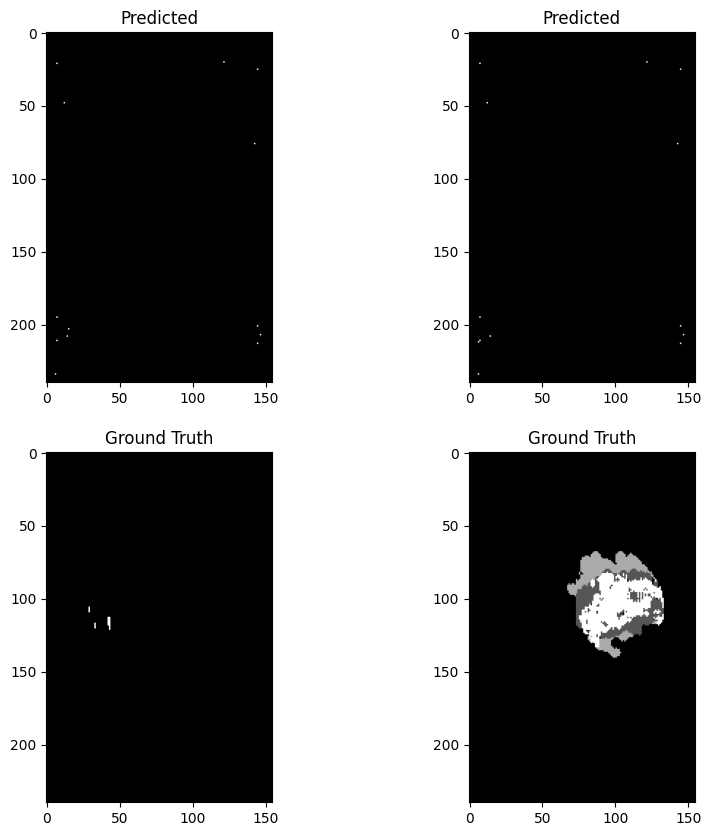

100%|██████████| 246/246 [08:31<00:00,  2.08s/it]



Average Training Loss: 0.18287201672489564

Average Training DSC: [0.98731428 0.41082391 0.74452103 0.05245223]
Average Training ASSD: [  2.85125367 184.93436637  92.48338636 282.76460683]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


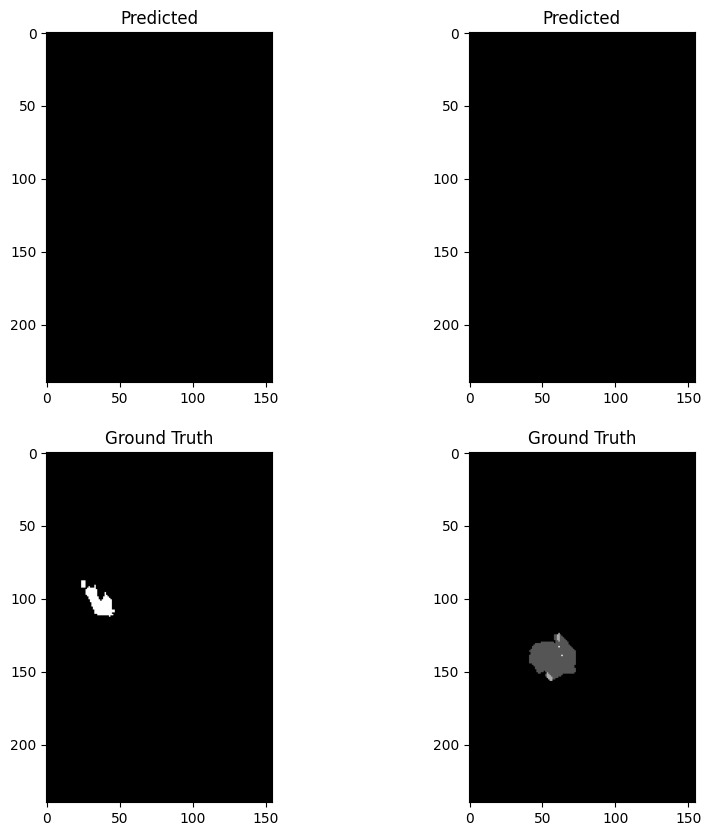

100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Average Validation Loss: 0.10217927396297455

Average Validation DSC: [0.98810064 0.33795163 0.71841398 0.15438963]
Average Validation ASSD: [  1.92153921 141.30568801 101.93413978 138.19826872]
Epoch 2/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


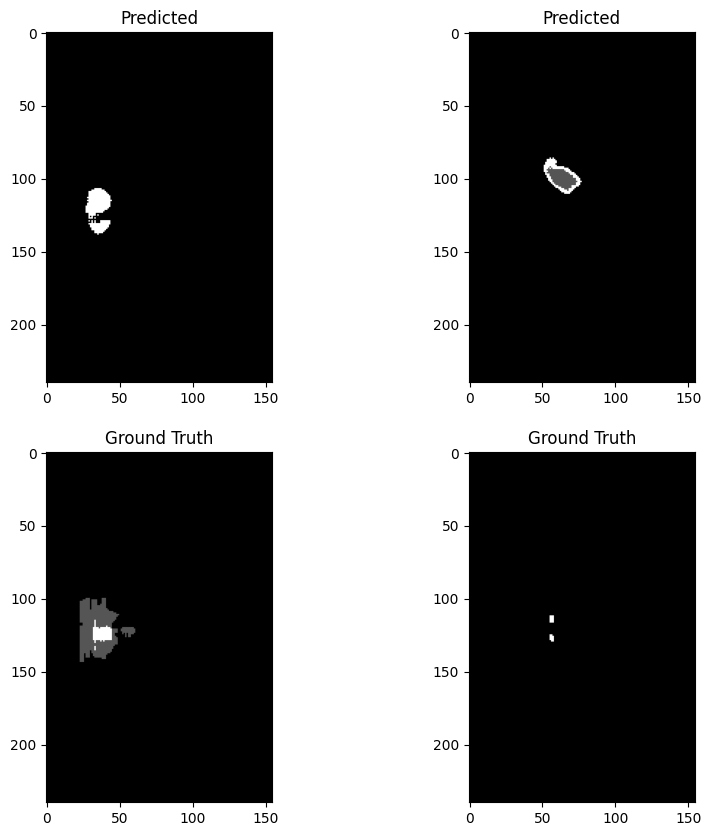

100%|██████████| 246/246 [09:12<00:00,  2.25s/it]



Average Training Loss: 0.05948563271421727

Average Training DSC: [0.99380441 0.3731028  0.74453576 0.28249605]
Average Training ASSD: [  0.68826847 155.70297943  92.47805467  36.39278099]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


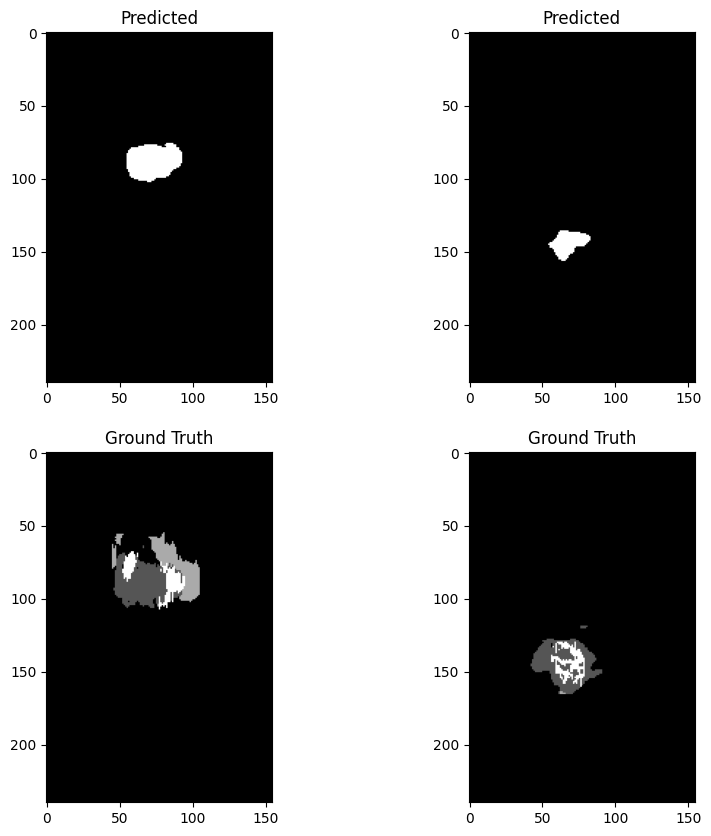

100%|██████████| 62/62 [01:26<00:00,  1.39s/it]


Average Validation Loss: 0.10698063515367047

Average Validation DSC: [0.9884897  0.43548387 0.72043011 0.20488783]
Average Validation ASSD: [  1.86979545 204.35483871 101.20430108 138.77932757]
Epoch 3/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


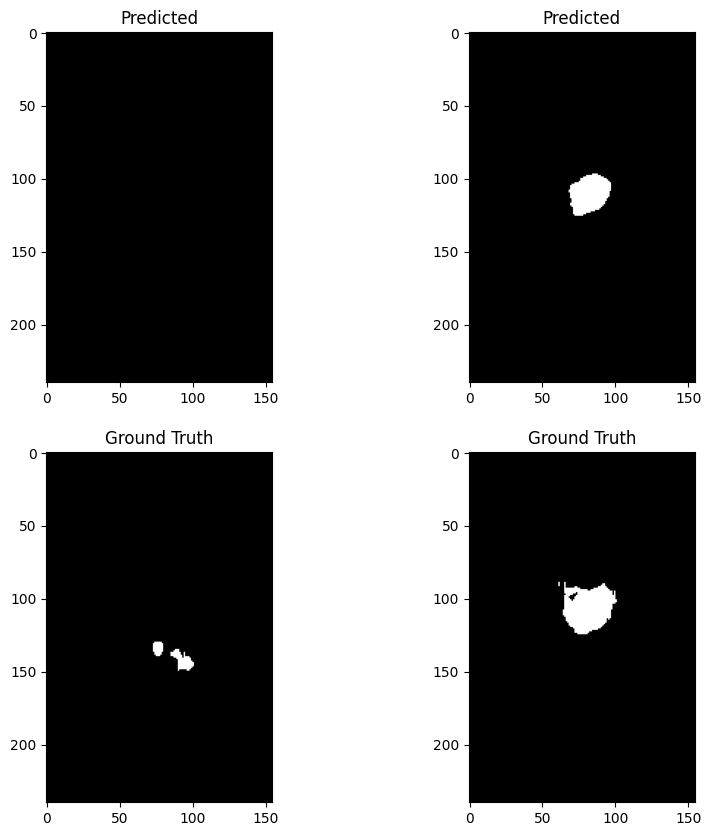

100%|██████████| 246/246 [08:21<00:00,  2.04s/it]



Average Training Loss: 0.05417139281526329

Average Training DSC: [0.99458806 0.38176874 0.74454312 0.32717383]
Average Training ASSD: [  0.58908275 159.61283407  92.47538883  38.77116462]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


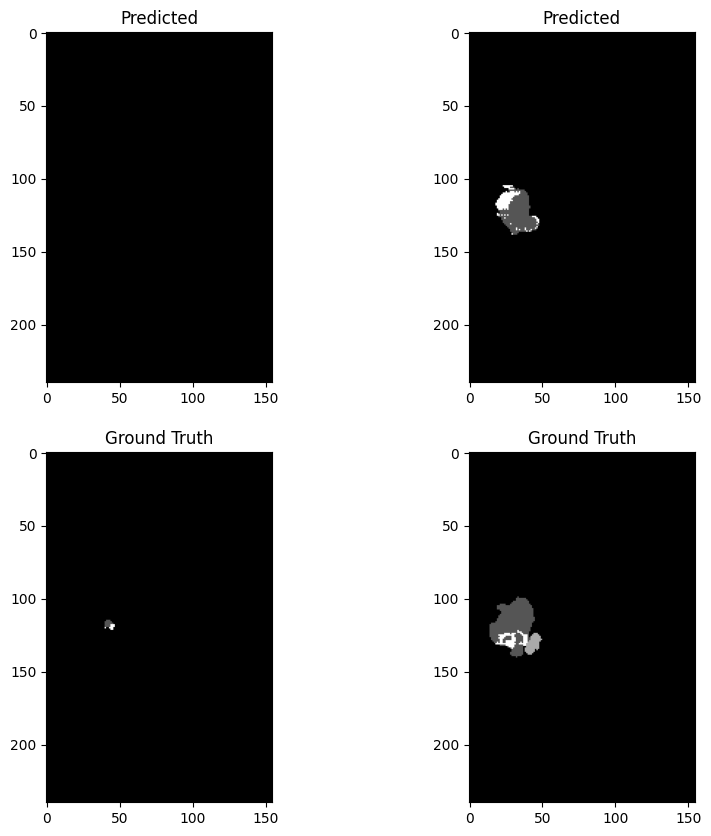

100%|██████████| 62/62 [01:29<00:00,  1.44s/it]


Average Validation Loss: 0.06335656044463958

Average Validation DSC: [0.99218713 0.31955058 0.72110215 0.07623772]
Average Validation ASSD: [  0.83278448 132.76337754 100.96102151 105.09365877]
Epoch 4/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


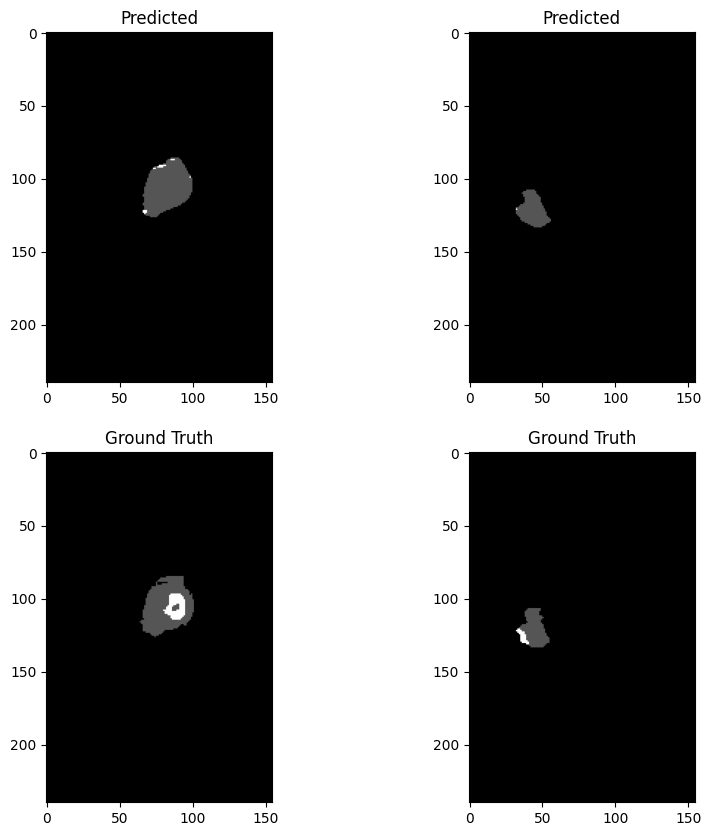

100%|██████████| 246/246 [08:26<00:00,  2.06s/it]



Average Training Loss: 0.04961376099627677

Average Training DSC: [0.99534943 0.32165922 0.74451367 0.36916149]
Average Training ASSD: [  0.49246898 130.24865003  92.4860522   26.14736559]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


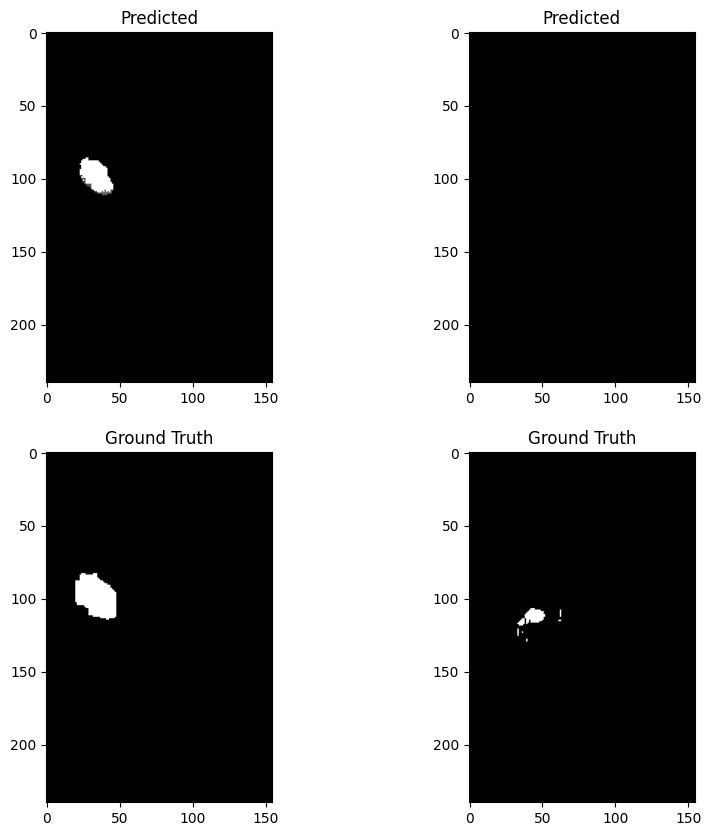

100%|██████████| 62/62 [01:31<00:00,  1.48s/it]


Average Validation Loss: 0.05045515890683858

Average Validation DSC: [0.99505752 0.28936461 0.71774194 0.40260997]
Average Validation ASSD: [  0.49716106 122.67461435 102.17741935  18.25316748]
Epoch 5/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


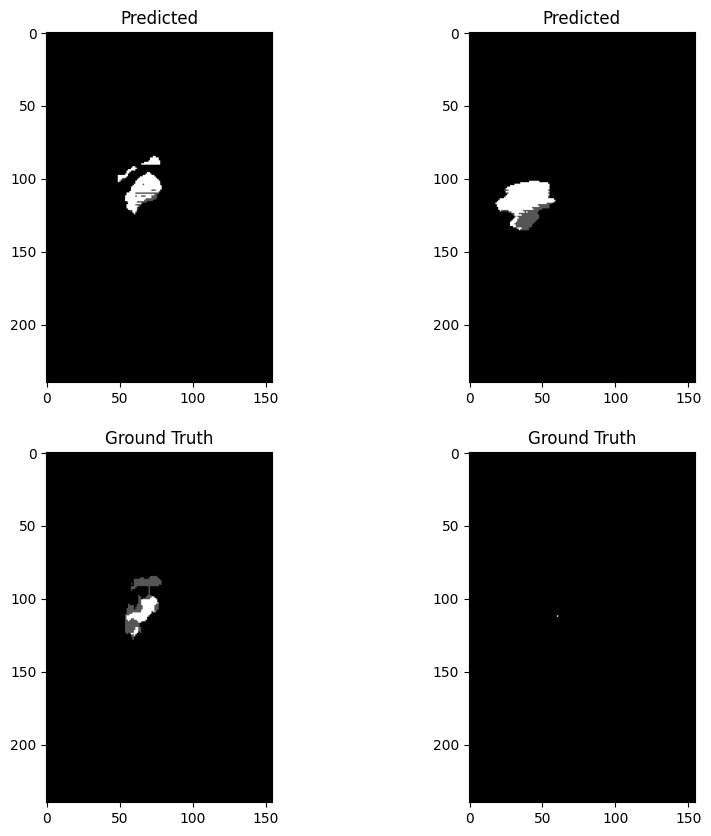

100%|██████████| 246/246 [08:28<00:00,  2.07s/it]



Average Training Loss: 0.04579246243295389

Average Training DSC: [0.99598632 0.3521605  0.74454312 0.39613962]
Average Training ASSD: [  0.42155681 115.64287585  92.47538883  24.50648968]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


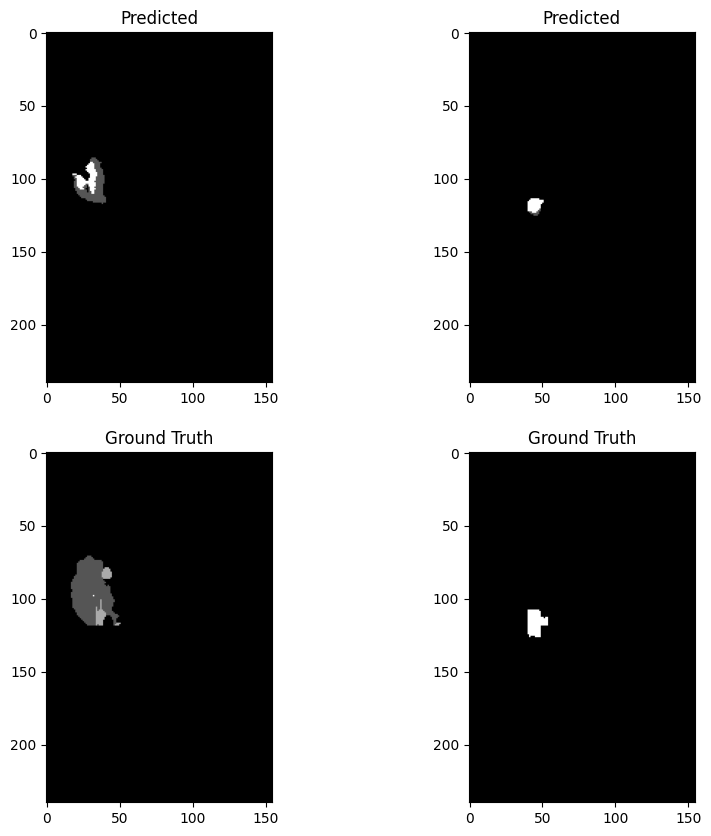

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.04873952155392016

Average Validation DSC: [0.99530512 0.3895743  0.72043011 0.17432311]
Average Validation ASSD: [  0.53016279 128.13994063 101.20430108  68.85377692]
Epoch 6/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


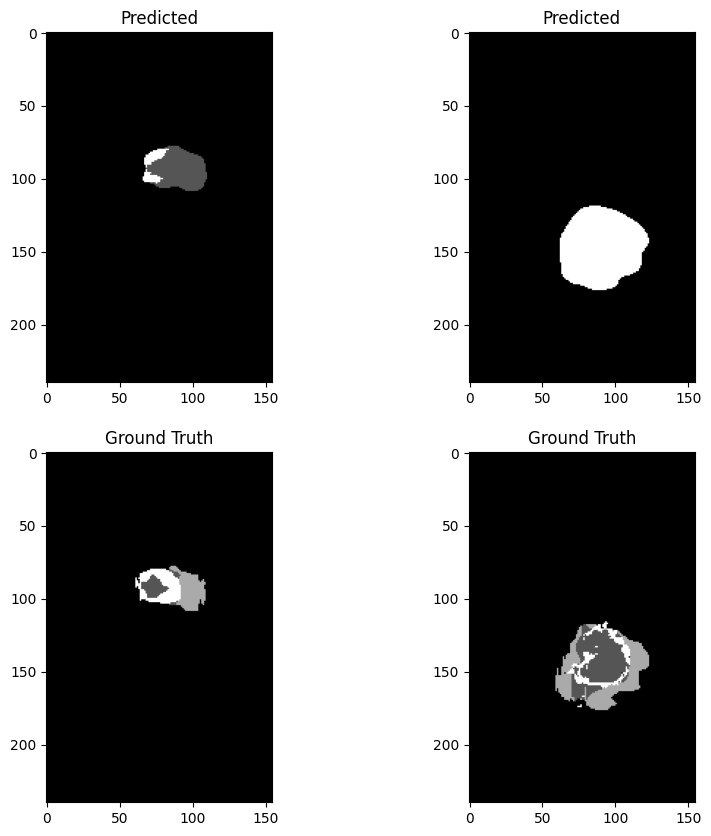

100%|██████████| 246/246 [08:28<00:00,  2.07s/it]



Average Training Loss: 0.04252951943535146

Average Training DSC: [0.99649189 0.42279819 0.74435166 0.40625915]
Average Training ASSD: [  0.36810182 108.27314134  92.54470072  33.79444899]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


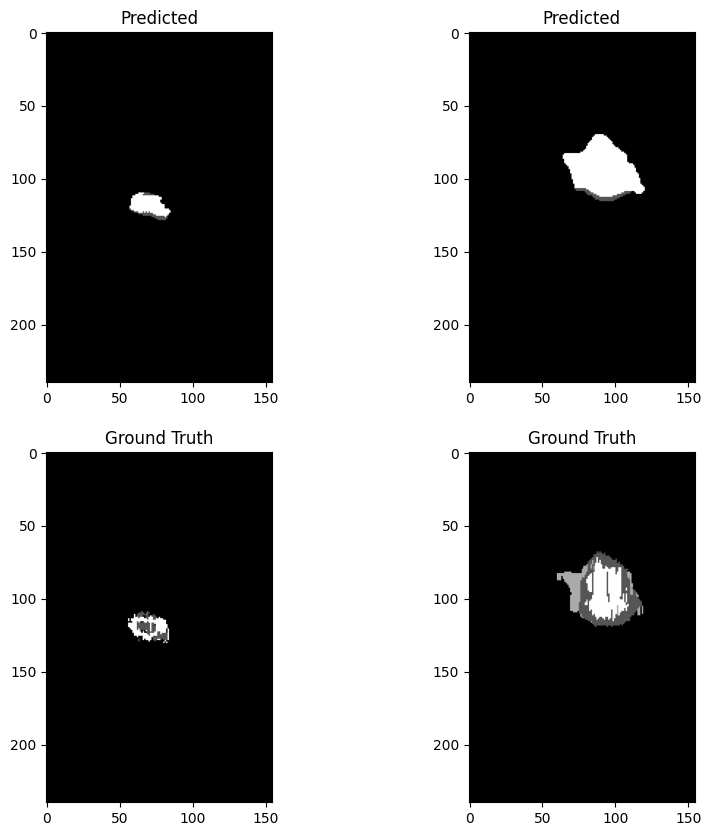

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.04269093707684548

Average Validation DSC: [0.99615178 0.41478147 0.71908602 0.43379181]
Average Validation ASSD: [  0.39329386 116.54574382 101.69086022  25.79907423]
Epoch 7/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


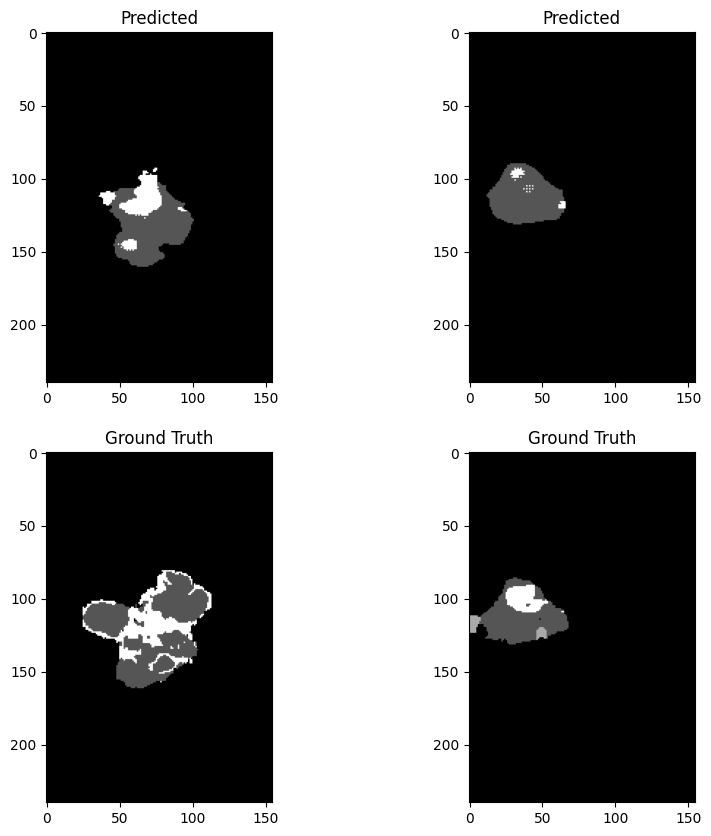

100%|██████████| 246/246 [08:23<00:00,  2.05s/it]



Average Training Loss: 0.038657996265929404

Average Training DSC: [0.9967095  0.52491249 0.65841415 0.409728  ]
Average Training ASSD: [  0.3503502   95.15258529 106.68954855  42.87548757]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


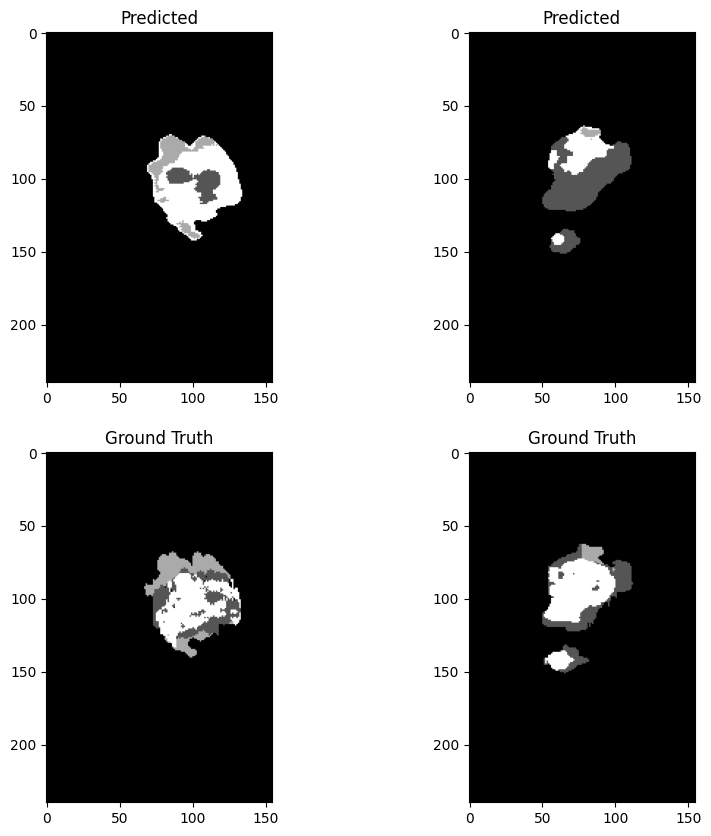

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.04294405973726703

Average Validation DSC: [0.99663916 0.48890478 0.56180139 0.23530354]
Average Validation ASSD: [  0.3827477  117.62423256 120.91015049  97.43070834]
Epoch 8/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


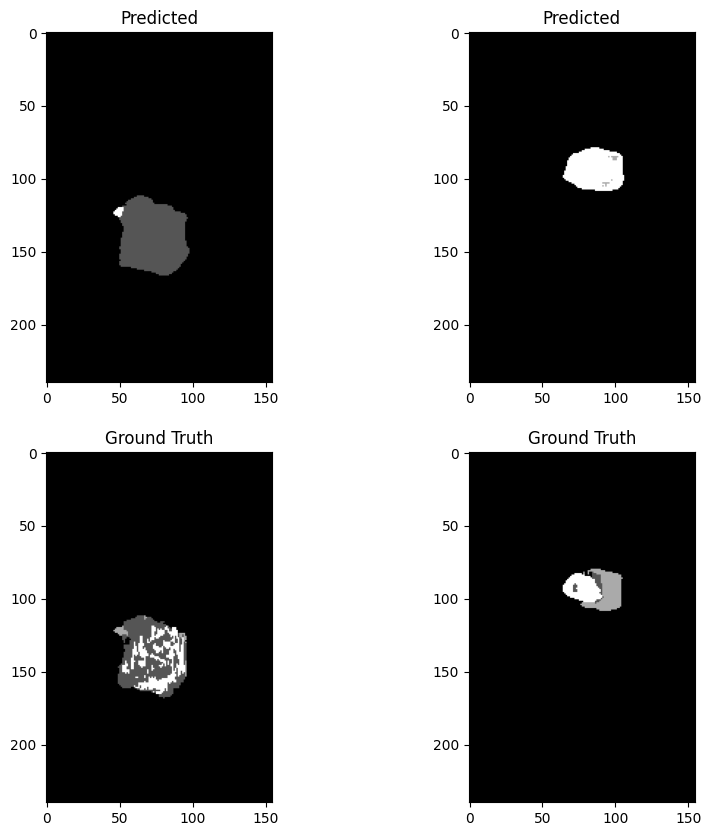

100%|██████████| 246/246 [08:28<00:00,  2.07s/it]



Average Training Loss: 0.03427262565620789

Average Training DSC: [0.99700666 0.56119458 0.63288384 0.42450804]
Average Training ASSD: [ 0.31187136 91.8050719  99.28447301 47.67673314]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


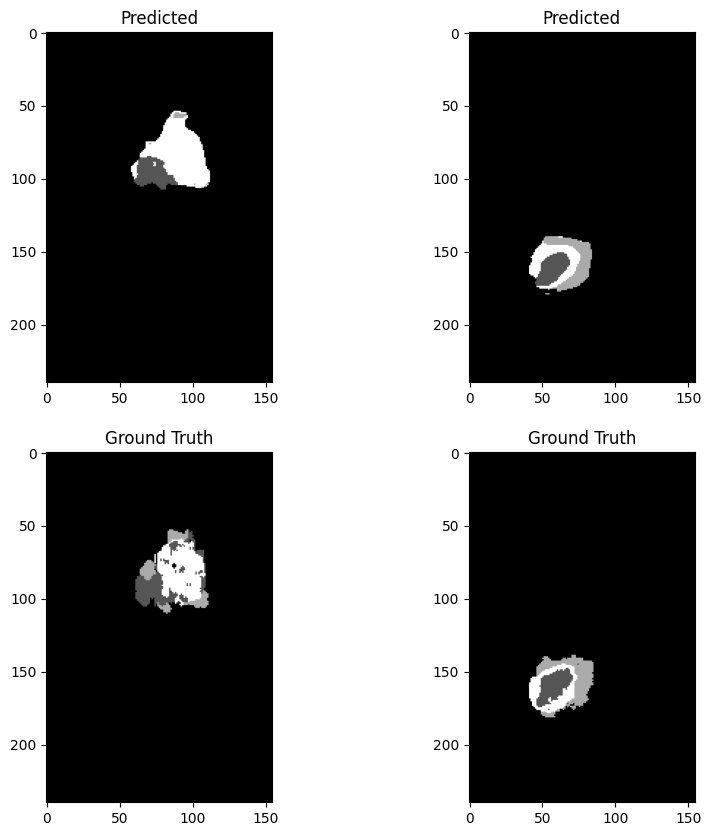

100%|██████████| 62/62 [01:33<00:00,  1.50s/it]


Average Validation Loss: 0.03082837603024898

Average Validation DSC: [0.99715725 0.60575085 0.69781972 0.45615503]
Average Validation ASSD: [ 0.30463946 82.69540048 72.27111966 49.49391286]
Epoch 9/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


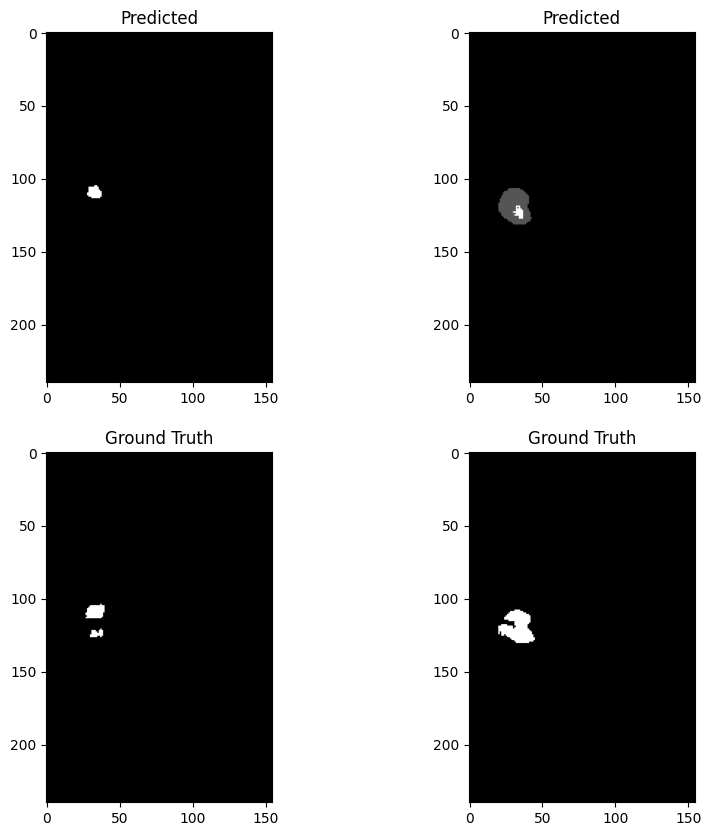

100%|██████████| 246/246 [08:30<00:00,  2.08s/it]



Average Training Loss: 0.028326357760262197

Average Training DSC: [0.99735054 0.64287955 0.7345344  0.49814621]
Average Training ASSD: [ 0.2764044  72.13171325 67.68868006 44.19451281]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


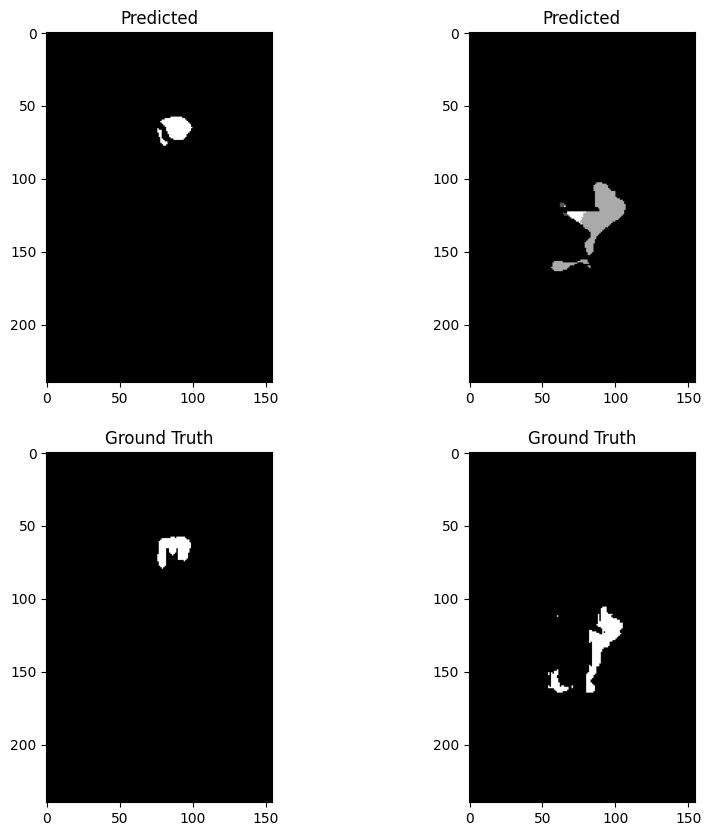

100%|██████████| 62/62 [01:33<00:00,  1.50s/it]


Average Validation Loss: 0.0261448796297754

Average Validation DSC: [0.99747999 0.69678457 0.7268458  0.55615401]
Average Validation ASSD: [ 0.28608351 53.31553922 66.05184615 30.02863709]
Epoch 10/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


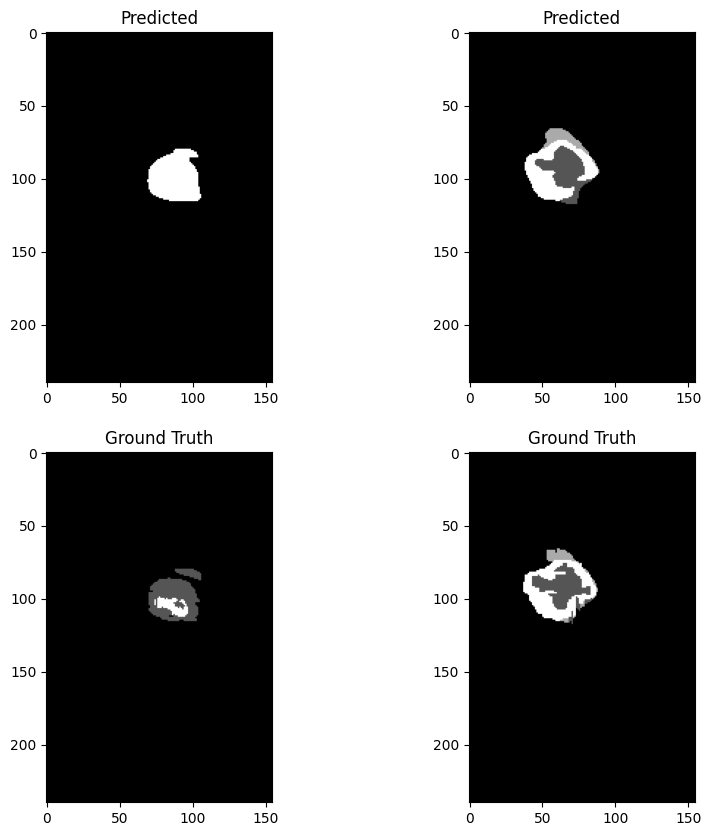

100%|██████████| 246/246 [08:29<00:00,  2.07s/it]



Average Training Loss: 0.02493349443439667

Average Training DSC: [0.99751635 0.69020104 0.77999191 0.55134427]
Average Training ASSD: [ 0.26483807 61.14639618 53.26363564 38.68485492]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


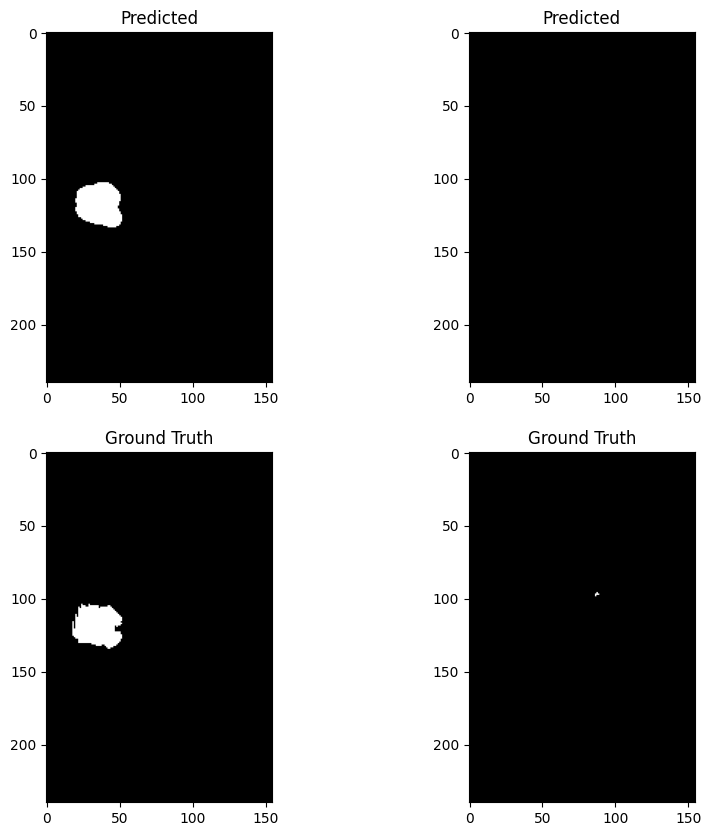

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.02686115100439037

Average Validation DSC: [0.9971231  0.71353851 0.7134731  0.6019074 ]
Average Validation ASSD: [ 0.26893056 46.86737872 70.64326184 19.95169624]
Epoch 11/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


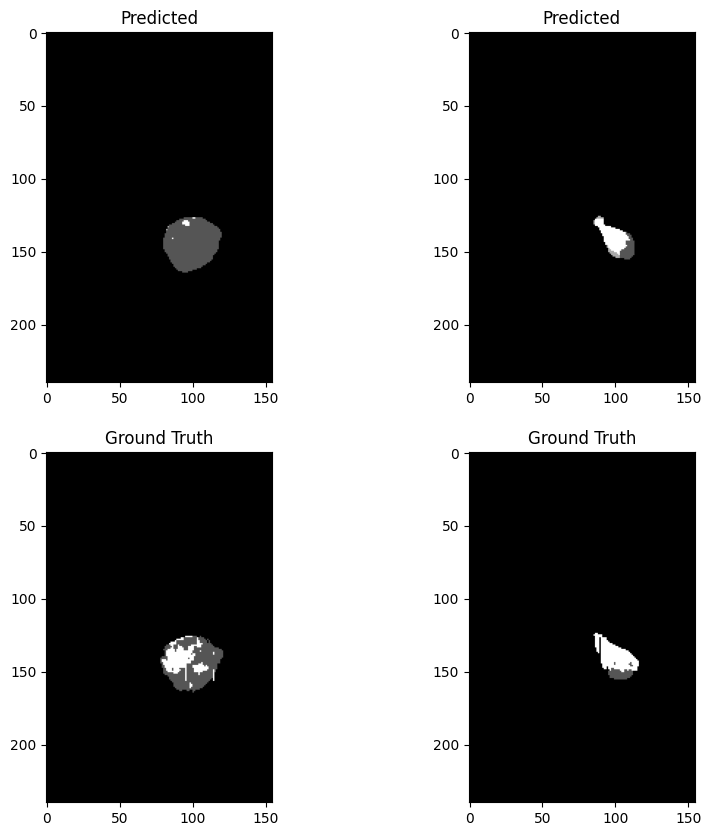

100%|██████████| 246/246 [08:30<00:00,  2.08s/it]



Average Training Loss: 0.021987616262451663

Average Training DSC: [0.99769973 0.72997571 0.82211404 0.59379112]
Average Training ASSD: [ 0.23335443 49.72869235 40.33061202 33.89038755]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


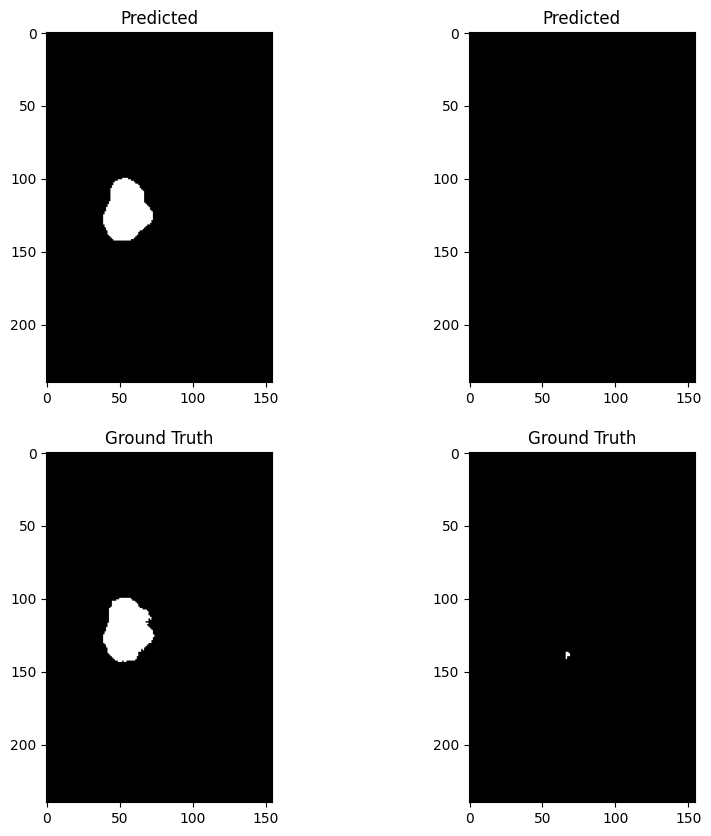

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.021429052351102713

Average Validation DSC: [0.99788265 0.73868527 0.83407871 0.65075667]
Average Validation ASSD: [ 0.21998116 41.20230462 30.35270469 19.66084006]
Epoch 12/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


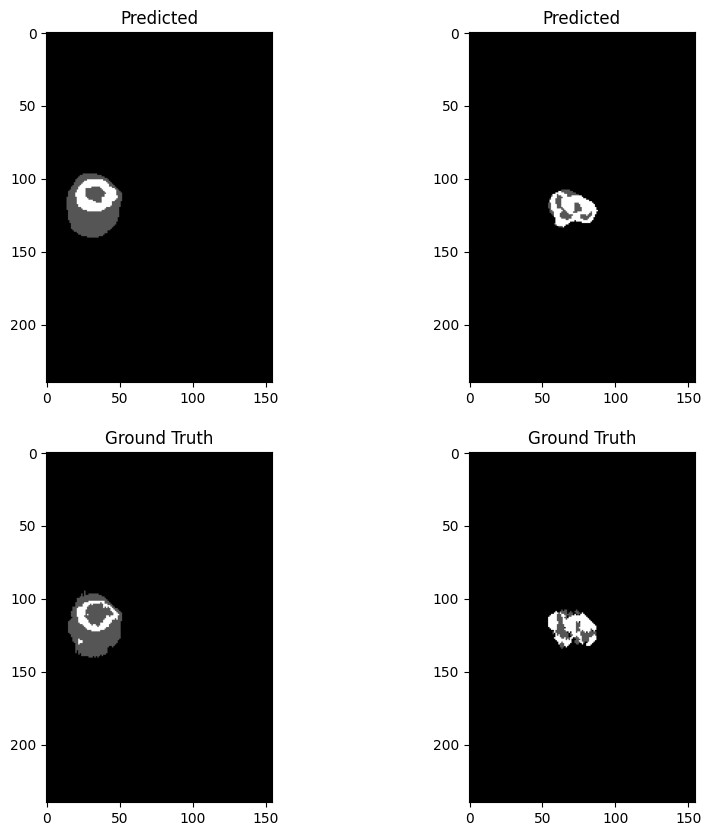

100%|██████████| 246/246 [08:29<00:00,  2.07s/it]



Average Training Loss: 0.019595477745179238

Average Training DSC: [0.99792635 0.76224576 0.83964233 0.63103074]
Average Training ASSD: [ 0.20749049 40.79673357 36.01474201 30.05980477]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


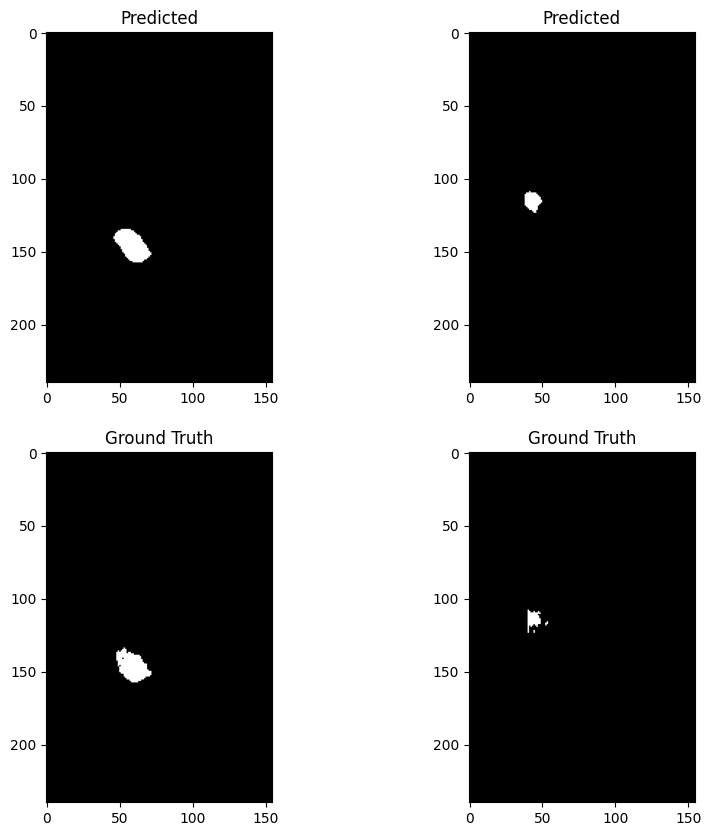

100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Average Validation Loss: 0.023014441252716126

Average Validation DSC: [0.99793949 0.72867832 0.83003015 0.65589328]
Average Validation ASSD: [ 0.20318882 31.6972741  31.60036511 13.70481934]
Epoch 13/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


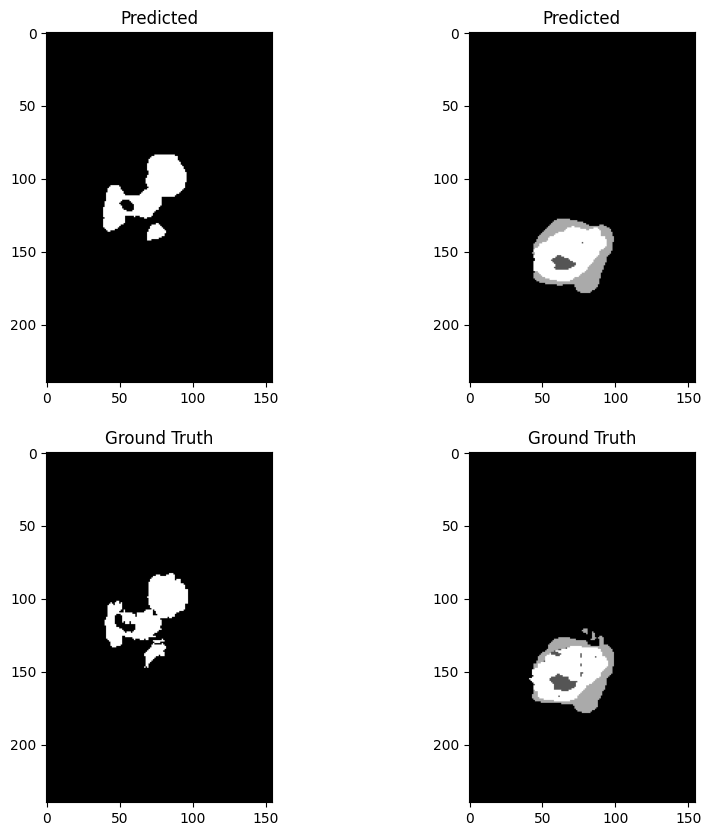

100%|██████████| 246/246 [08:32<00:00,  2.08s/it]



Average Training Loss: 0.01800123879655711

Average Training DSC: [0.99807523 0.77690037 0.86505131 0.65451603]
Average Training ASSD: [ 0.19112467 38.86080485 28.14142595 26.65434794]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


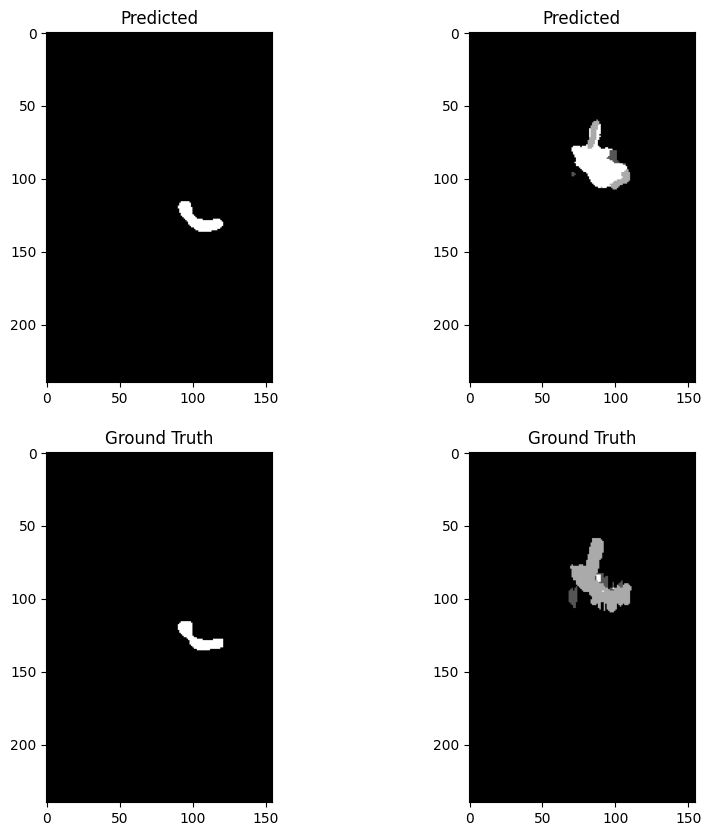

100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Average Validation Loss: 0.022532878924281366

Average Validation DSC: [0.99767295 0.69194512 0.85099167 0.66229164]
Average Validation ASSD: [ 0.27913051 58.35008096 26.16868886 11.33311903]
Epoch 14/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


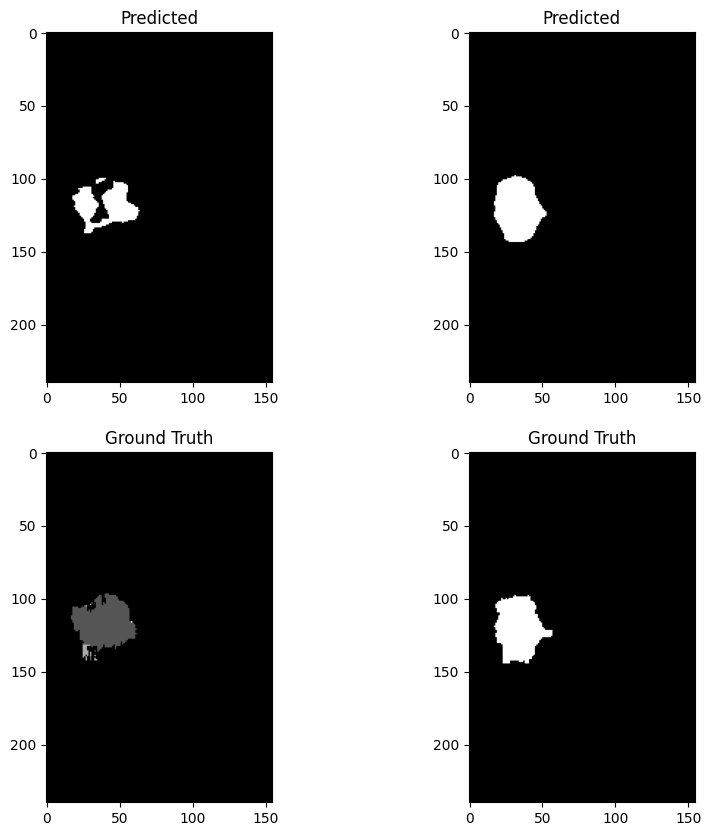

100%|██████████| 246/246 [08:29<00:00,  2.07s/it]



Average Training Loss: 0.017015207165140447

Average Training DSC: [0.9981668  0.7970938  0.86917533 0.6736847 ]
Average Training ASSD: [ 0.18276168 34.60124727 26.81011973 25.45938797]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


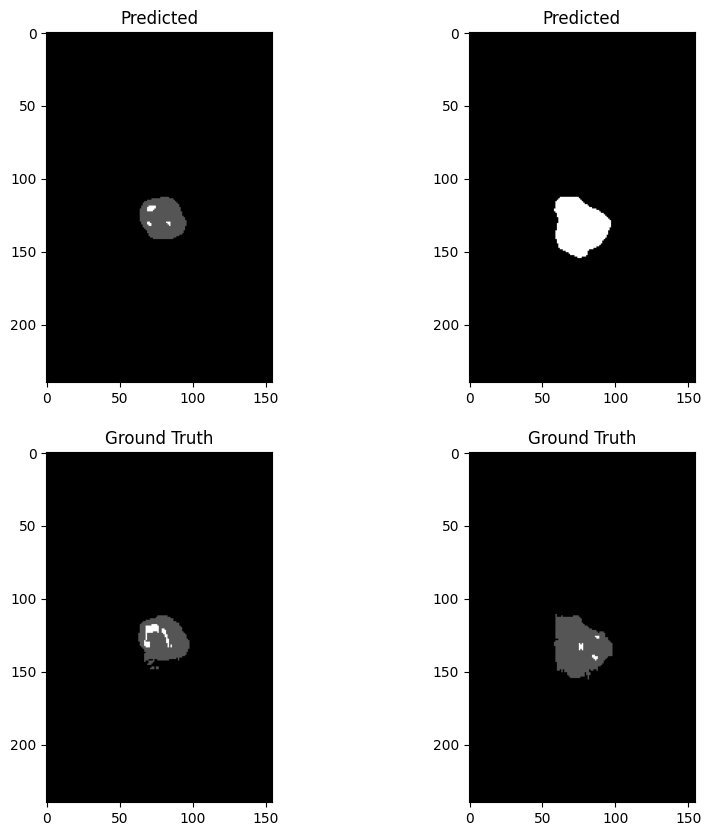

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.020565446466207504

Average Validation DSC: [0.9976251  0.77688644 0.85832878 0.61159072]
Average Validation ASSD: [ 0.24127031 29.94001788 23.46258515 29.1730352 ]
Epoch 15/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


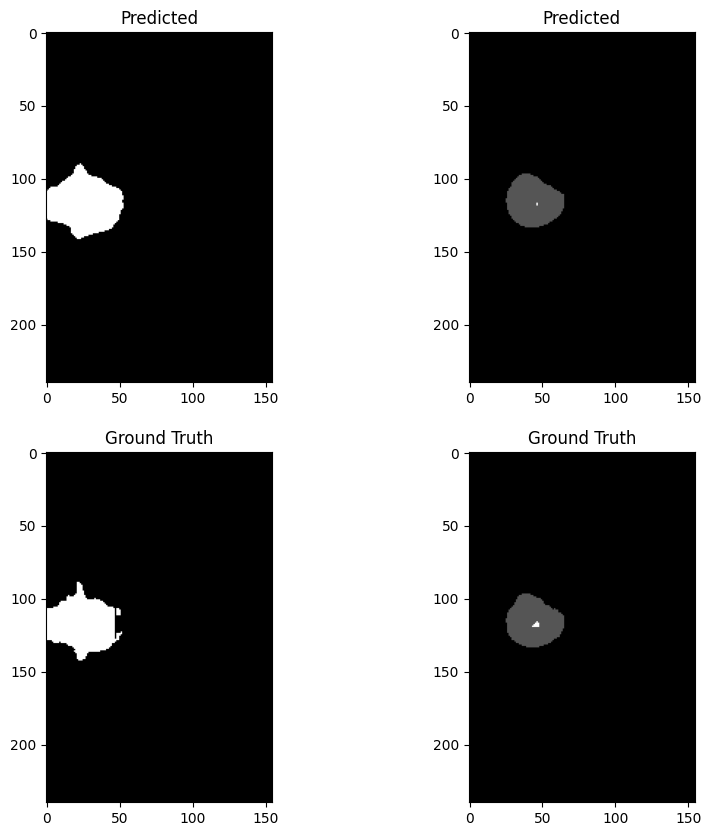

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.015503413990382256

Average Training DSC: [0.99831823 0.81383642 0.88557907 0.69065103]
Average Training ASSD: [ 0.16310781 30.79915126 23.053871   24.1316202 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


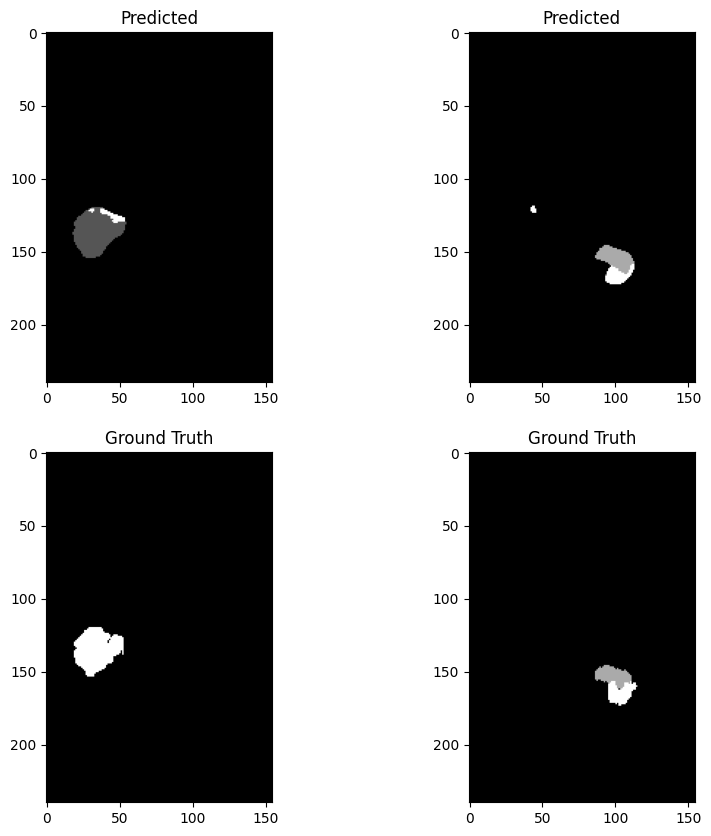

100%|██████████| 62/62 [01:35<00:00,  1.55s/it]


Average Validation Loss: 0.016551311172905467

Average Validation DSC: [0.99806892 0.81188119 0.84221296 0.6833788 ]
Average Validation ASSD: [ 0.1827939  31.36221836 35.28423255 22.32742046]
Epoch 16/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


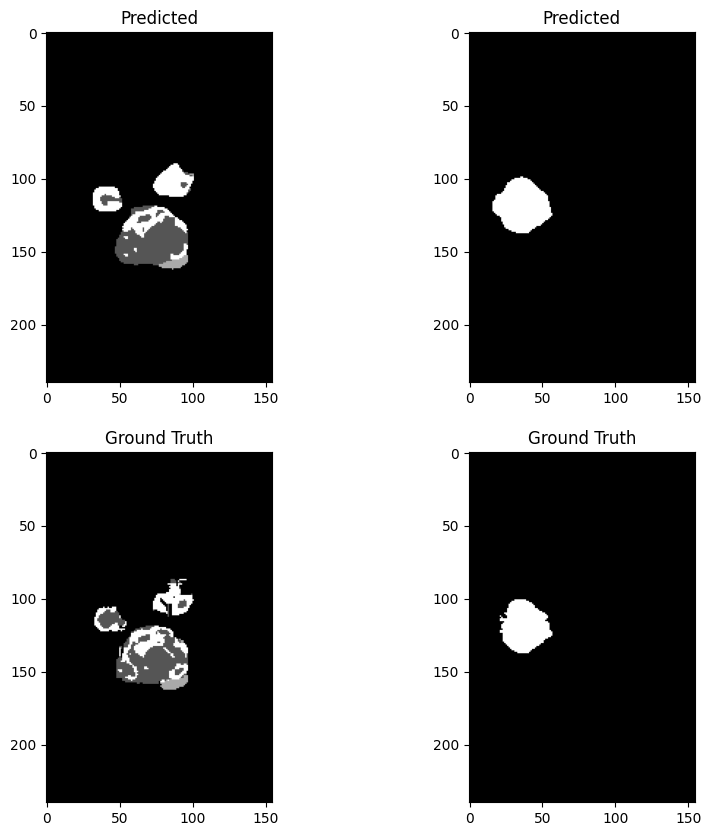

100%|██████████| 246/246 [08:35<00:00,  2.09s/it]



Average Training Loss: 0.014495587430712654

Average Training DSC: [0.99838457 0.82635775 0.88936932 0.70408595]
Average Training ASSD: [ 0.15832937 27.52051888 21.72773885 21.71632168]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


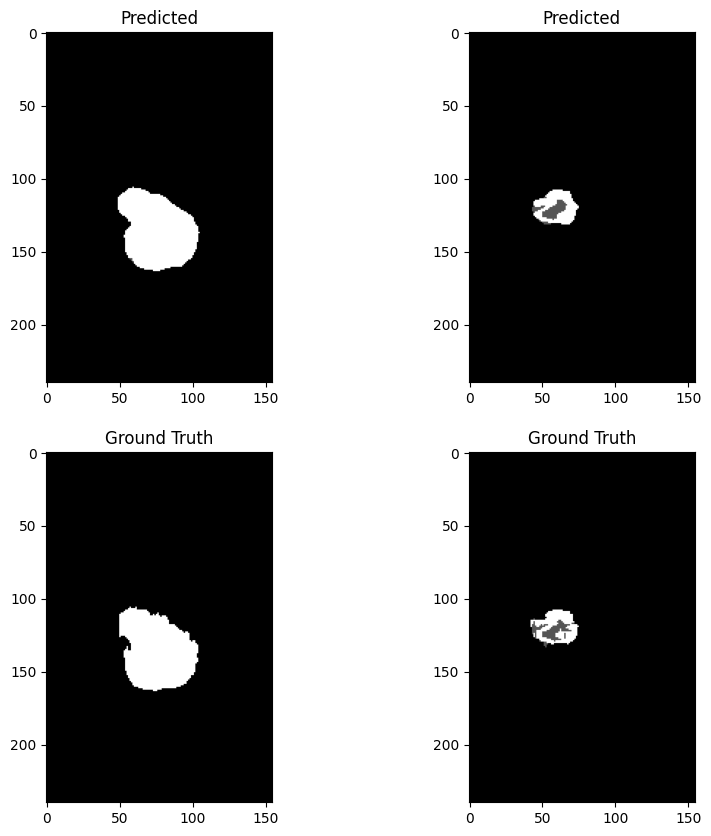

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.015841265854936455

Average Validation DSC: [0.99831105 0.79633703 0.880814   0.65882984]
Average Validation ASSD: [ 0.17956921 37.18649682 21.42246565 33.48110437]
Epoch 17/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


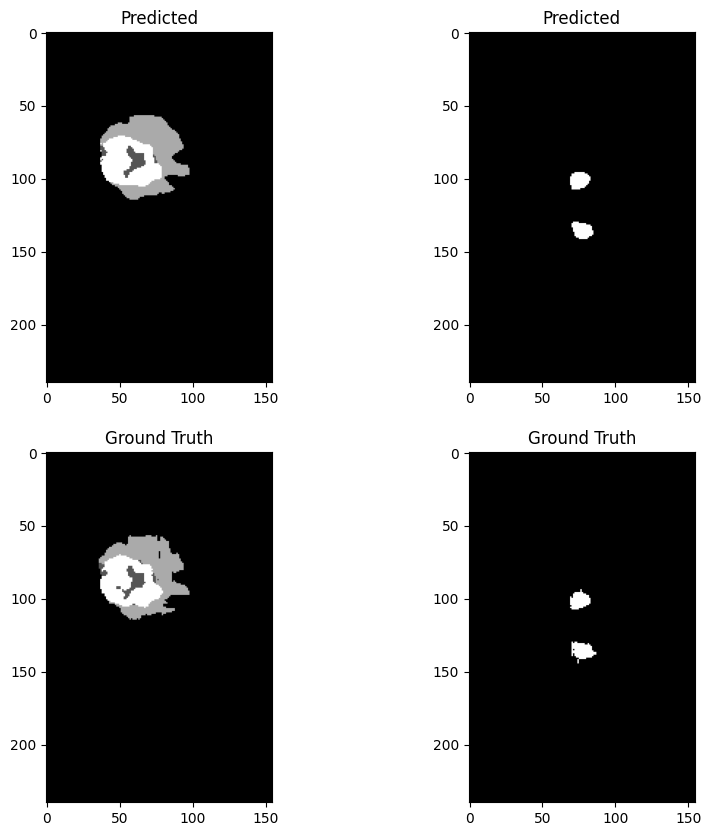

100%|██████████| 246/246 [08:36<00:00,  2.10s/it]



Average Training Loss: 0.013999400471102416

Average Training DSC: [0.9984415  0.83337577 0.89450255 0.71531769]
Average Training ASSD: [ 0.15298154 26.5037781  20.47128005 22.43804145]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


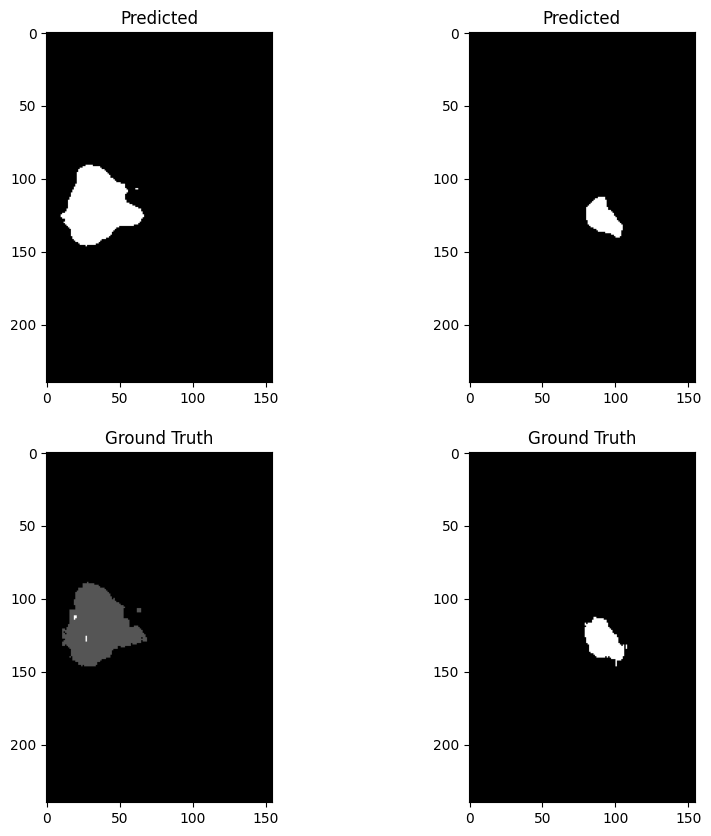

100%|██████████| 62/62 [01:38<00:00,  1.59s/it]


Average Validation Loss: 0.01615138059001296

Average Validation DSC: [0.99820456 0.83066143 0.88487375 0.70387357]
Average Validation ASSD: [ 0.16940797 24.27675424 19.19233052 17.6923318 ]
Epoch 18/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


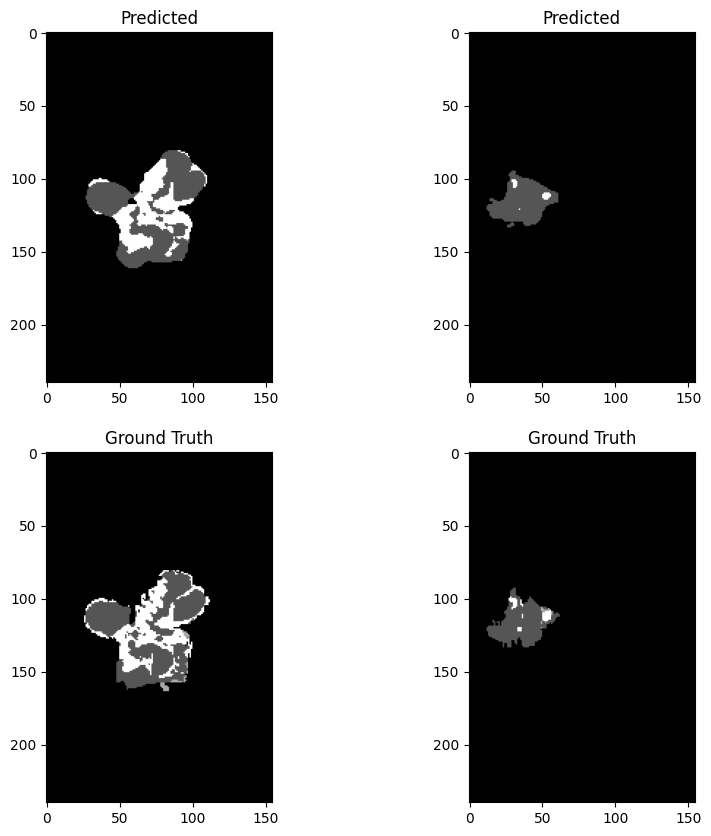

100%|██████████| 246/246 [09:19<00:00,  2.28s/it]



Average Training Loss: 0.013612292016046197

Average Training DSC: [0.99848243 0.83383897 0.90219043 0.72319036]
Average Training ASSD: [ 0.1435343  26.27652878 18.3852268  18.88143741]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


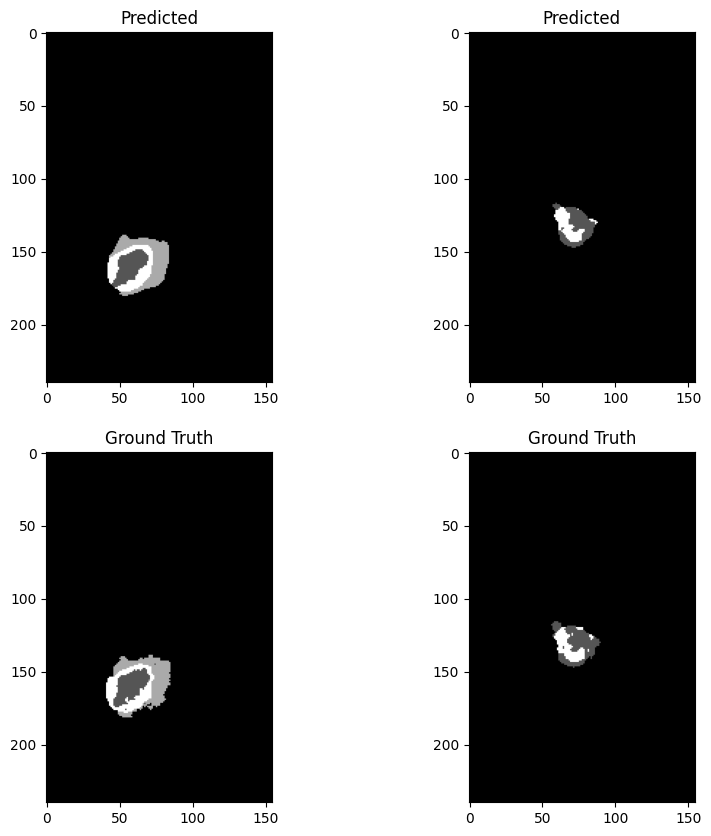

100%|██████████| 62/62 [01:48<00:00,  1.75s/it]


Average Validation Loss: 0.015927231389909022

Average Validation DSC: [0.99823896 0.82037302 0.88837708 0.72164673]
Average Validation ASSD: [ 0.1753744  21.43058635 17.34116508 13.71000528]
Epoch 19/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


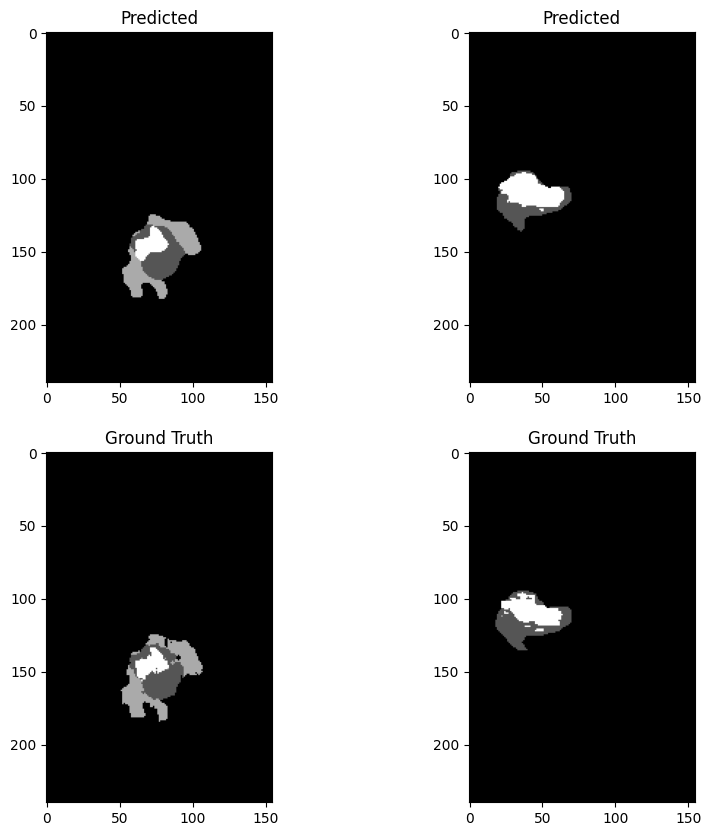

100%|██████████| 246/246 [09:29<00:00,  2.32s/it]



Average Training Loss: 0.012448624603647164

Average Training DSC: [0.99859226 0.85514739 0.90732042 0.73645688]
Average Training ASSD: [ 0.13349137 21.18441818 17.07767768 19.71414962]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


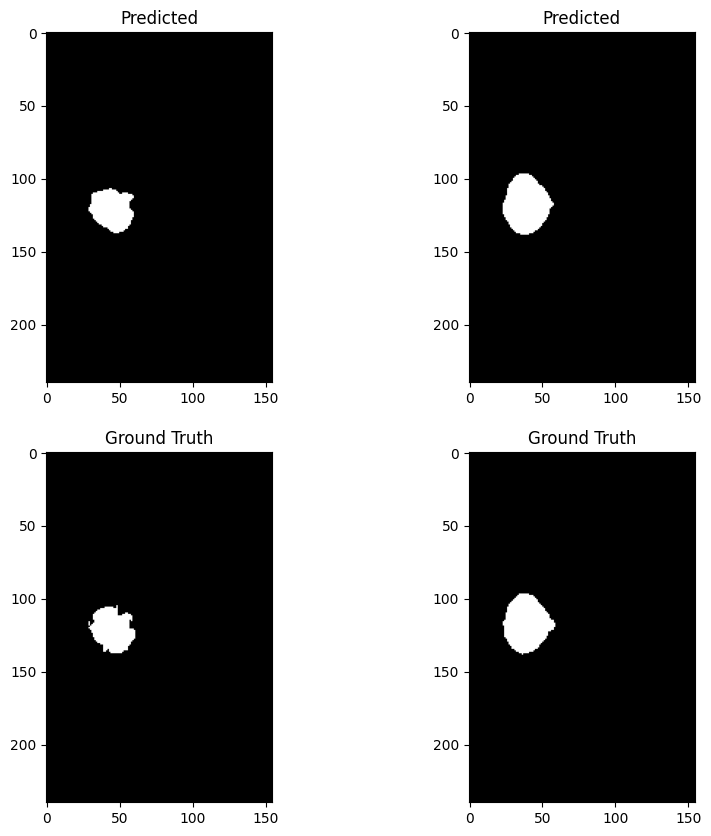

100%|██████████| 62/62 [01:45<00:00,  1.70s/it]


Average Validation Loss: 0.015186855133863227

Average Validation DSC: [0.99828136 0.83312024 0.88188096 0.73532043]
Average Validation ASSD: [ 0.1790244  22.81331003 21.31976147  9.99991702]
Epoch 20/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


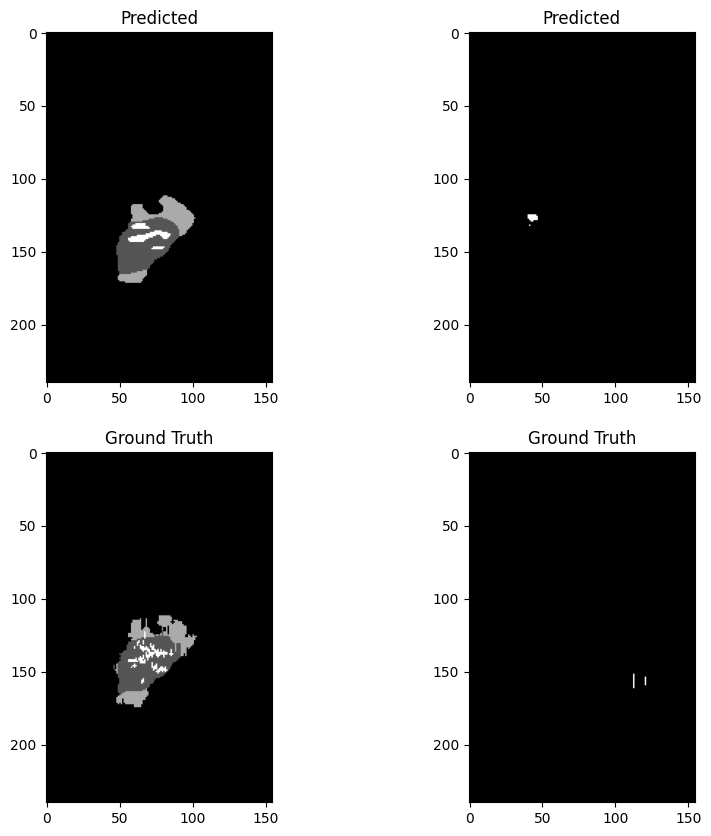

100%|██████████| 246/246 [09:17<00:00,  2.26s/it]



Average Training Loss: 0.0123015863582401

Average Training DSC: [0.99861868 0.85840792 0.90537489 0.74261777]
Average Training ASSD: [ 0.13260192 20.25888609 17.63575009 18.97471746]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


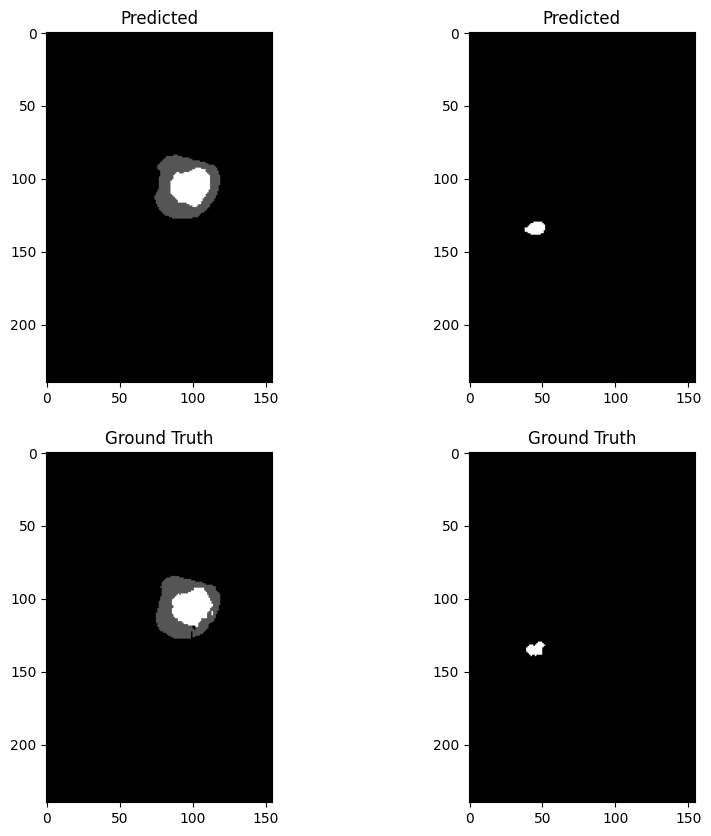

100%|██████████| 62/62 [01:43<00:00,  1.67s/it]


Average Validation Loss: 0.014990655705332756

Average Validation DSC: [0.99828917 0.84389714 0.91122455 0.74861198]
Average Validation ASSD: [ 0.14921266 15.31426197 10.85716114  8.09940775]
Epoch 21/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


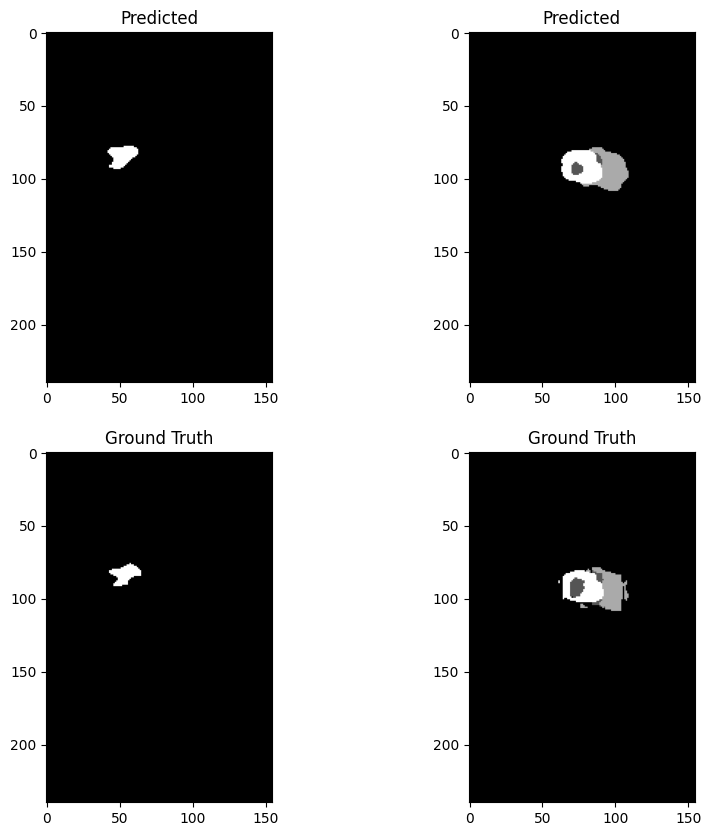

100%|██████████| 246/246 [09:00<00:00,  2.20s/it]



Average Training Loss: 0.012355624260835169

Average Training DSC: [0.99859309 0.85739875 0.90614619 0.74613608]
Average Training ASSD: [ 0.13702743 21.40947259 17.13142954 17.13315292]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


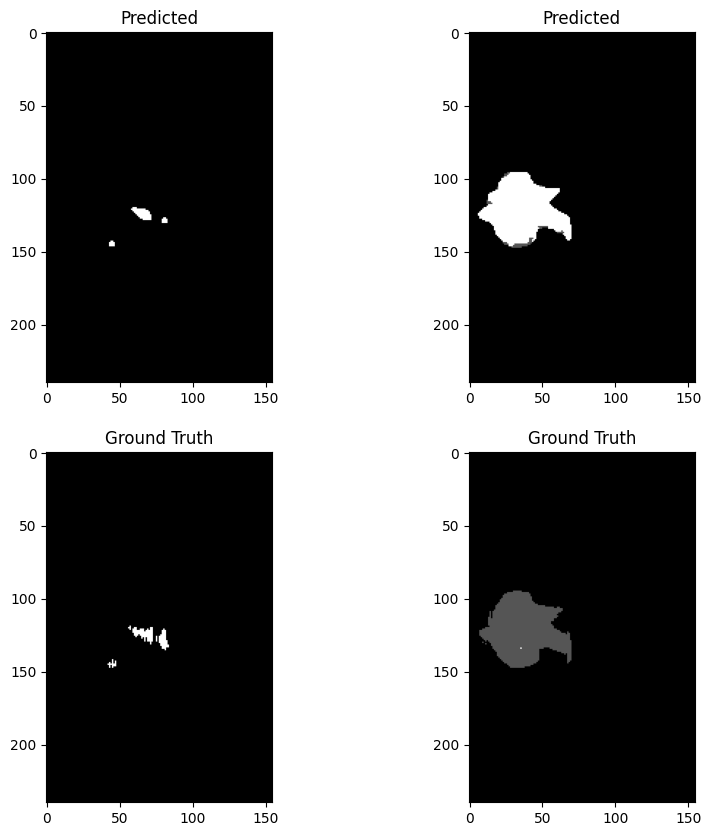

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.0127553345575448

Average Validation DSC: [0.99855247 0.85285238 0.90517844 0.75213614]
Average Validation ASSD: [ 0.15246591 19.80706715 14.48350433 14.65804583]
Epoch 22/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


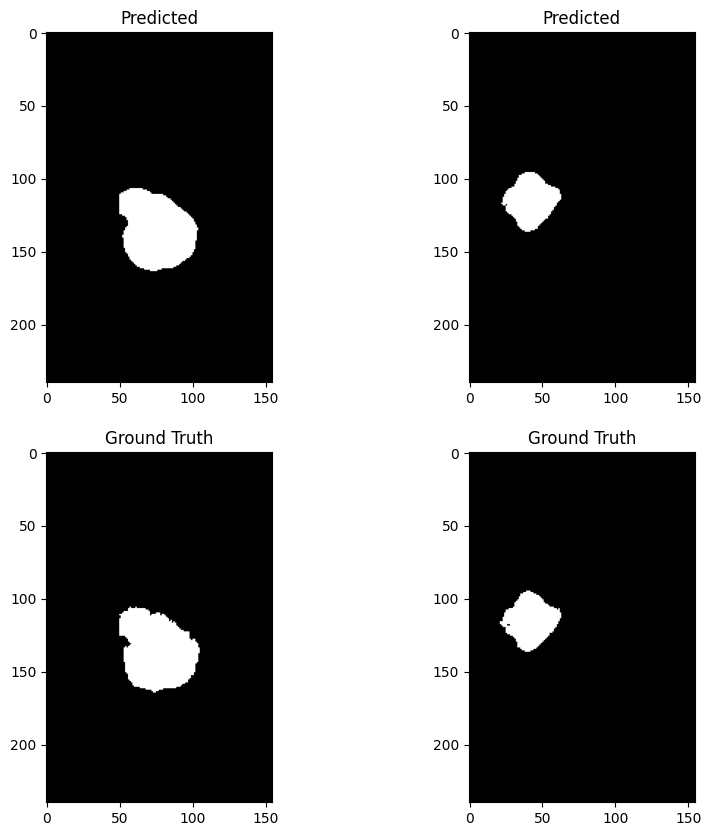

100%|██████████| 246/246 [08:58<00:00,  2.19s/it]



Average Training Loss: 0.011298852332875253

Average Training DSC: [0.99874115 0.86648092 0.91522905 0.75813542]
Average Training ASSD: [ 0.11965274 19.47394848 15.08664723 16.24984477]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


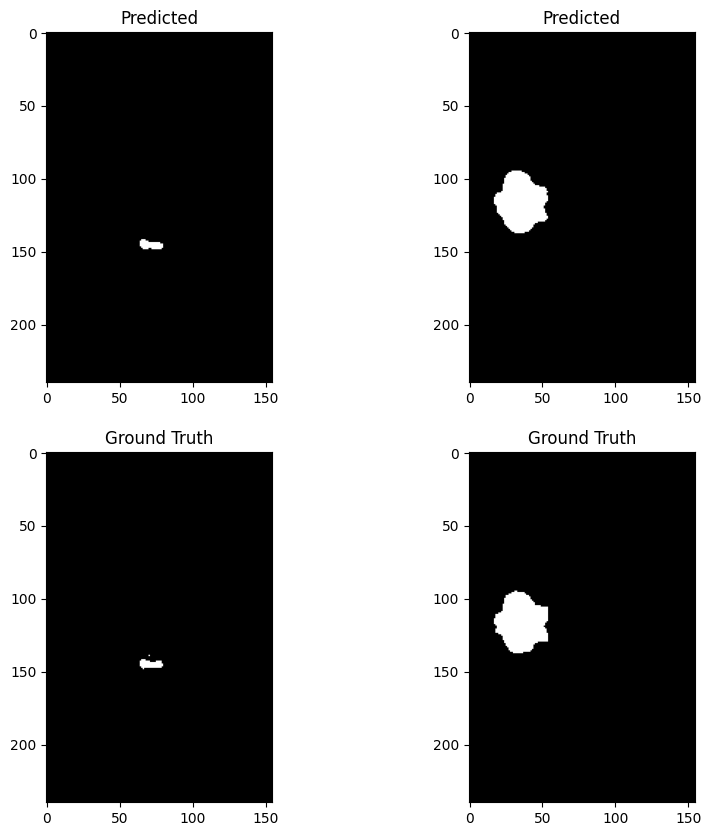

100%|██████████| 62/62 [01:37<00:00,  1.57s/it]


Average Validation Loss: 0.012011308410775757

Average Validation DSC: [0.9986318  0.85391778 0.9175404  0.765691  ]
Average Validation ASSD: [ 0.1359779  20.52195249 10.7952093  13.52663848]
Epoch 23/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


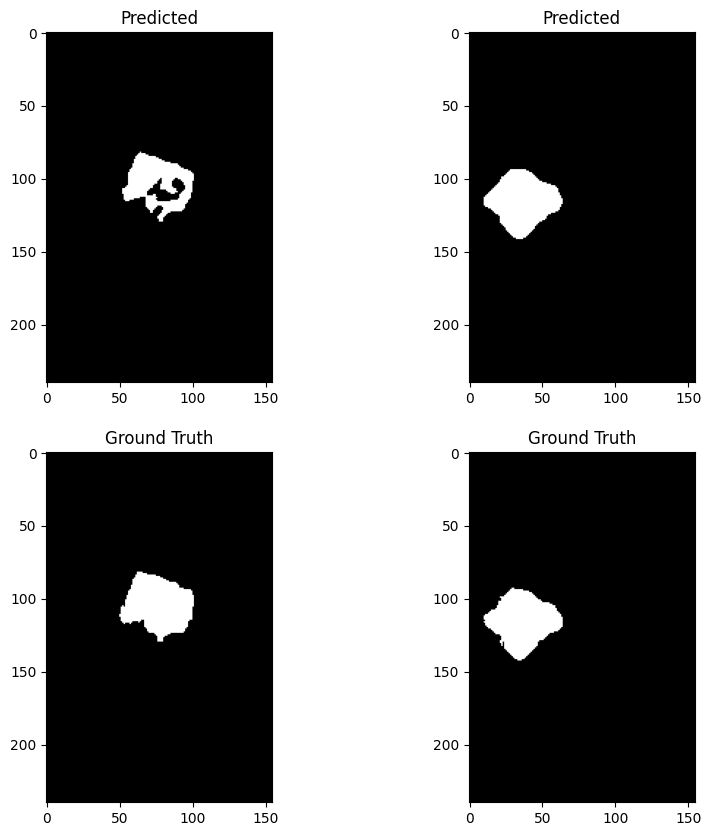

100%|██████████| 246/246 [08:44<00:00,  2.13s/it]



Average Training Loss: 0.011673332366153477

Average Training DSC: [0.99867604 0.86221588 0.90420016 0.75636698]
Average Training ASSD: [ 0.13118136 20.57471519 18.39693305 18.00451969]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


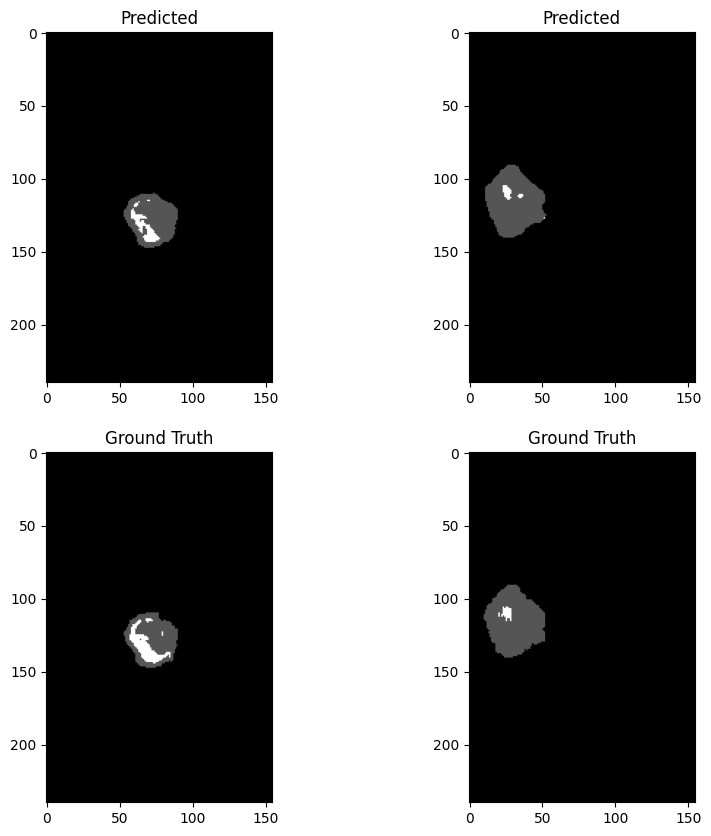

100%|██████████| 62/62 [01:42<00:00,  1.65s/it]


Average Validation Loss: 0.012434911951723119

Average Validation DSC: [0.9987136  0.85712399 0.90862416 0.70288677]
Average Validation ASSD: [ 0.12606891 19.08151551 14.95120206 25.0044937 ]
Epoch 24/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


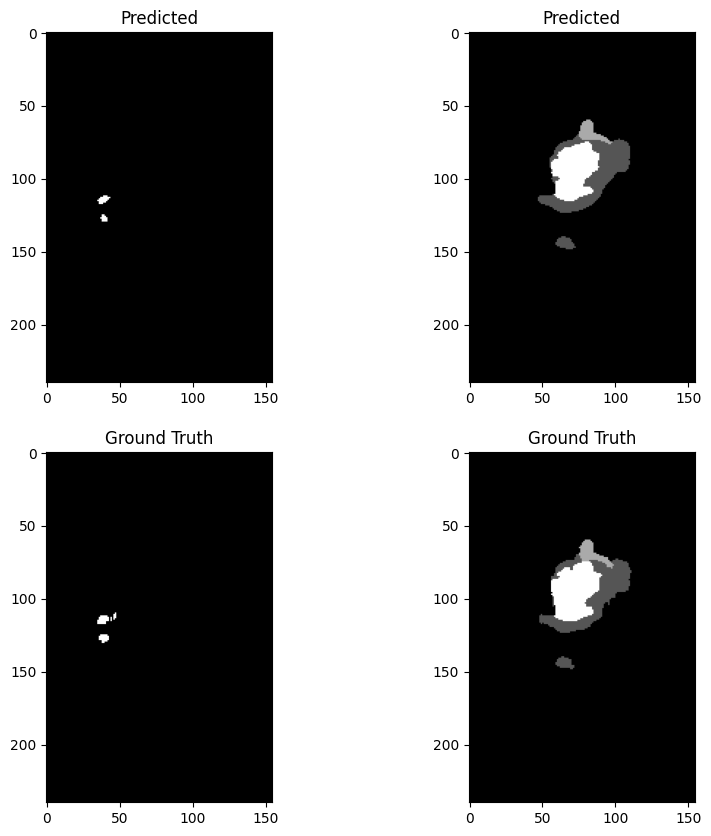

100%|██████████| 246/246 [08:56<00:00,  2.18s/it]



Average Training Loss: 0.010527657435798064

Average Training DSC: [0.99880405 0.87211352 0.92042169 0.77111978]
Average Training ASSD: [ 0.11144836 19.20625298 13.59947681 15.36689842]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


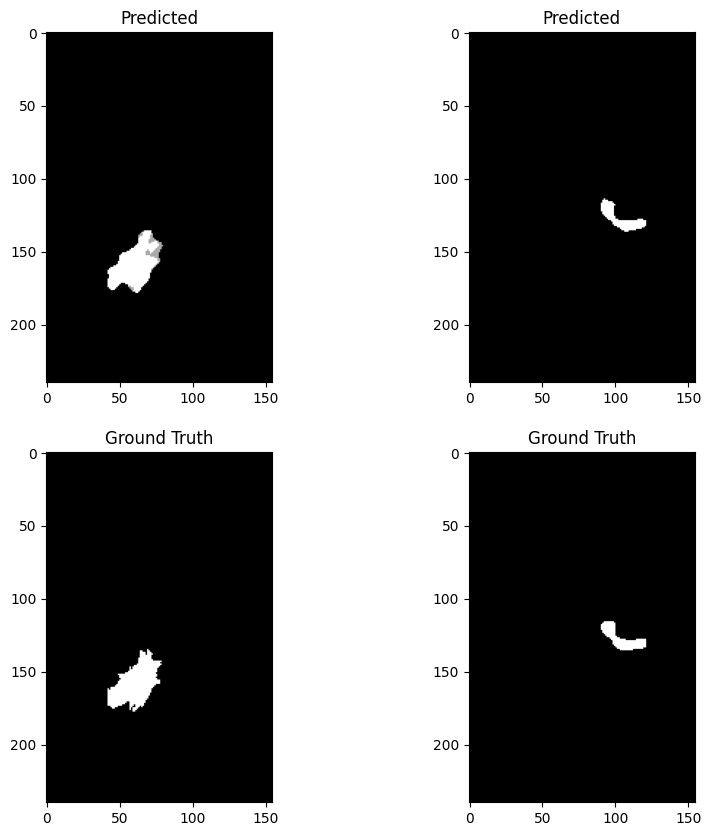

100%|██████████| 62/62 [01:46<00:00,  1.71s/it]


Average Validation Loss: 0.012235881693120445

Average Validation DSC: [0.9986309  0.81550199 0.85790484 0.74253882]
Average Validation ASSD: [ 0.13350185 36.79087641 31.28654518 19.88667116]
Epoch 25/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


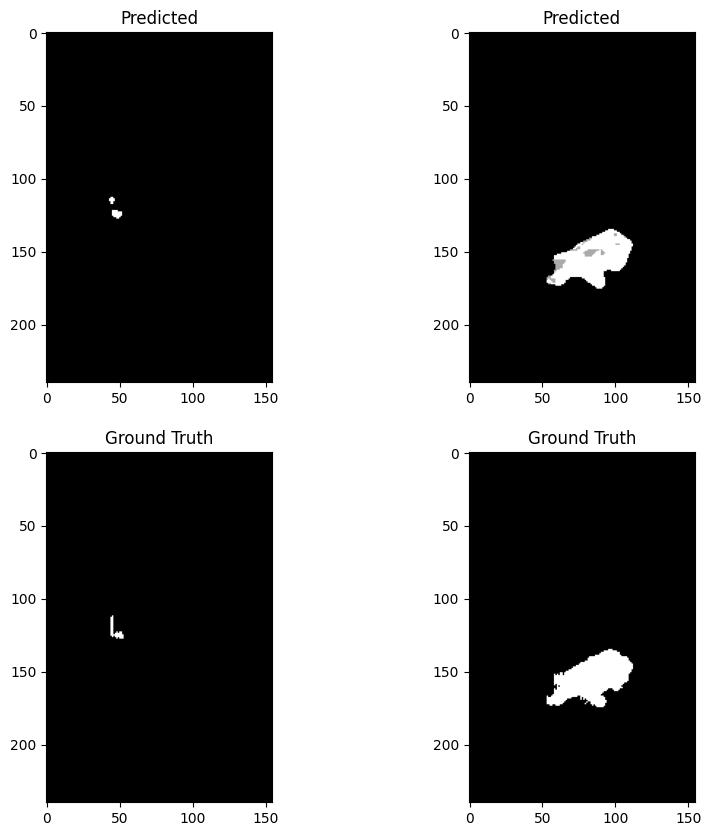

100%|██████████| 246/246 [08:45<00:00,  2.13s/it]



Average Training Loss: 0.010365806707385473

Average Training DSC: [0.99884533 0.8794704  0.92182231 0.77687011]
Average Training ASSD: [ 0.10665926 16.91304973 13.50413187 15.33994254]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


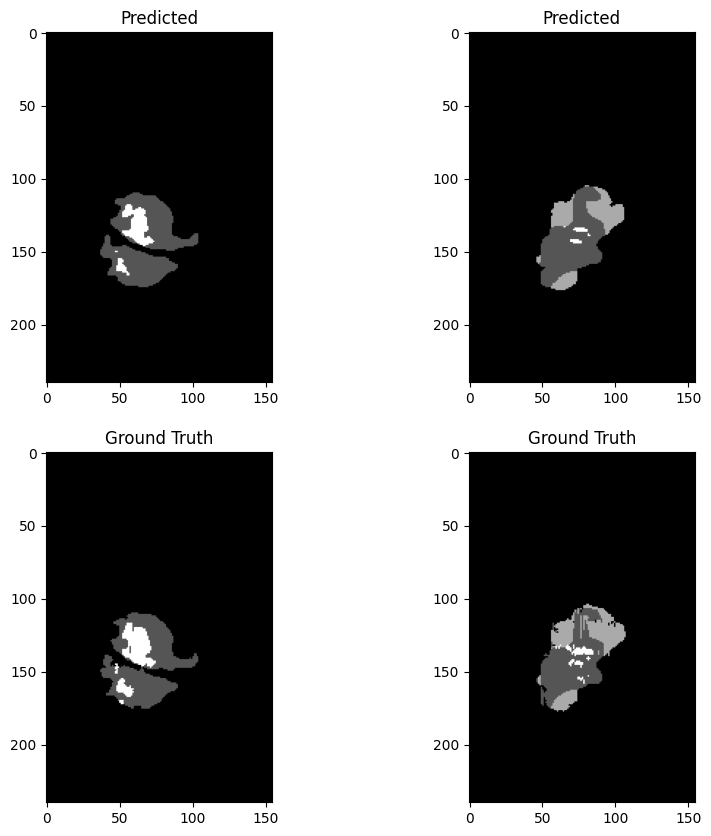

100%|██████████| 62/62 [01:34<00:00,  1.53s/it]


Average Validation Loss: 0.012721062359970904

Average Validation DSC: [0.99868467 0.87225428 0.91671328 0.70210258]
Average Validation ASSD: [ 0.13254719 15.1546221  12.72008952 26.2218403 ]
Epoch 26/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


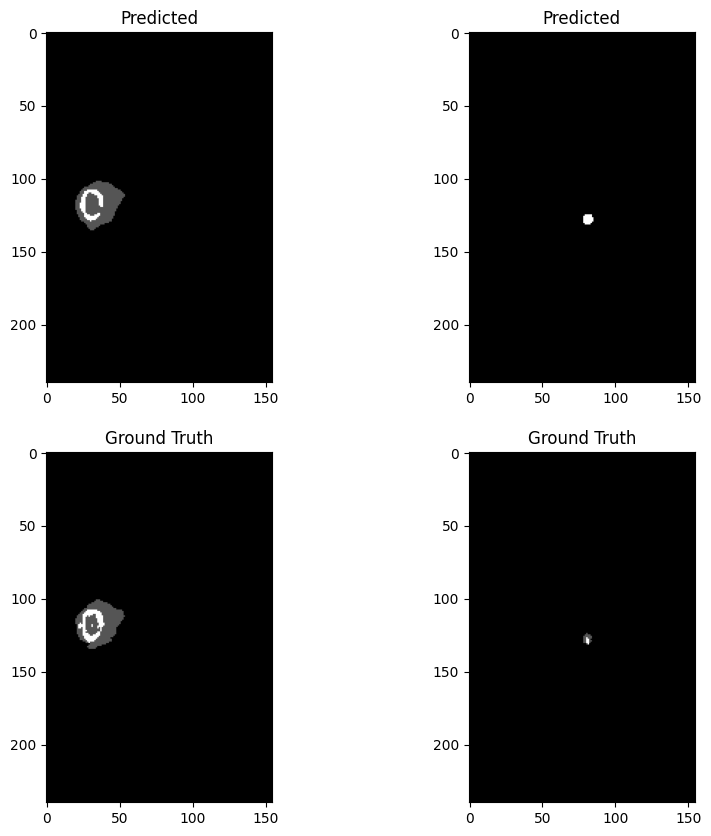

100%|██████████| 246/246 [08:46<00:00,  2.14s/it]



Average Training Loss: 0.010183007316285275

Average Training DSC: [0.99888379 0.88595355 0.91651034 0.7815572 ]
Average Training ASSD: [ 0.10522395 15.49568252 15.11248962 14.3425215 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


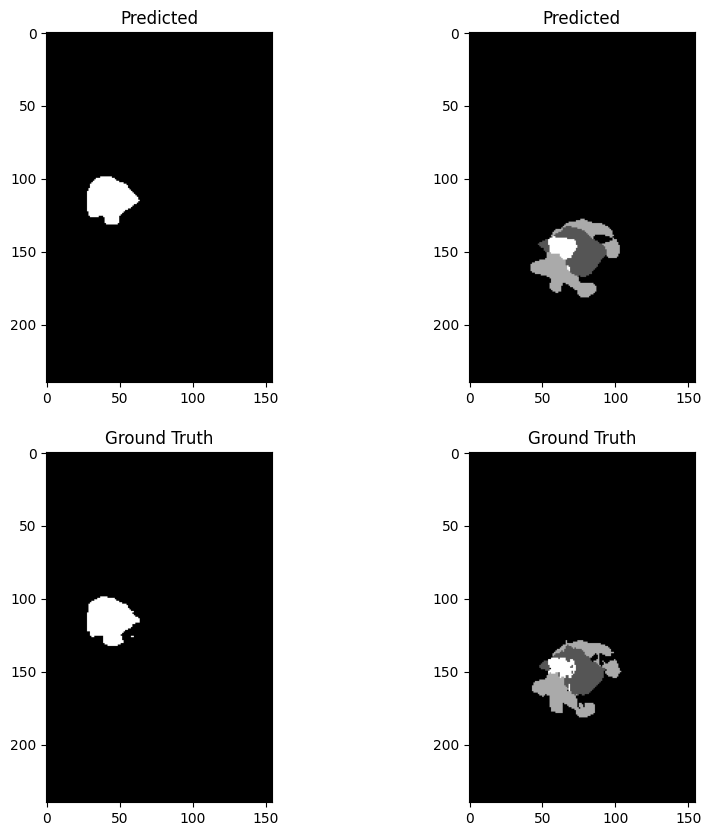

100%|██████████| 62/62 [01:44<00:00,  1.68s/it]


Average Validation Loss: 0.011026088223462143

Average Validation DSC: [0.99874798 0.85557833 0.91759316 0.76431225]
Average Validation ASSD: [ 0.12289358 23.85368083 12.45518996 14.91153503]
Epoch 27/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


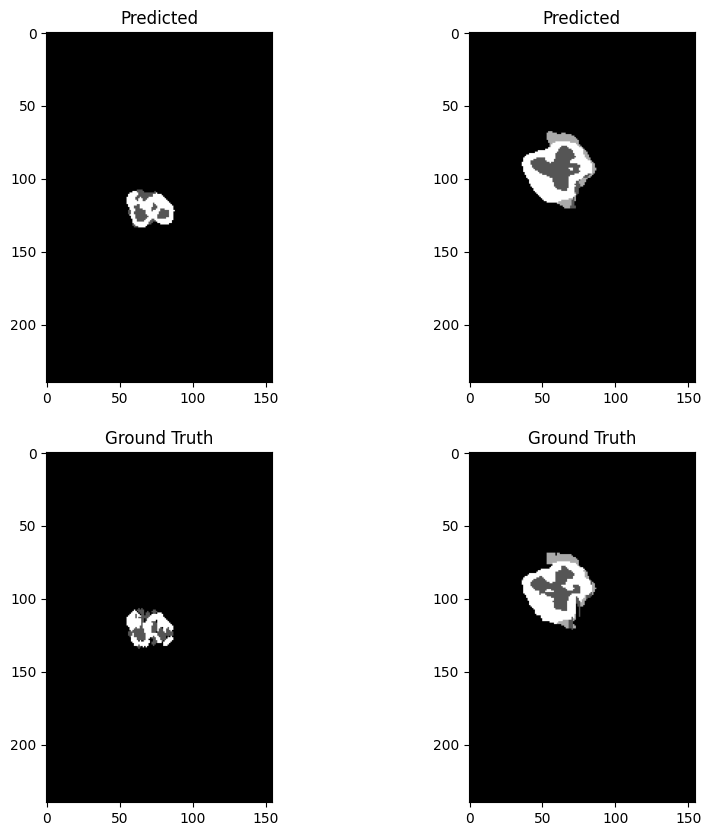

100%|██████████| 246/246 [08:41<00:00,  2.12s/it]



Average Training Loss: 0.009240026890519795

Average Training DSC: [0.99896202 0.89063758 0.93015603 0.79542395]
Average Training ASSD: [ 0.0967512  15.63607359 11.34442501 13.51529229]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


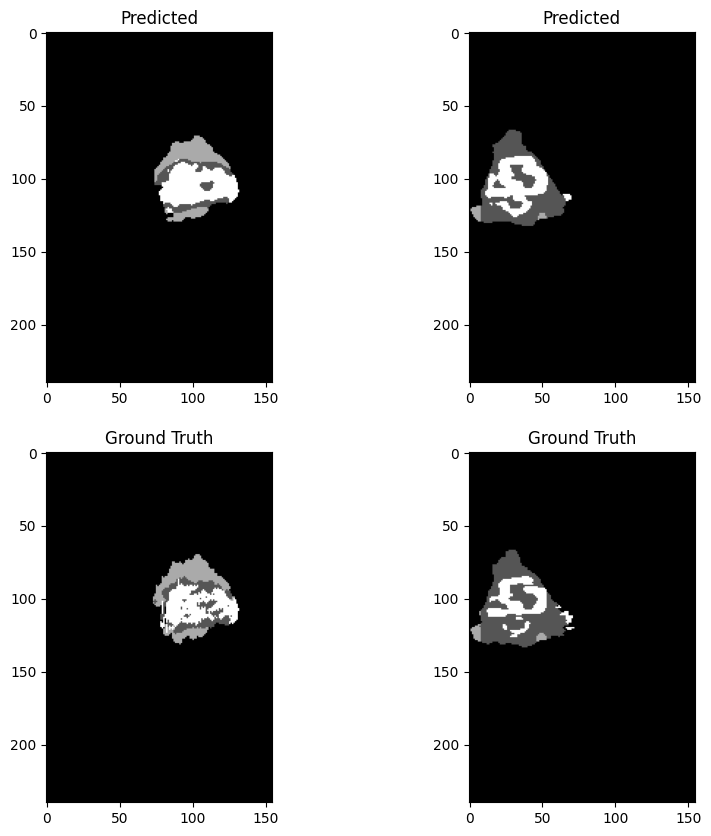

100%|██████████| 62/62 [01:36<00:00,  1.55s/it]


Average Validation Loss: 0.014237848891606253

Average Validation DSC: [0.99819842 0.86129815 0.91887571 0.74020006]
Average Validation ASSD: [ 0.19218896 13.0125375   9.11175376 17.29376869]
Epoch 28/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


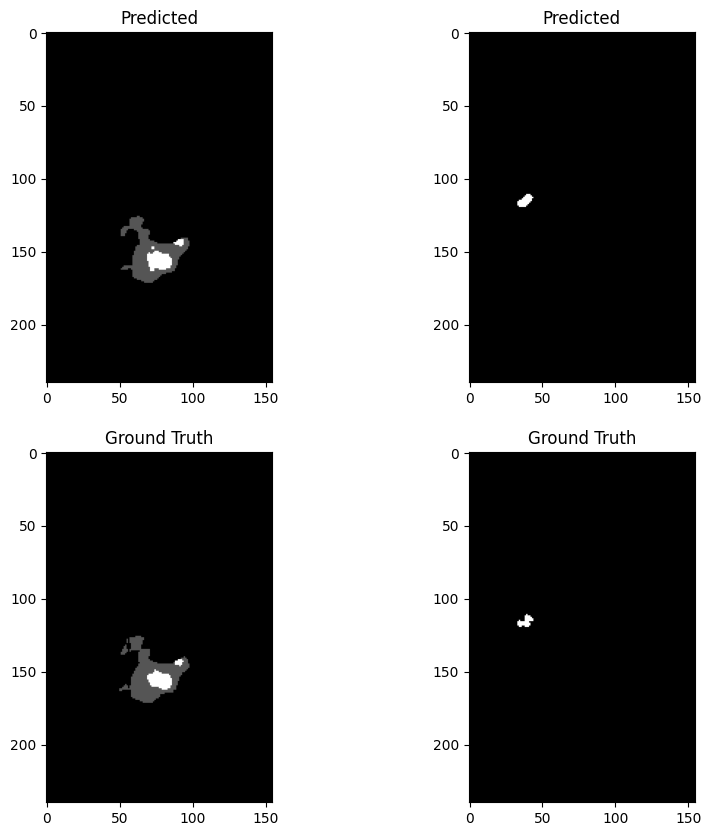

100%|██████████| 246/246 [08:38<00:00,  2.11s/it]



Average Training Loss: 0.008578158935865129

Average Training DSC: [0.99901912 0.89805126 0.93085224 0.8054047 ]
Average Training ASSD: [ 0.09141041 13.83403713 11.74724178 13.3581382 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


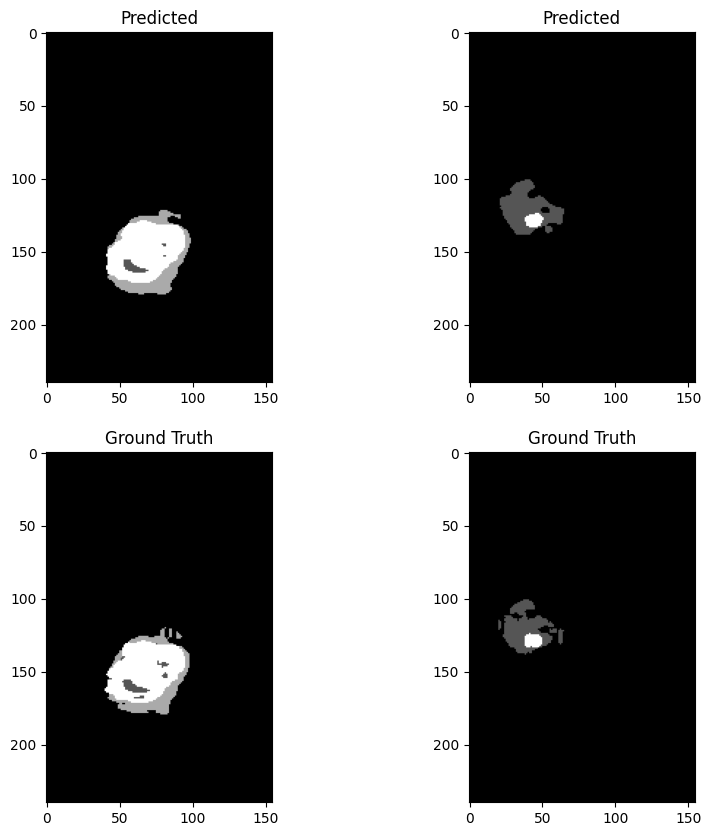

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.010351062489433153

Average Validation DSC: [0.99881875 0.85862001 0.91006385 0.79354313]
Average Validation ASSD: [ 0.11482948 23.58822049 14.19865554 10.26466474]
Epoch 29/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


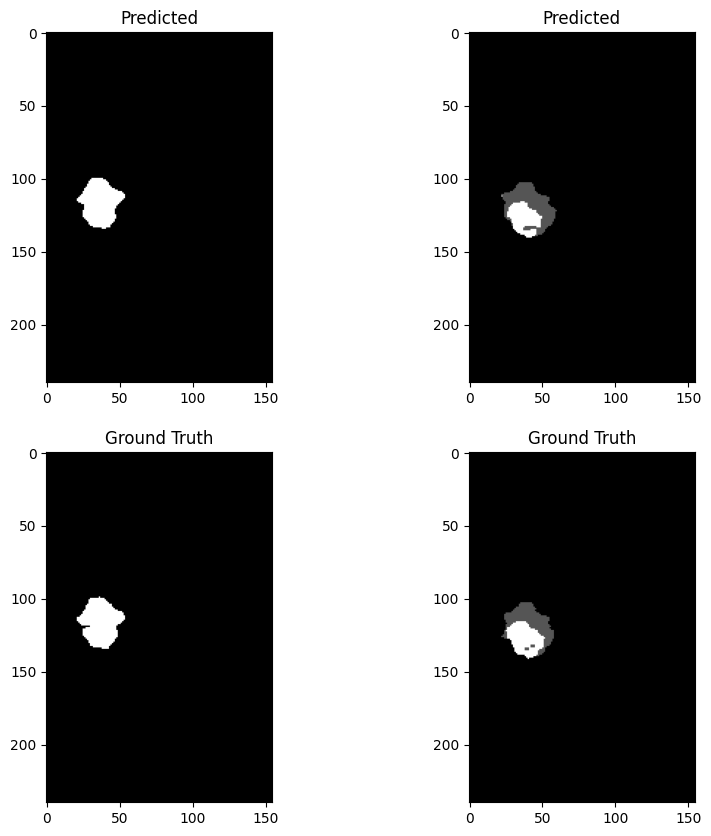

100%|██████████| 246/246 [08:32<00:00,  2.08s/it]



Average Training Loss: 0.009369162494331841

Average Training DSC: [0.99894528 0.88672505 0.92339464 0.79338344]
Average Training ASSD: [ 0.10108523 16.20980236 13.22819091 13.29556132]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


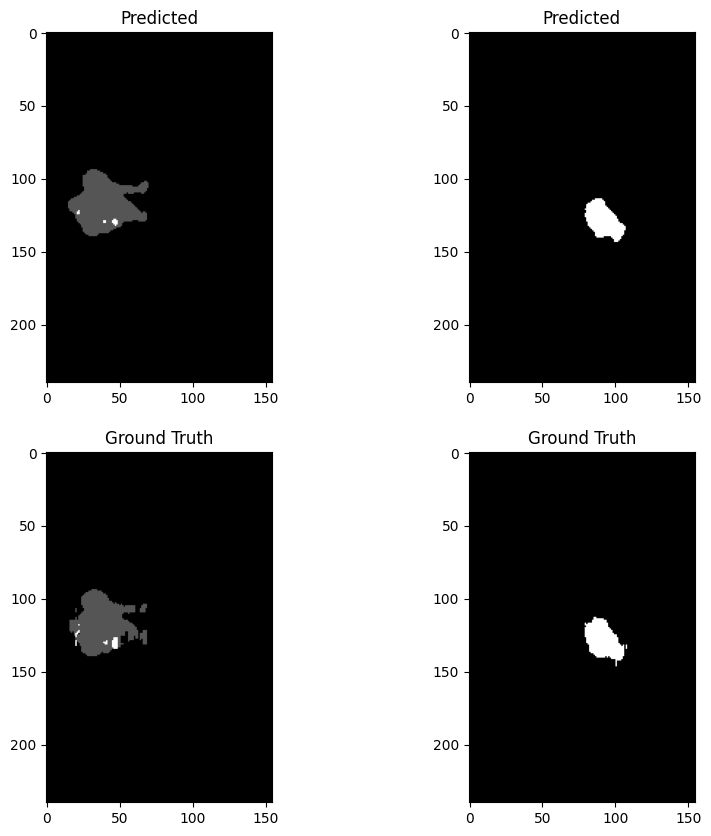

100%|██████████| 62/62 [01:35<00:00,  1.54s/it]


Average Validation Loss: 0.011611086706961355

Average Validation DSC: [0.99864274 0.84863551 0.8863779  0.77162016]
Average Validation ASSD: [ 0.17075438 25.5974262  22.73072391 11.50063531]
Epoch 30/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


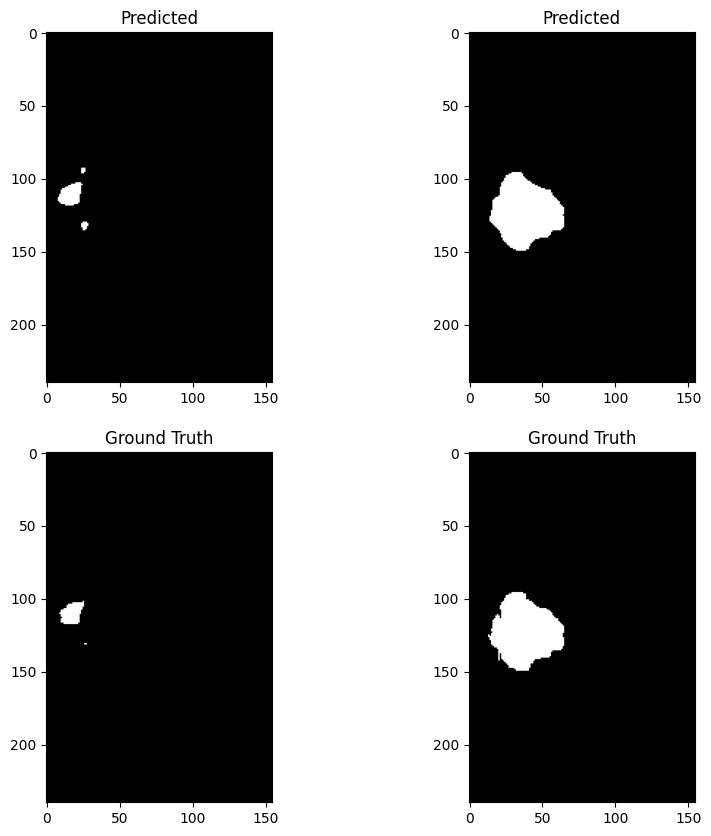

100%|██████████| 246/246 [08:31<00:00,  2.08s/it]



Average Training Loss: 0.008382381687728249

Average Training DSC: [0.99902429 0.90228014 0.93349369 0.80822641]
Average Training ASSD: [ 0.09161745 12.34934878 11.17622322 13.13820033]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


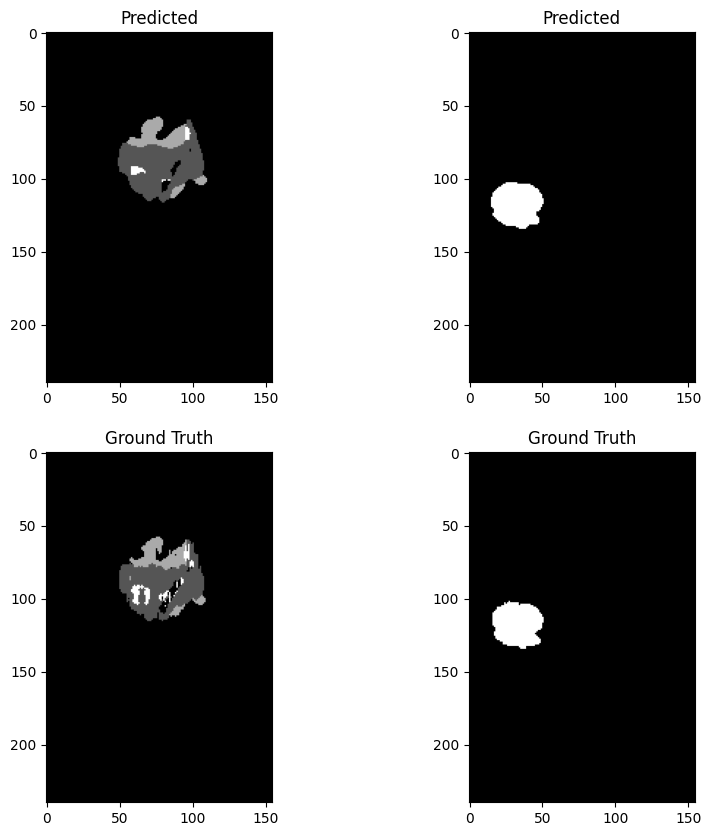

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.01040822100795565

Average Validation DSC: [0.99884861 0.87274896 0.92006378 0.76317657]
Average Validation ASSD: [ 0.11496331 19.89821624 12.70423802 20.26004699]
Epoch 31/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


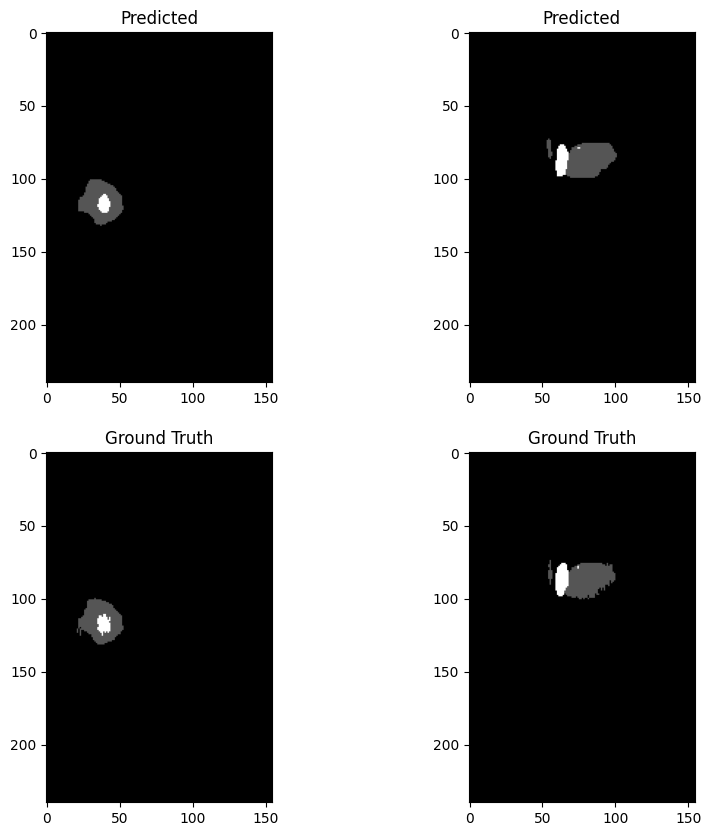

100%|██████████| 246/246 [08:36<00:00,  2.10s/it]



Average Training Loss: 0.008982899027111812

Average Training DSC: [0.99901682 0.88372776 0.93150518 0.79987757]
Average Training ASSD: [ 0.09158337 17.77721729 11.84999023 12.66875458]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


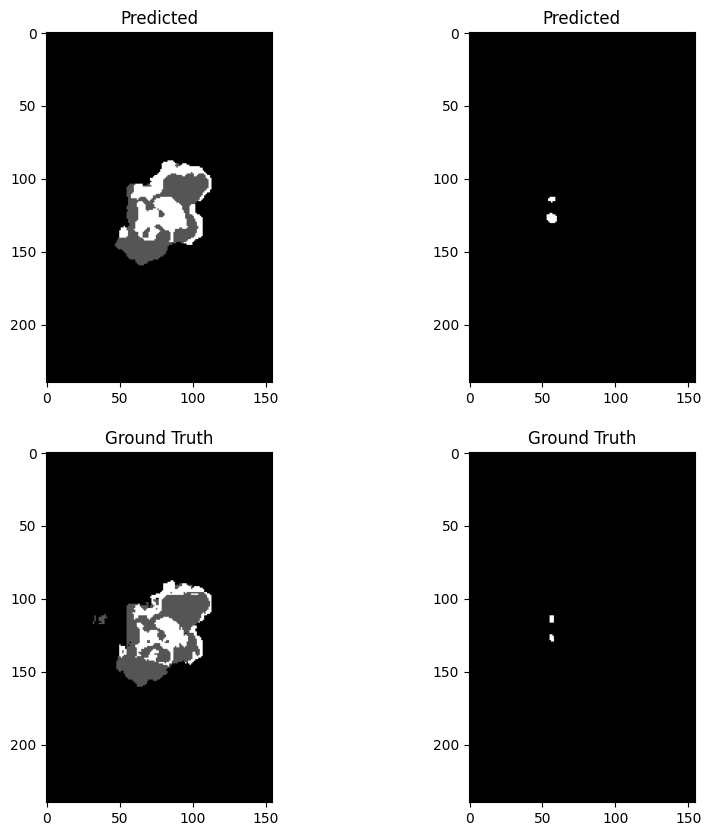

100%|██████████| 62/62 [01:33<00:00,  1.52s/it]


Average Validation Loss: 0.013032933366635153

Average Validation DSC: [0.99865684 0.84655079 0.90514571 0.77591914]
Average Validation ASSD: [ 0.12639703 14.54051177 15.17295836  7.1497531 ]
Epoch 32/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


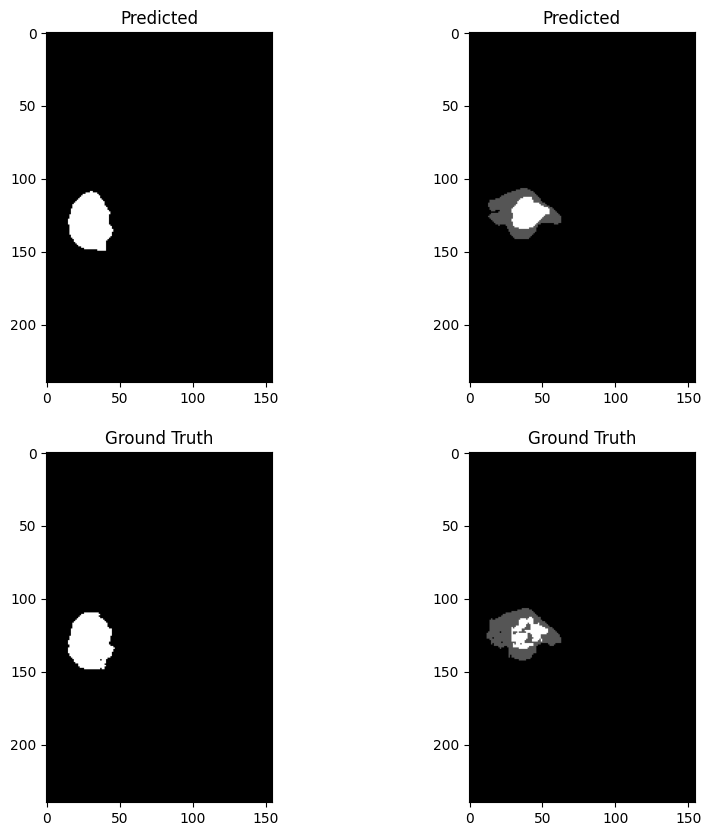

100%|██████████| 246/246 [08:36<00:00,  2.10s/it]



Average Training Loss: 0.008332680180153953

Average Training DSC: [0.99907076 0.90213901 0.93096285 0.81065878]
Average Training ASSD: [ 0.08651491 12.77514638 11.99711689 12.85716857]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


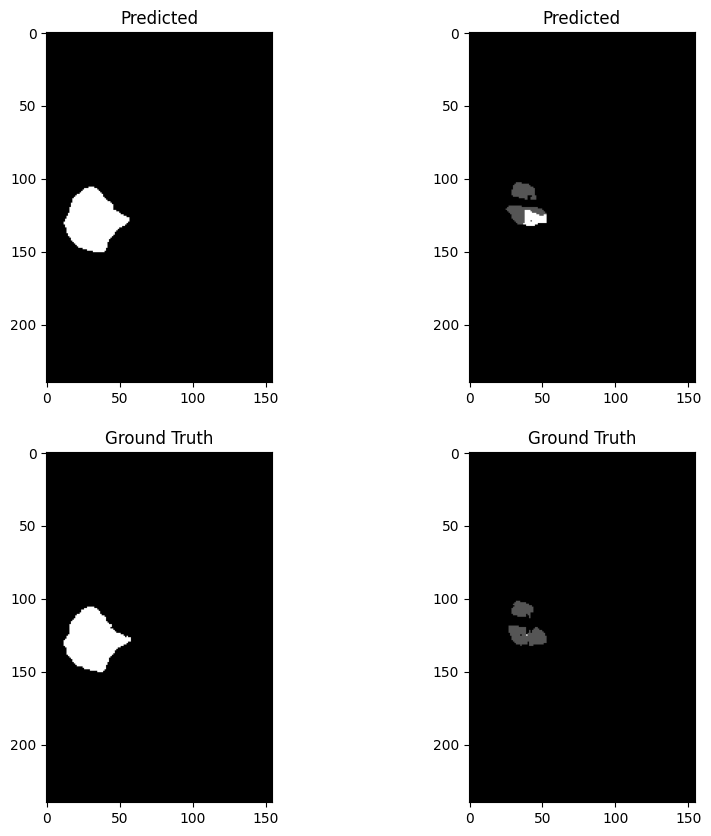

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.011561319209455002

Average Validation DSC: [0.99882134 0.86718748 0.9246053  0.79394133]
Average Validation ASSD: [ 0.11219161 12.50969465  9.29897815  5.93928416]
Epoch 33/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


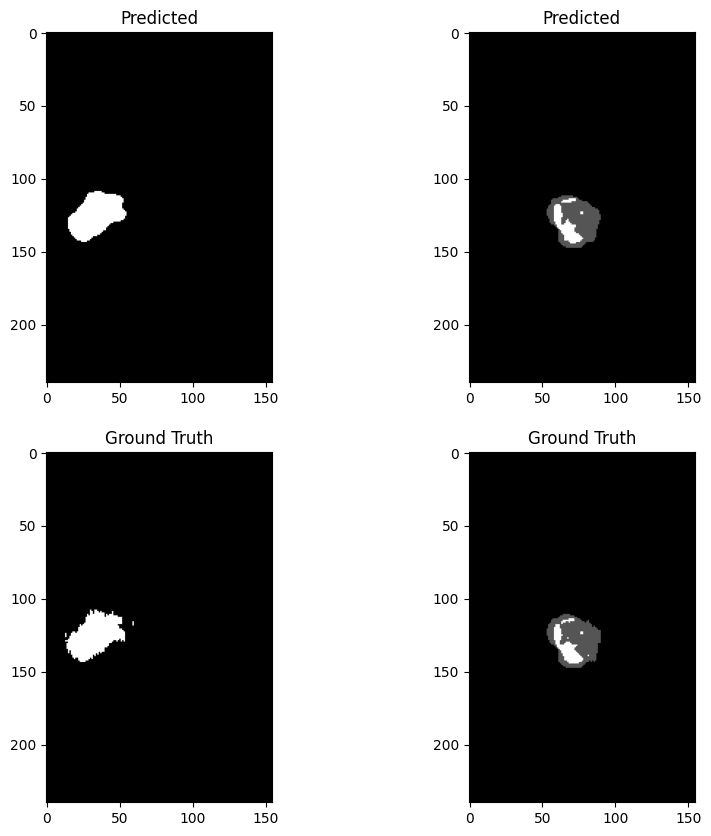

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.0073348885246862965

Average Training DSC: [0.99914754 0.91152006 0.93940664 0.82603254]
Average Training ASSD: [ 0.07967859 11.44729792 10.18546875 11.2539322 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


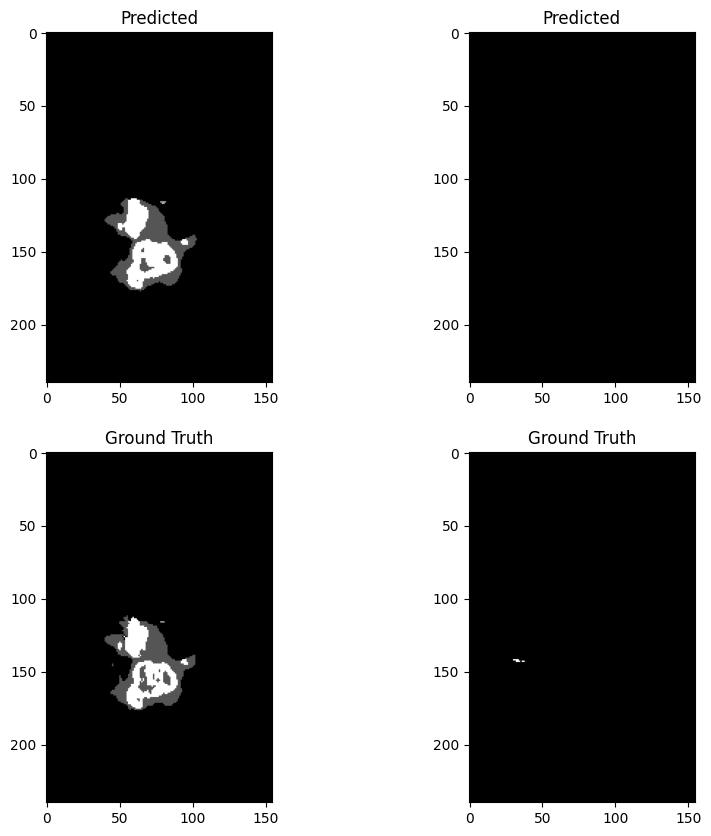

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.0087964441852584

Average Validation DSC: [0.99896315 0.90678352 0.93543898 0.81955722]
Average Validation ASSD: [ 0.09365719 10.84598173  8.03037347  8.76896026]
Epoch 34/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


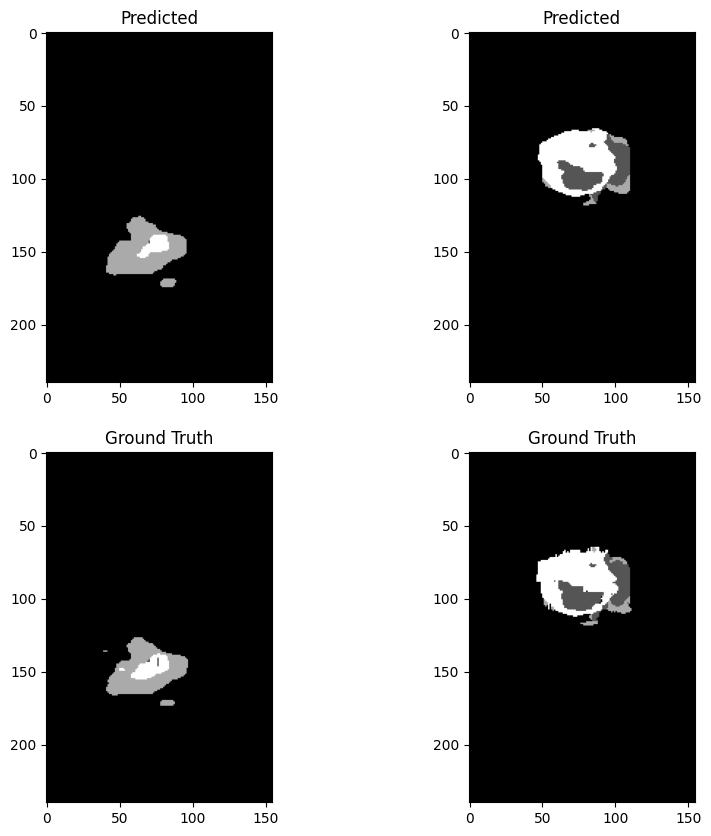

100%|██████████| 246/246 [08:42<00:00,  2.13s/it]



Average Training Loss: 0.008153884745452826

Average Training DSC: [0.99907704 0.89809999 0.93596206 0.81567715]
Average Training ASSD: [ 0.08713708 14.54017889 10.58752788 11.34441498]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


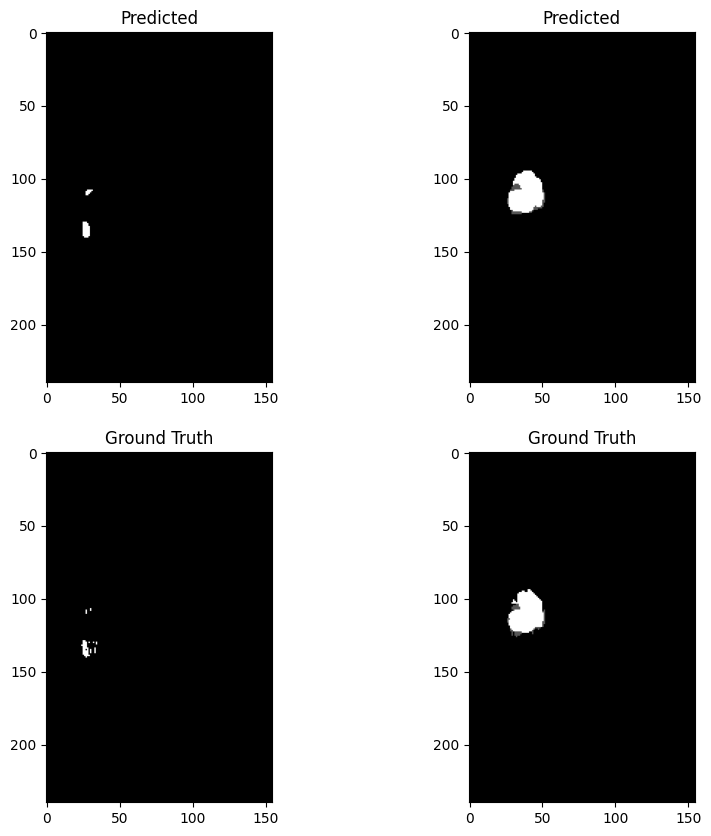

100%|██████████| 62/62 [01:37<00:00,  1.57s/it]


Average Validation Loss: 0.012676488142460585

Average Validation DSC: [0.99877819 0.86125317 0.90888075 0.73276467]
Average Validation ASSD: [ 0.11227572 17.38697915 13.52356347 16.0313725 ]
Epoch 35/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


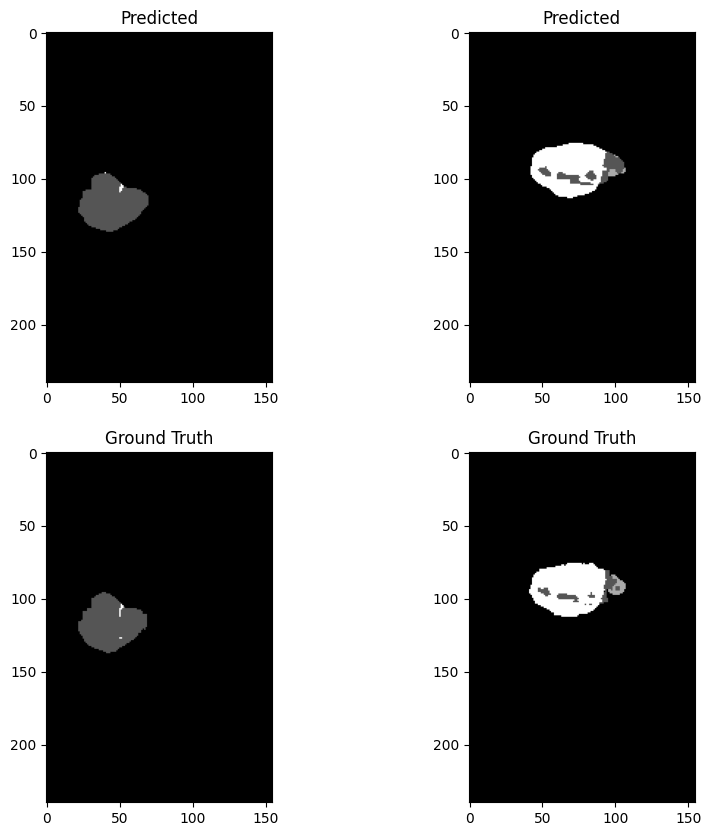

100%|██████████| 246/246 [08:38<00:00,  2.11s/it]



Average Training Loss: 0.007362894908850634

Average Training DSC: [0.99916618 0.91033439 0.93824029 0.82629941]
Average Training ASSD: [ 0.07841612 11.57581132 10.39539271 12.11713403]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


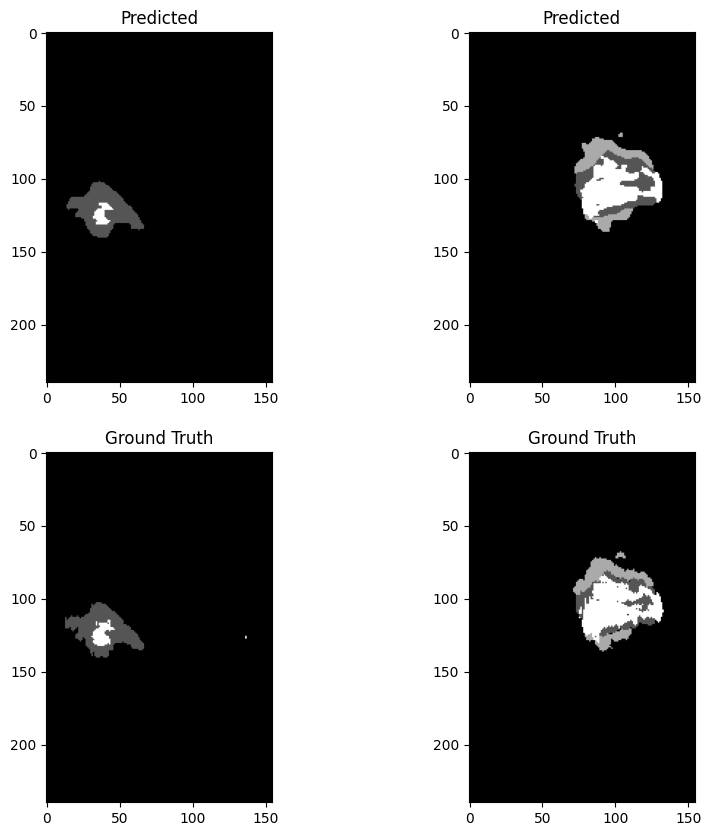

100%|██████████| 62/62 [01:35<00:00,  1.54s/it]


Average Validation Loss: 0.009966162461487035

Average Validation DSC: [0.99892442 0.86533312 0.92971786 0.78623523]
Average Validation ASSD: [ 0.10213579 23.29050146  9.97925602 11.26558436]
Epoch 36/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


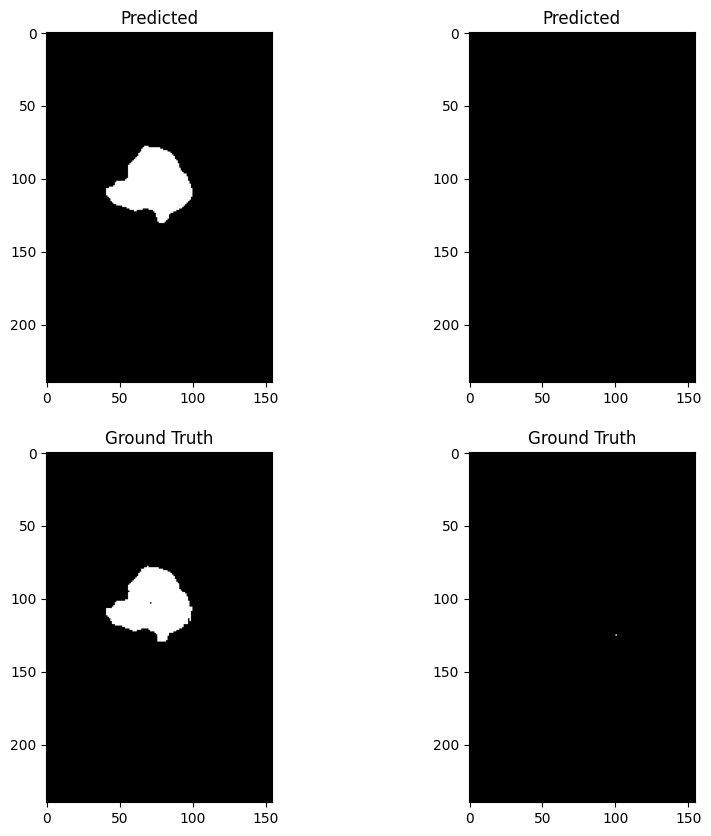

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.007591898119591964

Average Training DSC: [0.99912583 0.91054088 0.93763653 0.82413706]
Average Training ASSD: [ 0.08206415 11.99154901 10.62130221 11.84833568]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


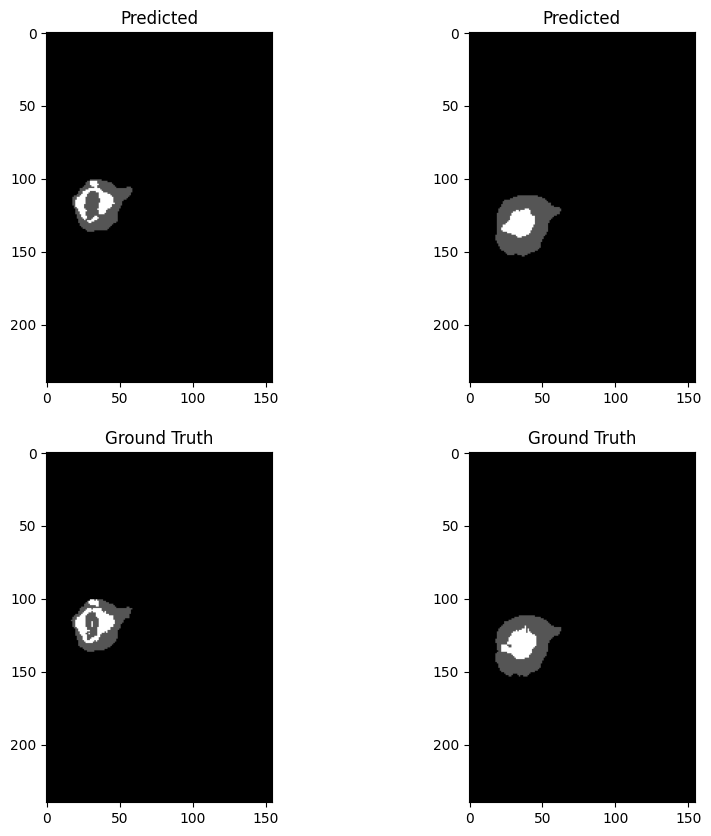

100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Average Validation Loss: 0.00909046275210717

Average Validation DSC: [0.99902448 0.89705541 0.93727626 0.79704473]
Average Validation ASSD: [ 0.09791105 14.24761961  7.28910038 15.32695299]
Epoch 37/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


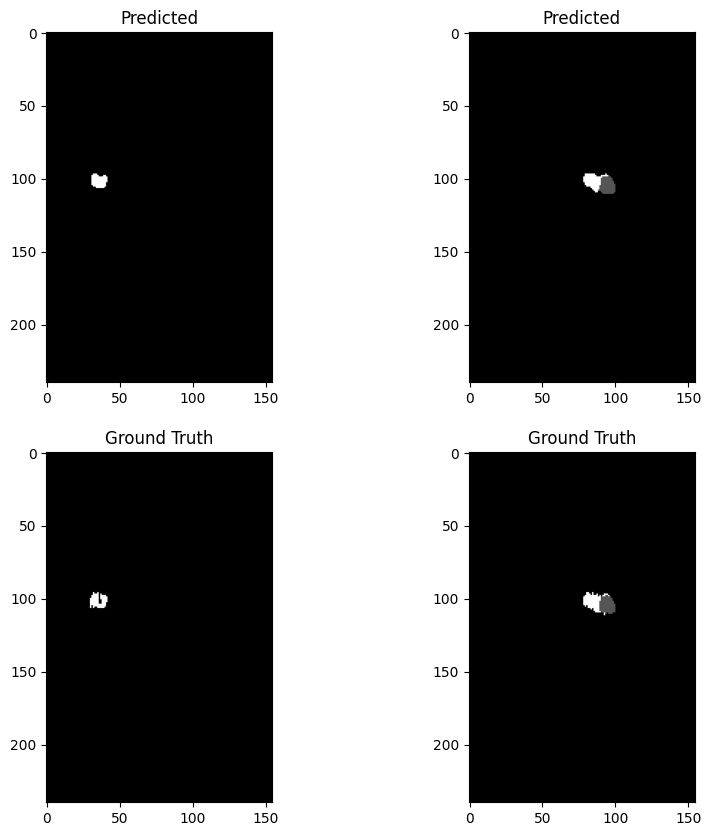

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.006945393881116941

Average Training DSC: [0.99920958 0.9147488  0.94324139 0.8343551 ]
Average Training ASSD: [ 0.07329578 10.94292826  9.38662017 11.25454722]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


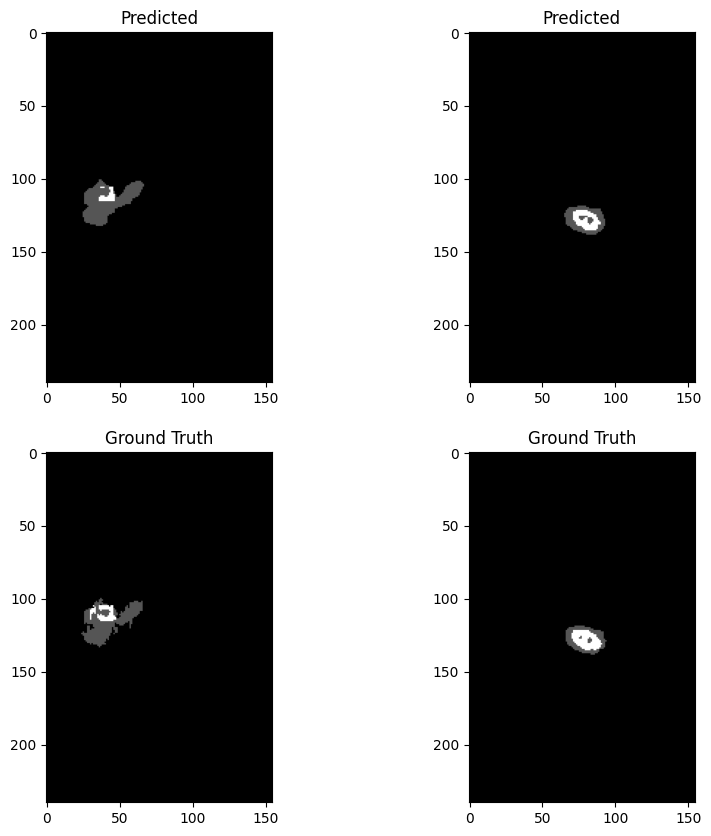

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.00862130287644123

Average Validation DSC: [0.99900607 0.89318641 0.93490232 0.80843481]
Average Validation ASSD: [ 0.09586824 16.19876215  9.21812619 13.65042674]
Epoch 38/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


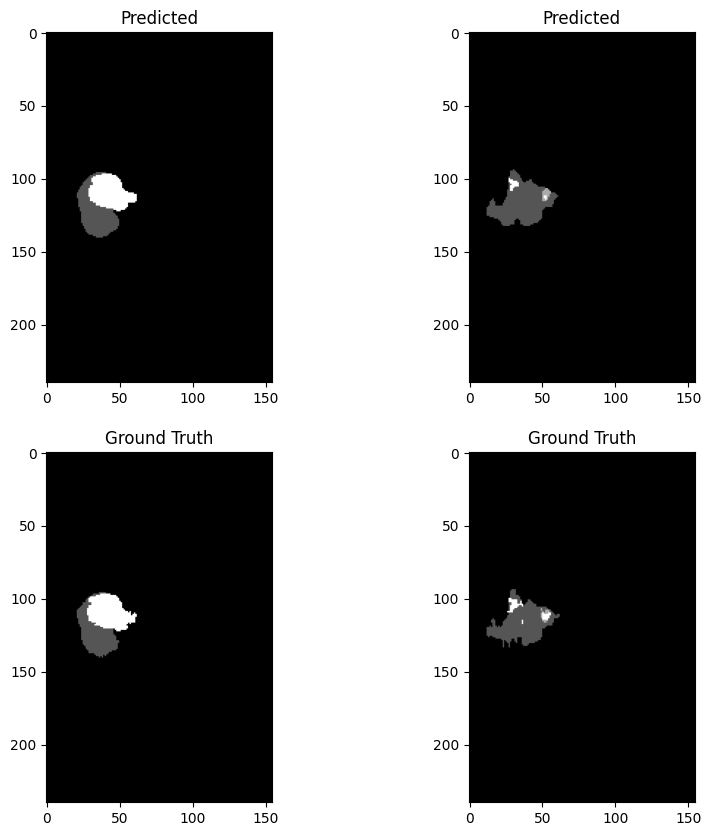

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.006448062028872167

Average Training DSC: [0.99924703 0.92464468 0.9456863  0.84030371]
Average Training ASSD: [ 0.06775046  8.64212622  8.90271623 10.52446503]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


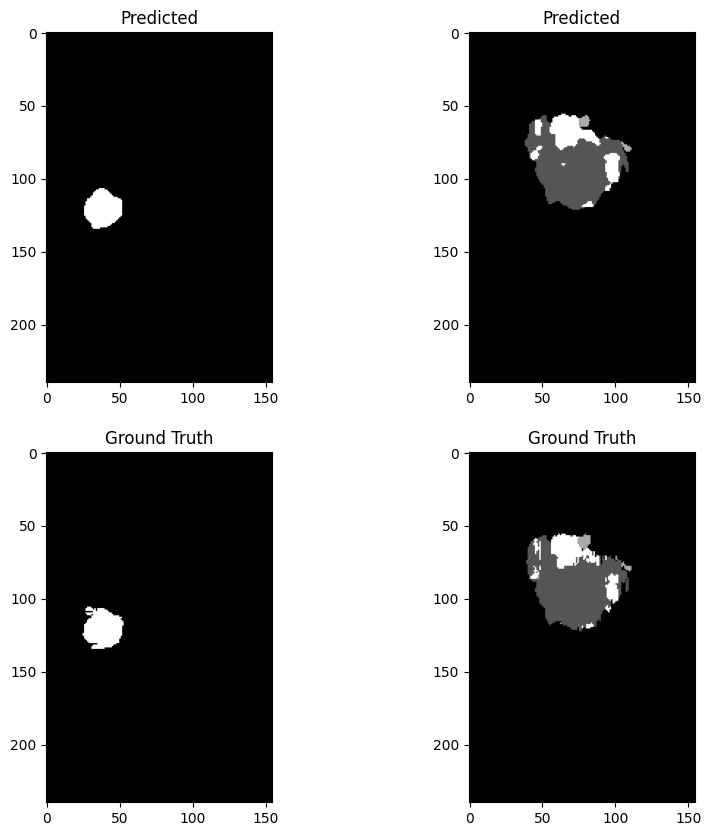

100%|██████████| 62/62 [01:31<00:00,  1.48s/it]


Average Validation Loss: 0.009693352625735344

Average Validation DSC: [0.99901923 0.89649457 0.93605011 0.80411813]
Average Validation ASSD: [0.09458518 7.77331544 6.15447589 6.55210954]
Epoch 39/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


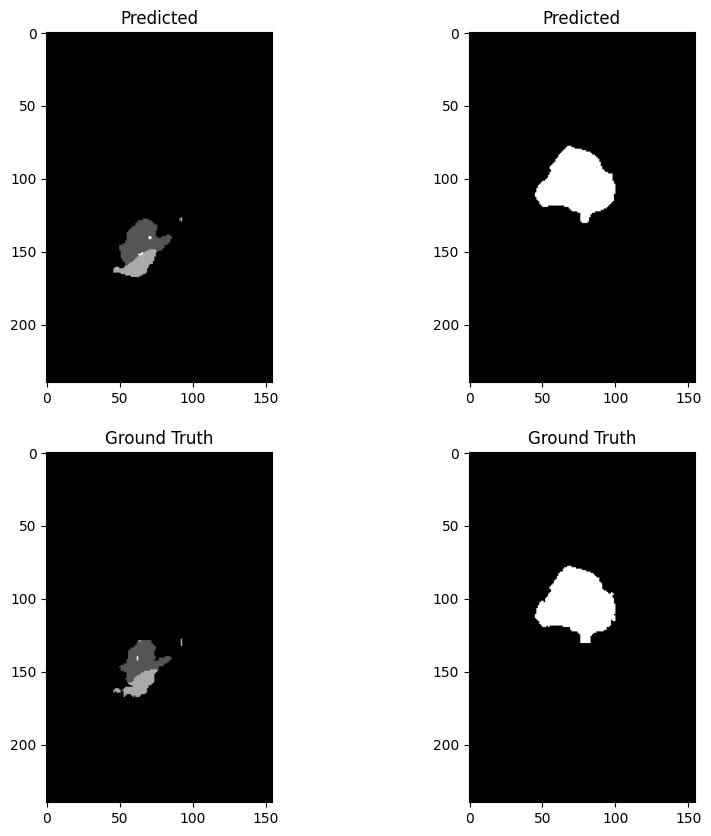

100%|██████████| 246/246 [08:40<00:00,  2.11s/it]



Average Training Loss: 0.006134846719072723

Average Training DSC: [0.99927709 0.92722724 0.94702556 0.84609732]
Average Training ASSD: [ 0.06703473  8.80978423  8.57779039 11.20345899]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


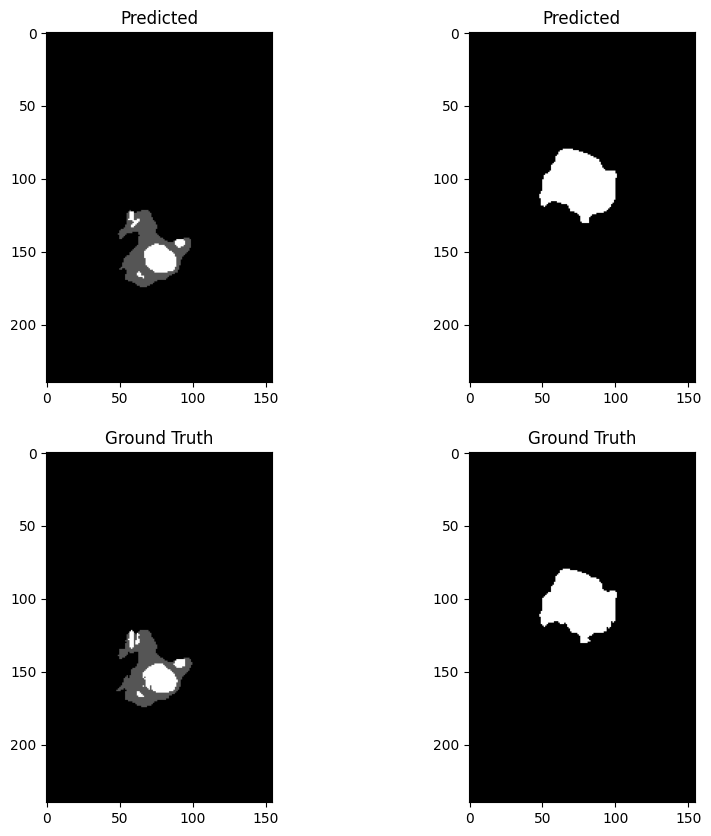

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.008121439473583333

Average Validation DSC: [0.99912847 0.91869337 0.94018208 0.83144043]
Average Validation ASSD: [0.0811926  7.41076772 7.53911108 9.90649279]
Epoch 40/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


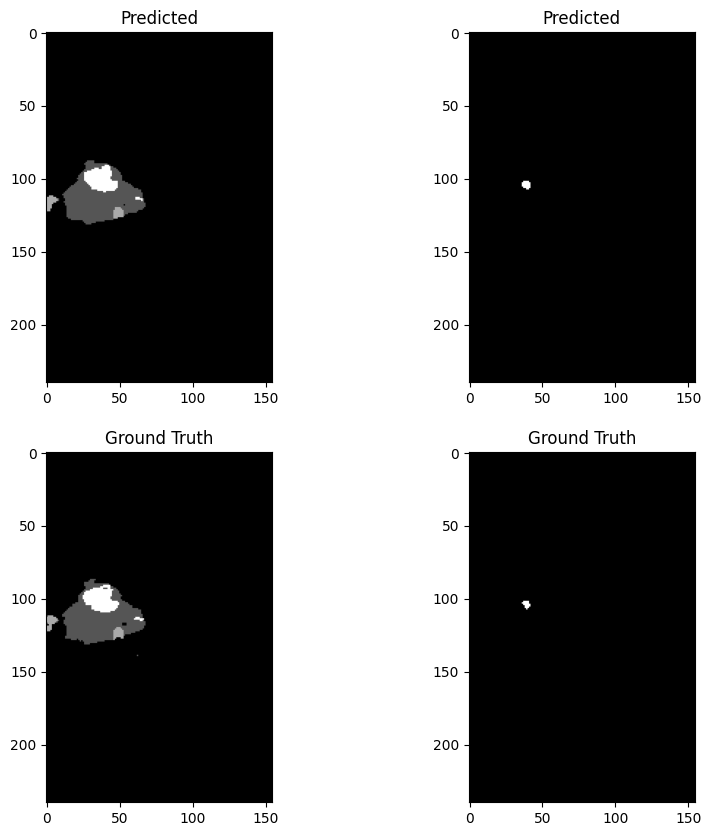

100%|██████████| 246/246 [08:30<00:00,  2.08s/it]



Average Training Loss: 0.006455381797452465

Average Training DSC: [0.99925494 0.92352051 0.94134748 0.84385552]
Average Training ASSD: [ 0.06787879  9.37619424 10.10362504 10.94361001]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


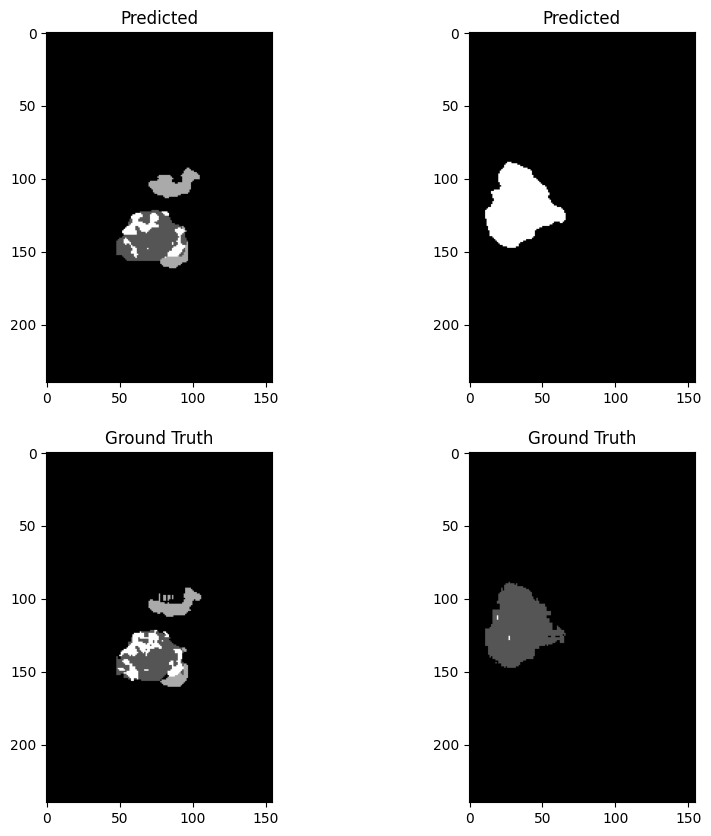

100%|██████████| 62/62 [01:31<00:00,  1.47s/it]


Average Validation Loss: 0.008258755070968501

Average Validation DSC: [0.99899112 0.91743483 0.93682918 0.82015646]
Average Validation ASSD: [0.09131109 8.39448176 8.25554226 9.68918887]
Epoch 41/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


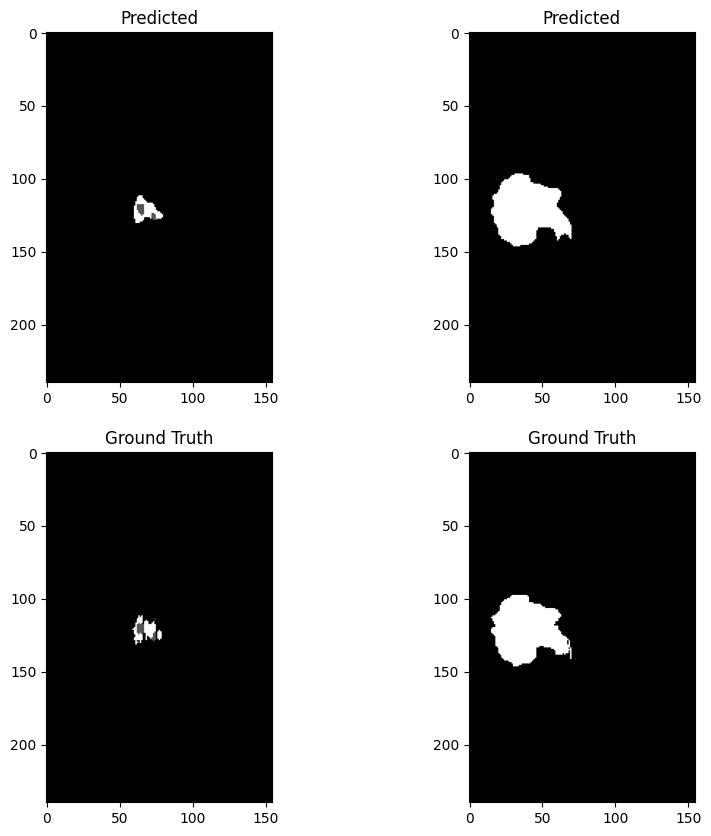

100%|██████████| 246/246 [08:35<00:00,  2.09s/it]



Average Training Loss: 0.0067802476810245975

Average Training DSC: [0.99920133 0.91343517 0.94458341 0.83813639]
Average Training ASSD: [ 0.07282162 12.20704958  9.02568366 11.11764743]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


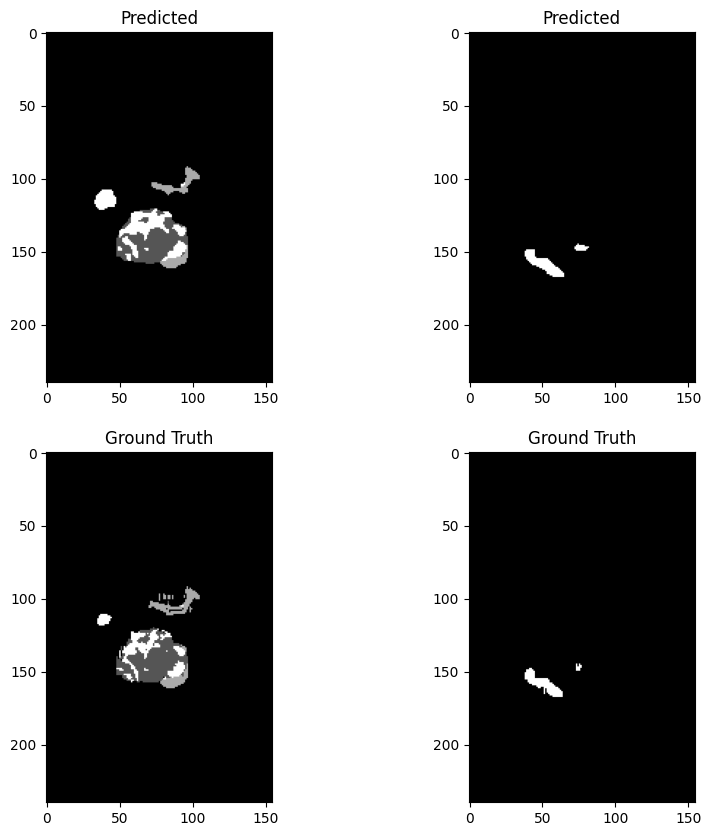

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.00806796555257132

Average Validation DSC: [0.99911435 0.91151686 0.94487771 0.83277869]
Average Validation ASSD: [0.08737749 9.85262646 5.08457319 8.01989861]
Epoch 42/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


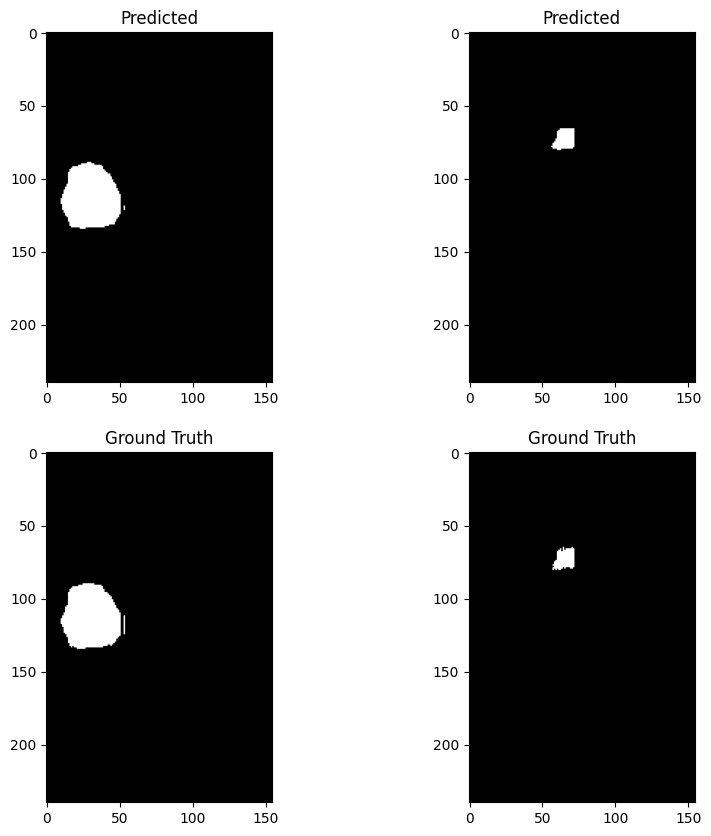

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.0065422949808975304

Average Training DSC: [0.9992626  0.92032256 0.94718469 0.84340702]
Average Training ASSD: [ 0.06931957 10.30445179  8.2760928  10.6909606 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


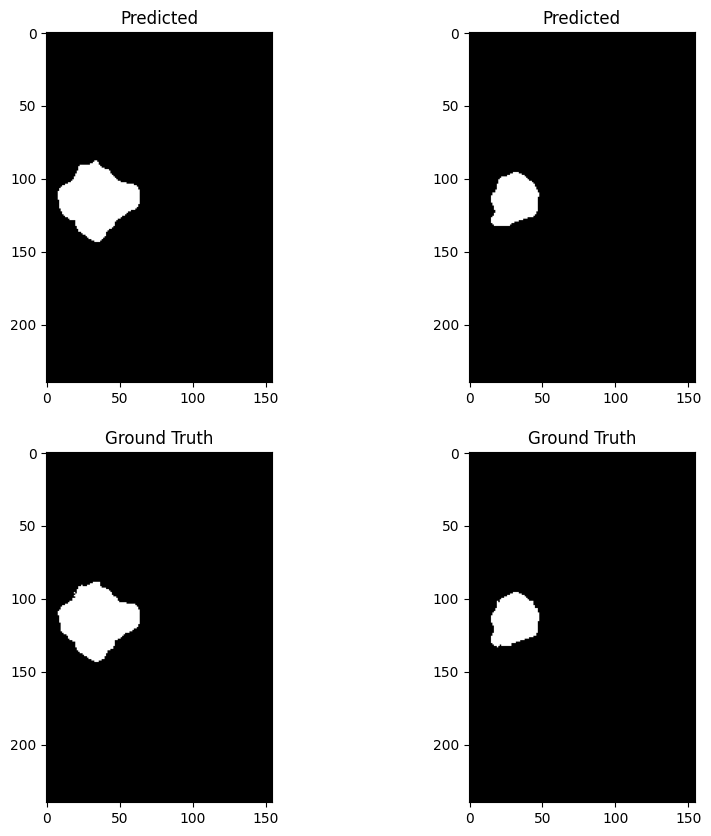

100%|██████████| 62/62 [01:31<00:00,  1.48s/it]


Average Validation Loss: 0.007854044955644396

Average Validation DSC: [0.99906206 0.90963962 0.93385317 0.83740107]
Average Validation ASSD: [ 0.0852047  10.82047765  9.24190984  7.00391654]
Epoch 43/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


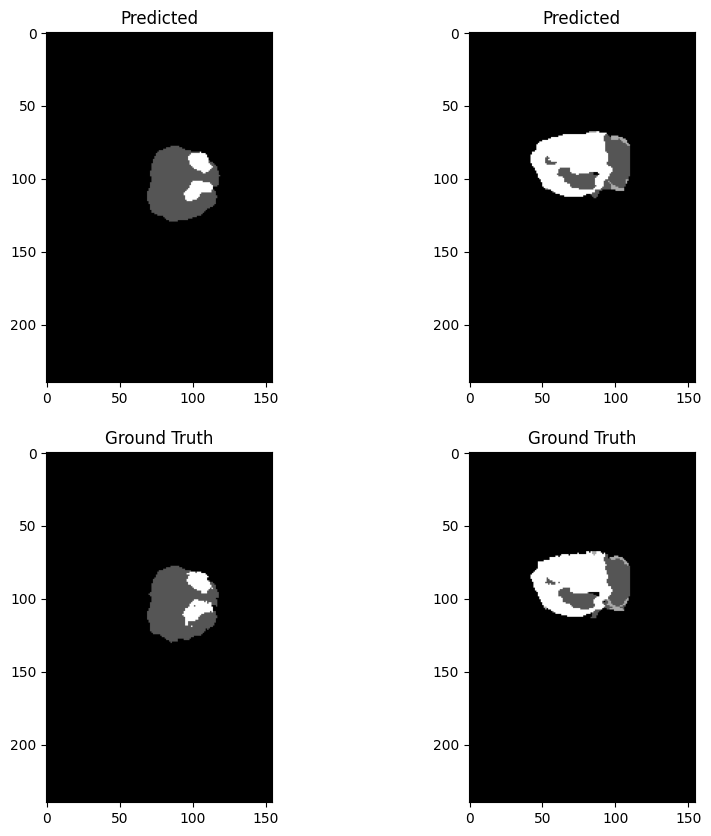

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.0060509412475611745

Average Training DSC: [0.99930954 0.92772725 0.9468704  0.84968954]
Average Training ASSD: [ 0.06330166  8.50158892  8.80316379 10.2628417 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


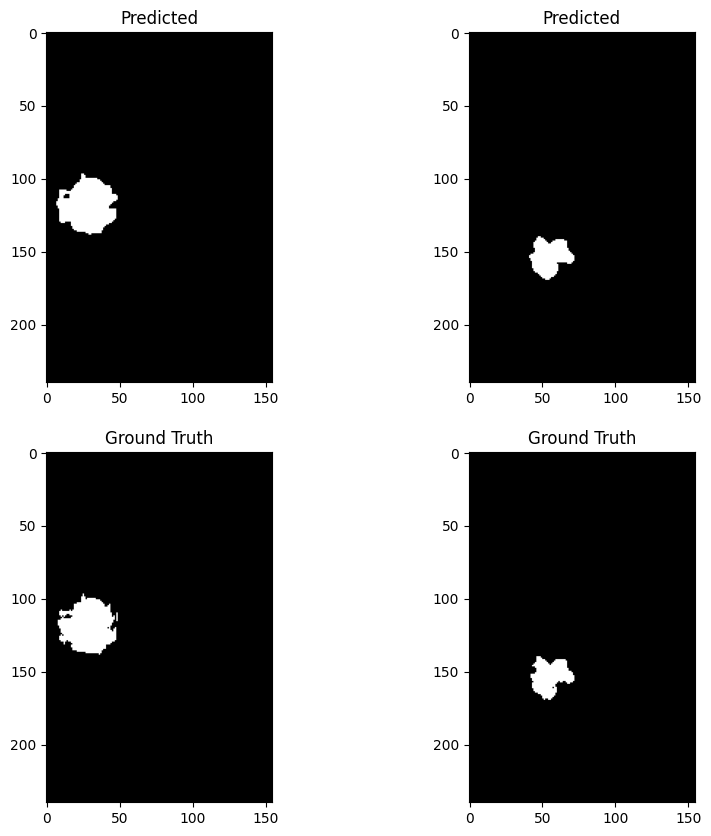

100%|██████████| 62/62 [01:34<00:00,  1.52s/it]


Average Validation Loss: 0.007630346425538582

Average Validation DSC: [0.99914985 0.91649474 0.93666741 0.8415752 ]
Average Validation ASSD: [0.0833701  8.13621078 7.28117766 8.24897796]
Epoch 44/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


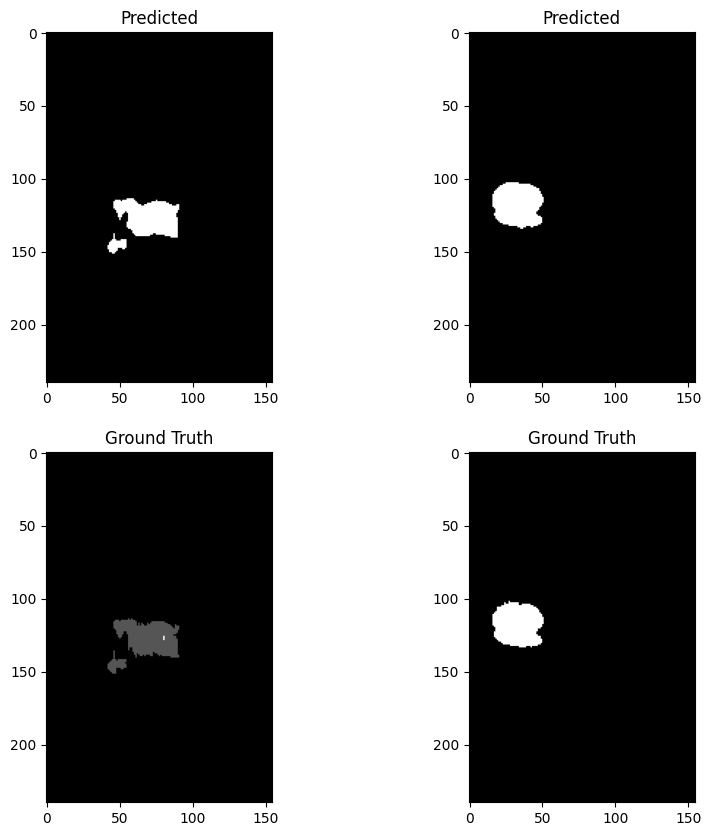

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.005804683184970503

Average Training DSC: [0.99933863 0.92717501 0.94803093 0.85610487]
Average Training ASSD: [ 0.06028641  9.23723426  8.46040368 11.20905529]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


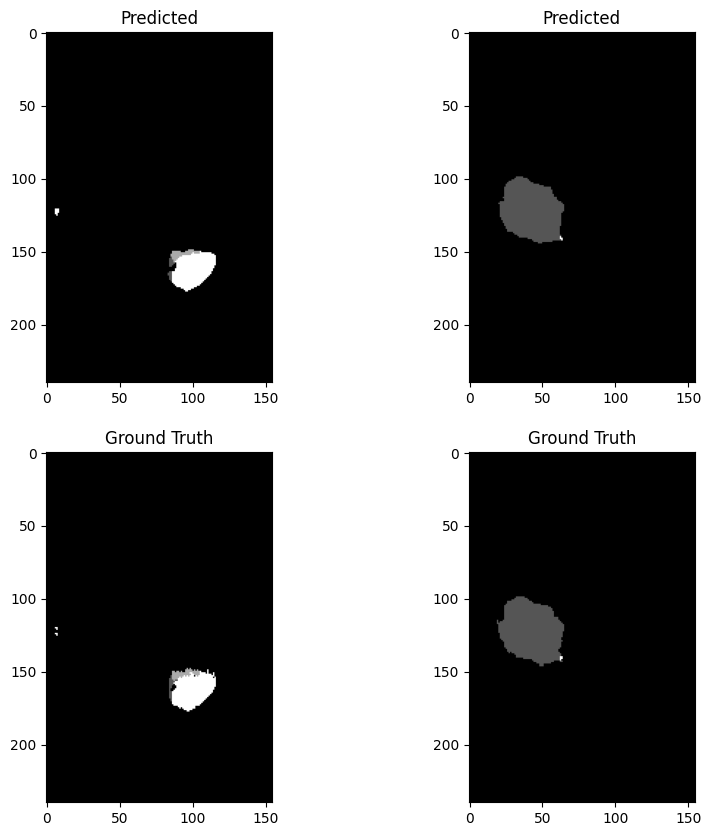

100%|██████████| 62/62 [01:28<00:00,  1.43s/it]


Average Validation Loss: 0.007773966626113941

Average Validation DSC: [0.99912876 0.9171108  0.93249492 0.83856583]
Average Validation ASSD: [ 0.0807167   8.59905355 11.40940881  9.37308174]
Epoch 45/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


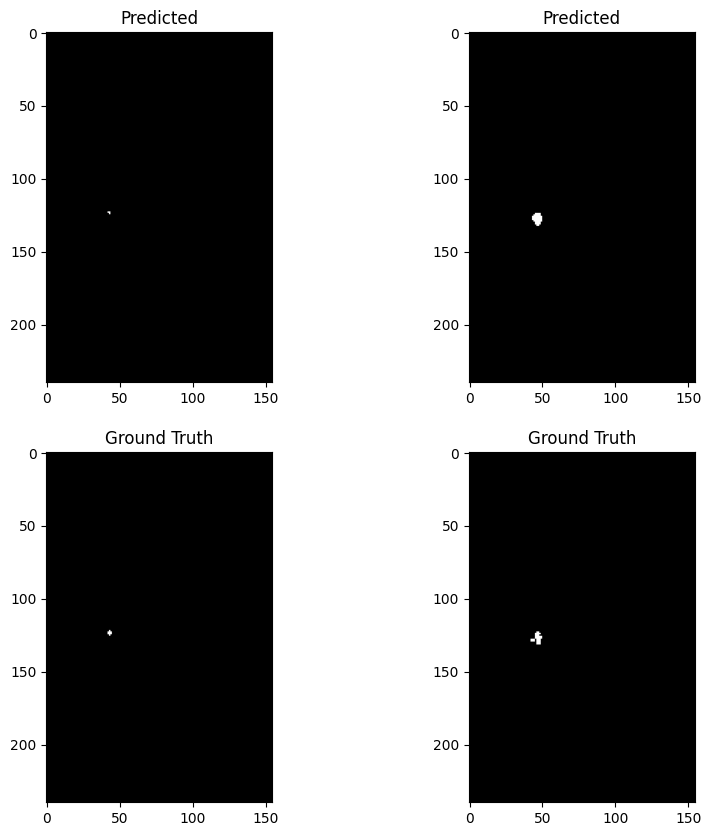

100%|██████████| 246/246 [08:35<00:00,  2.10s/it]



Average Training Loss: 0.0058904070969352995

Average Training DSC: [0.99932894 0.92884643 0.94649309 0.85537439]
Average Training ASSD: [ 0.06129119  8.85699048  9.00857167 11.20333896]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


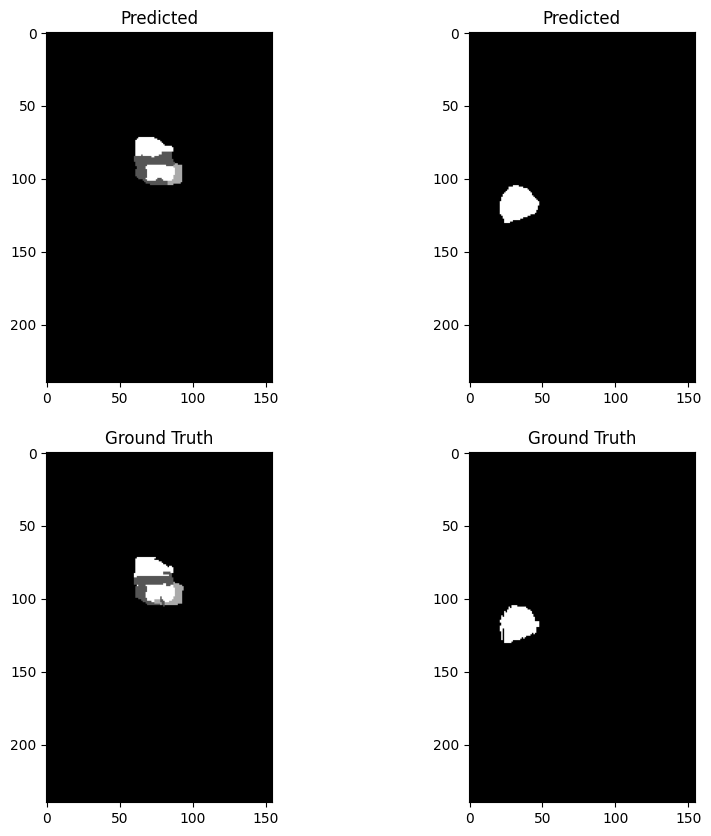

100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Average Validation Loss: 0.007473663509552998

Average Validation DSC: [0.99915095 0.90790472 0.94151067 0.83370217]
Average Validation ASSD: [ 0.08293387 12.97848823  7.96437442 11.04320138]
Epoch 46/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


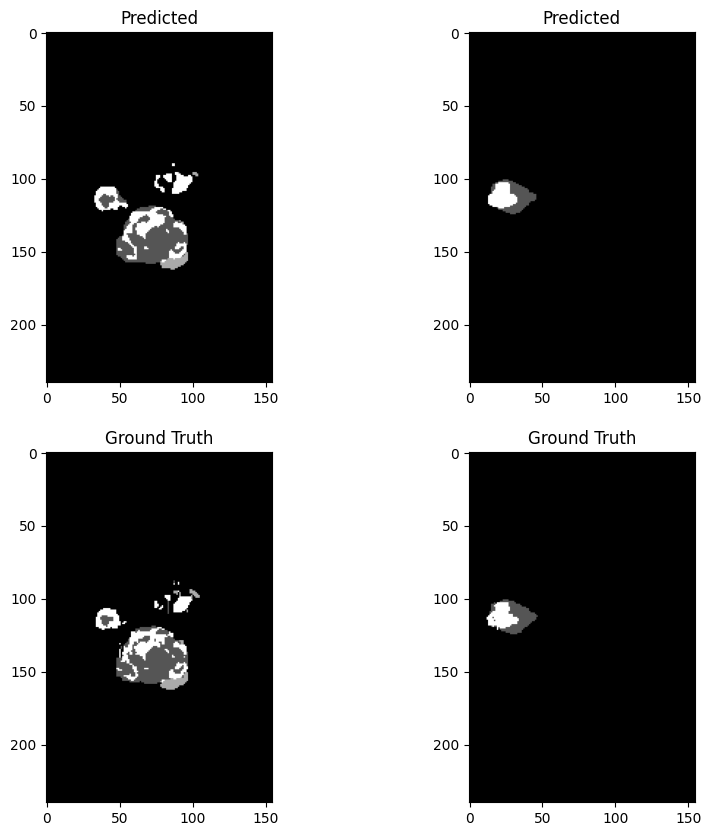

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.0054744989970865535

Average Training DSC: [0.99936429 0.93524662 0.95195615 0.86268391]
Average Training ASSD: [ 0.05670333  7.60811023  7.8162252  10.8748481 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


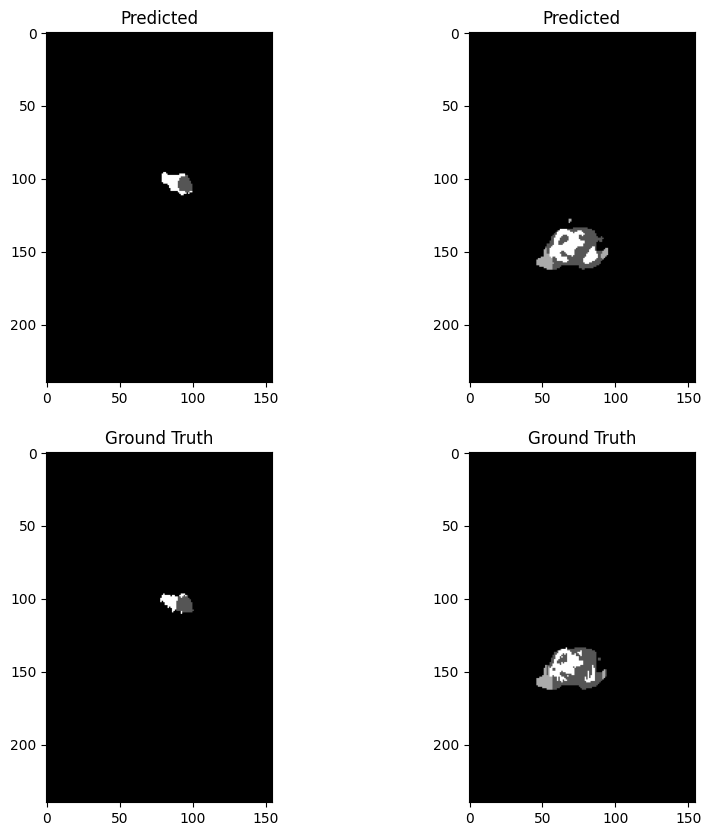

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.008248278330410681

Average Validation DSC: [0.99911984 0.90655493 0.93402136 0.83473263]
Average Validation ASSD: [ 0.0832744  10.58465746  9.26131281  6.57217896]
Epoch 47/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


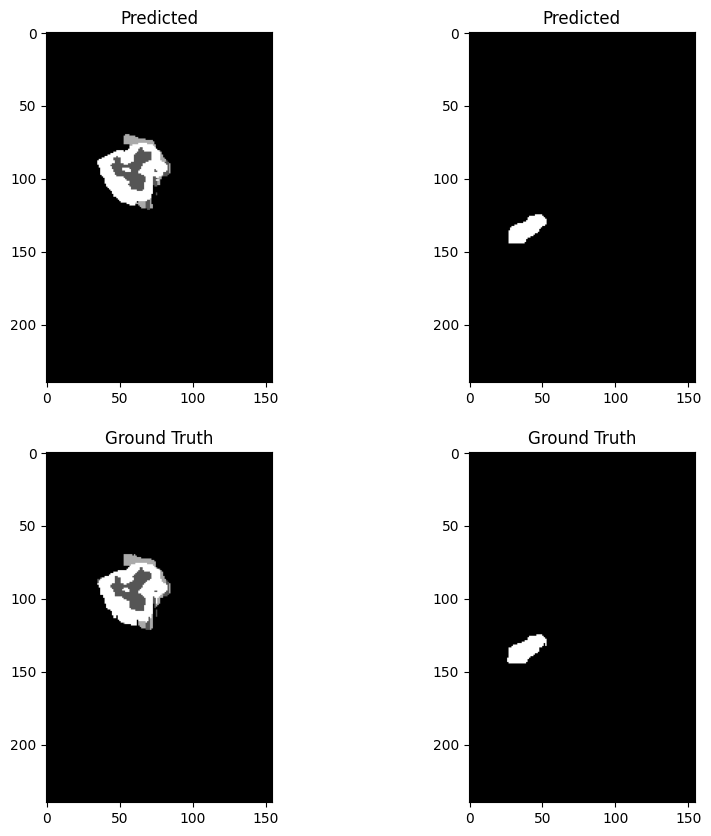

100%|██████████| 246/246 [08:30<00:00,  2.08s/it]



Average Training Loss: 0.0050839603702515

Average Training DSC: [0.99940211 0.94107472 0.95116645 0.86857913]
Average Training ASSD: [ 0.05314196  5.94339082  7.63033782 10.03623688]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


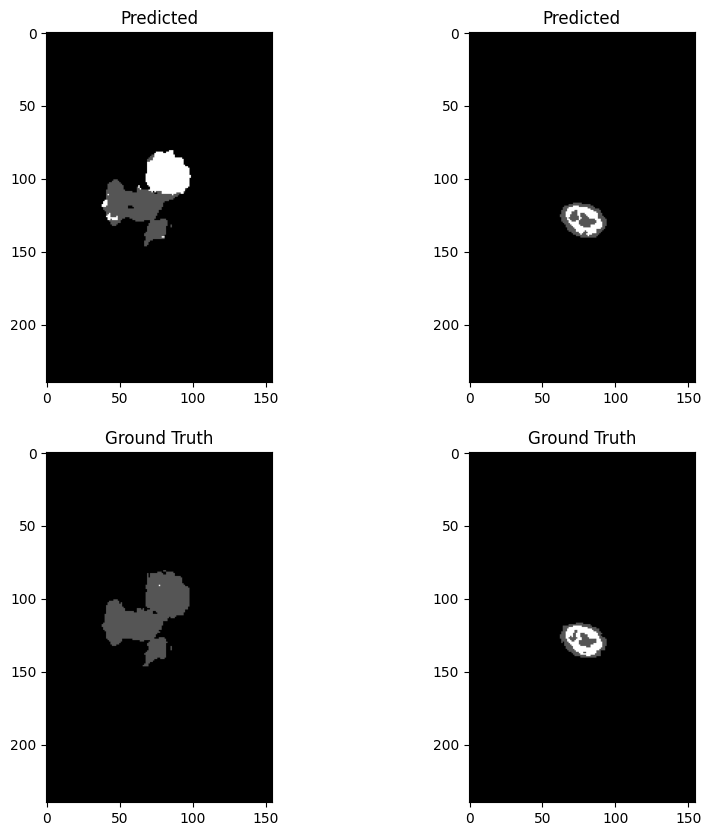

100%|██████████| 62/62 [01:30<00:00,  1.45s/it]


Average Validation Loss: 0.006951476912945509

Average Validation DSC: [0.99925543 0.92119256 0.94773033 0.84373101]
Average Validation ASSD: [ 0.07492157  9.78414948  6.96943289 11.66399147]
Epoch 48/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


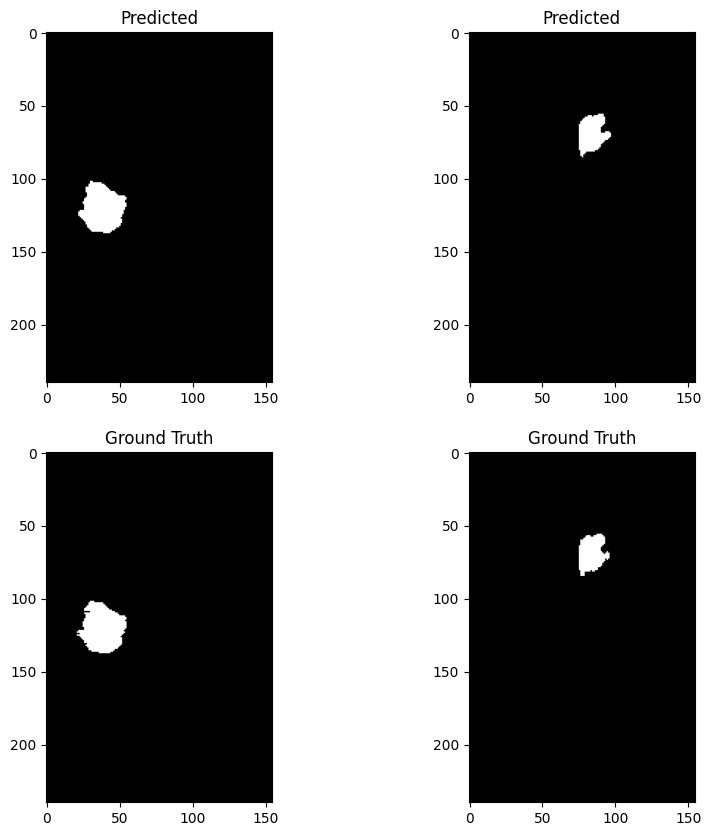

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.005026781251956898

Average Training DSC: [0.99942109 0.94185055 0.9558237  0.86890556]
Average Training ASSD: [0.05106659 5.87853991 7.12779609 9.69782174]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


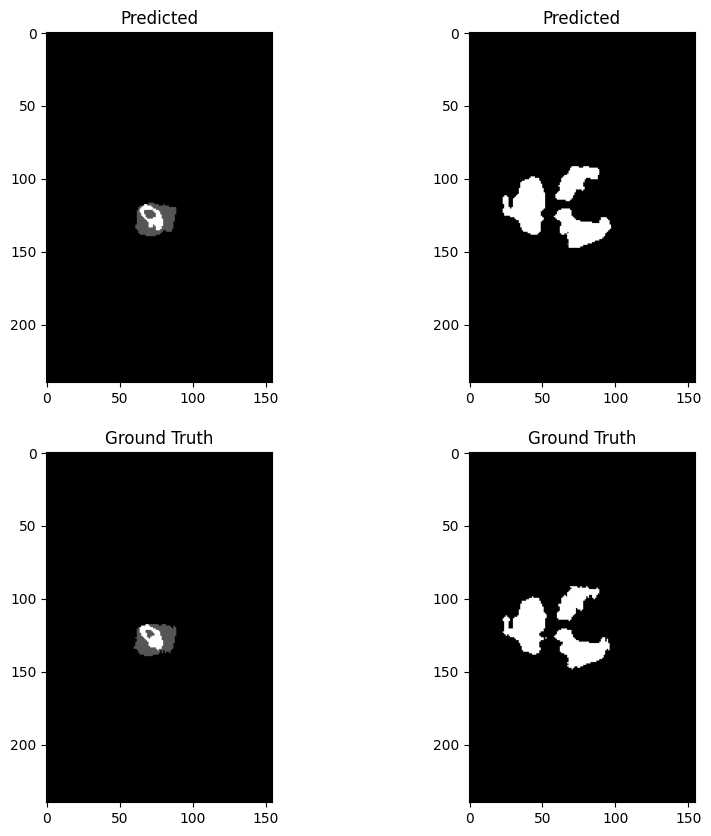

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.007757335405556425

Average Validation DSC: [0.99915189 0.90458453 0.92016857 0.83175443]
Average Validation ASSD: [ 0.08008488 13.24330733 13.64576318  9.87057406]
Epoch 49/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


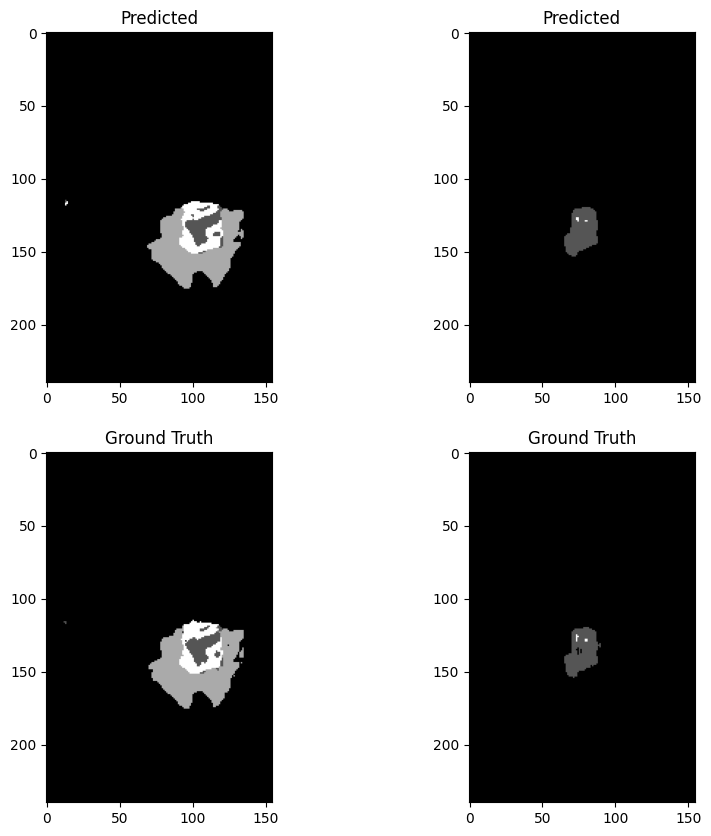

100%|██████████| 246/246 [08:29<00:00,  2.07s/it]



Average Training Loss: 0.005125987186376762

Average Training DSC: [0.99940884 0.93608715 0.95579512 0.86799643]
Average Training ASSD: [0.05359013 7.72513438 6.45583236 9.85927532]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


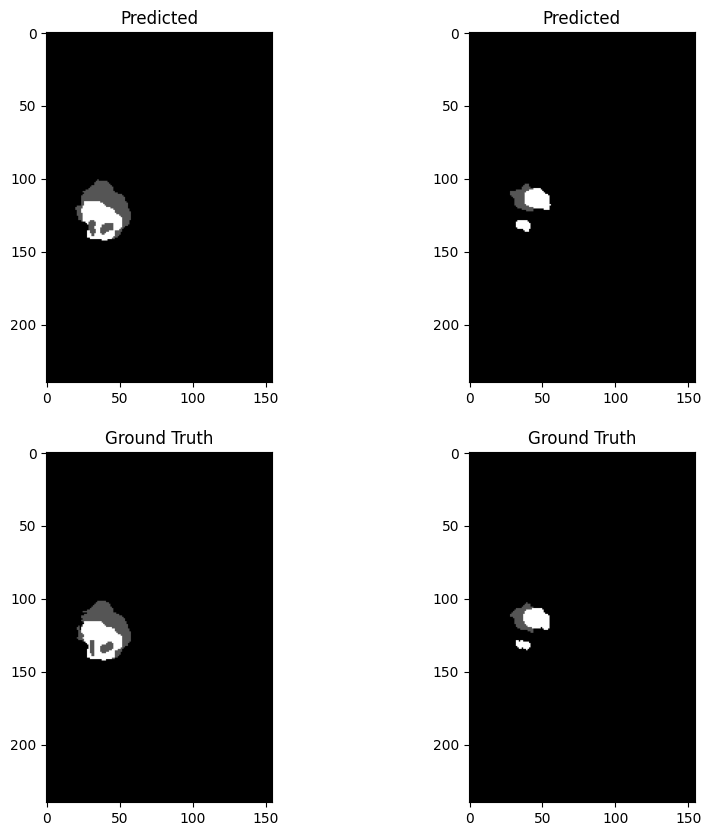

100%|██████████| 62/62 [01:31<00:00,  1.47s/it]


Average Validation Loss: 0.007404704705902165

Average Validation DSC: [0.99916974 0.92055168 0.93904737 0.84307697]
Average Validation ASSD: [ 0.07967178  8.35580238  9.74729975 10.05742603]
Epoch 50/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


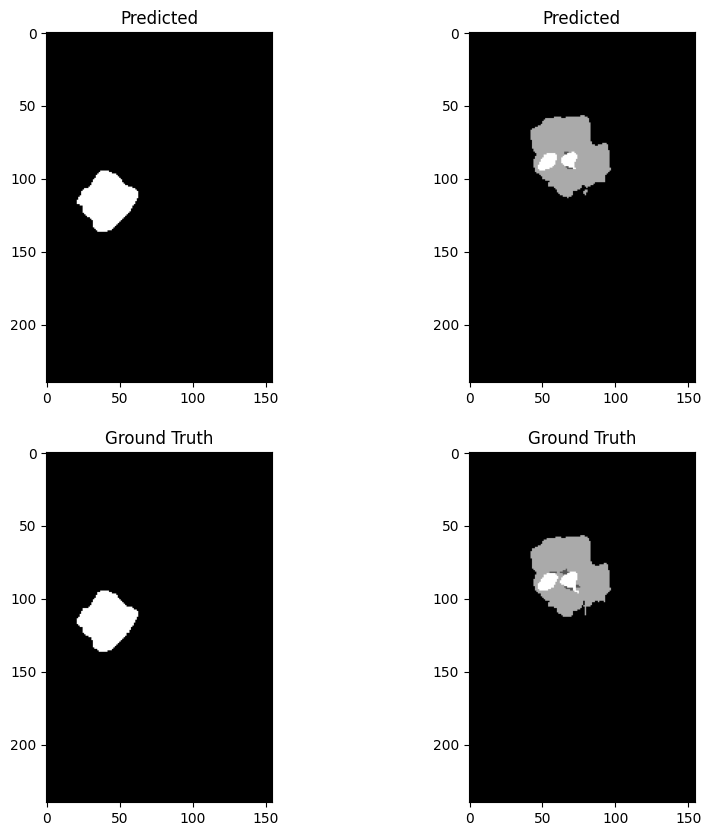

100%|██████████| 246/246 [08:31<00:00,  2.08s/it]



Average Training Loss: 0.00454200924434737

Average Training DSC: [0.99946757 0.94700861 0.95977965 0.87801085]
Average Training ASSD: [0.04651183 5.06092003 5.89463558 9.8145373 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


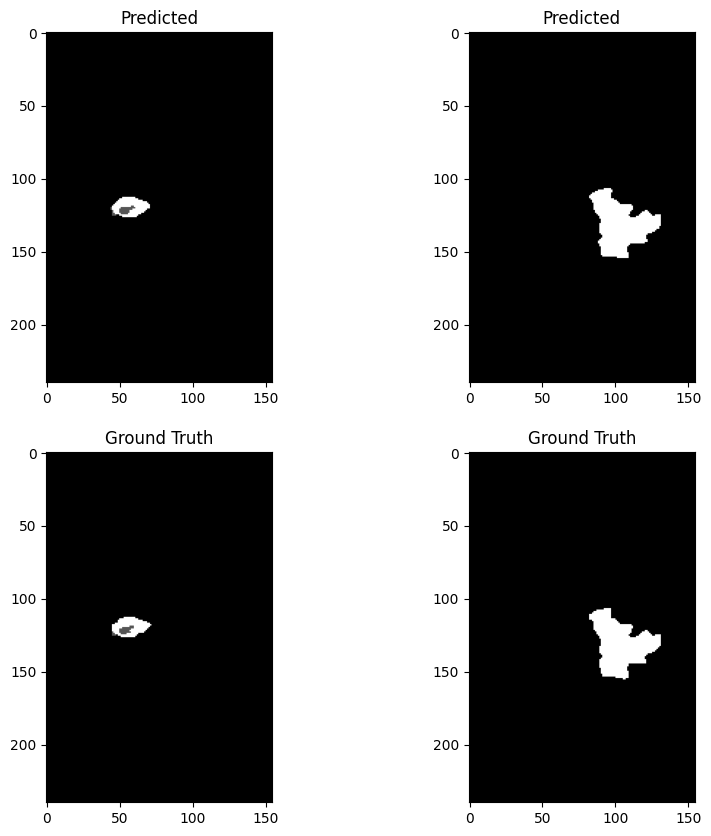

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.00662307072836425

Average Validation DSC: [0.99928559 0.92851126 0.95032653 0.85983243]
Average Validation ASSD: [0.06890669 6.87058762 6.49893292 9.40975666]
Epoch 51/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


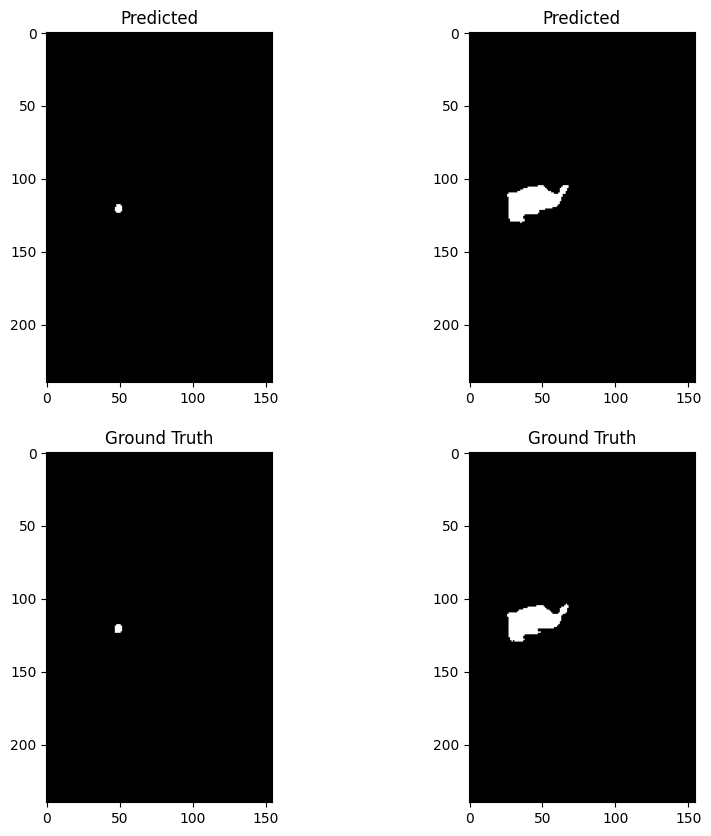

100%|██████████| 246/246 [08:31<00:00,  2.08s/it]



Average Training Loss: 0.004275511053004642

Average Training DSC: [0.99949827 0.95022546 0.96078084 0.8843592 ]
Average Training ASSD: [0.04315706 4.98450744 6.00818852 9.88105619]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


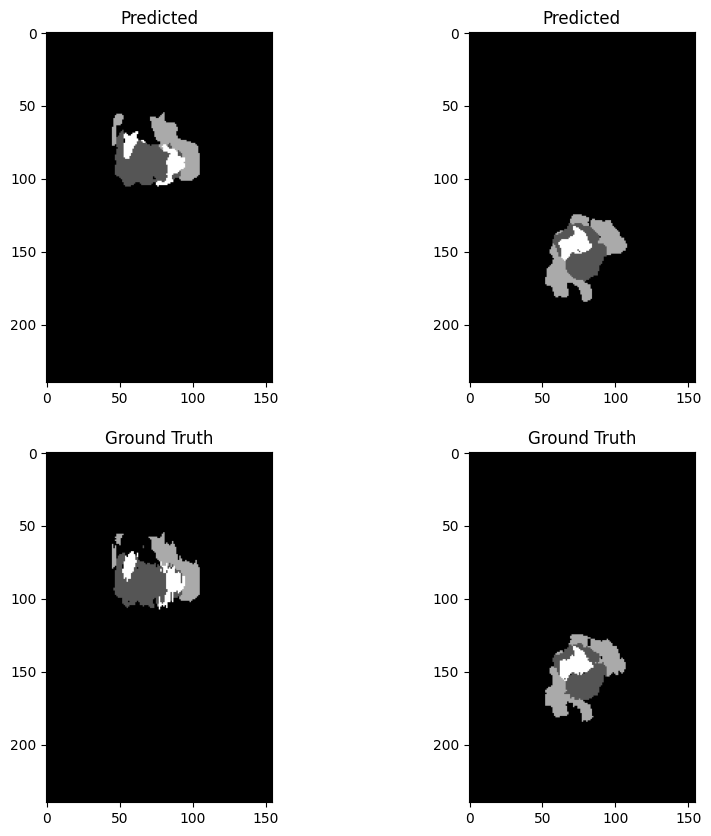

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.006854036819159744

Average Validation DSC: [0.99928404 0.93662107 0.95166586 0.85997414]
Average Validation ASSD: [0.0678198  4.42961217 5.55713405 7.5678315 ]
Epoch 52/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


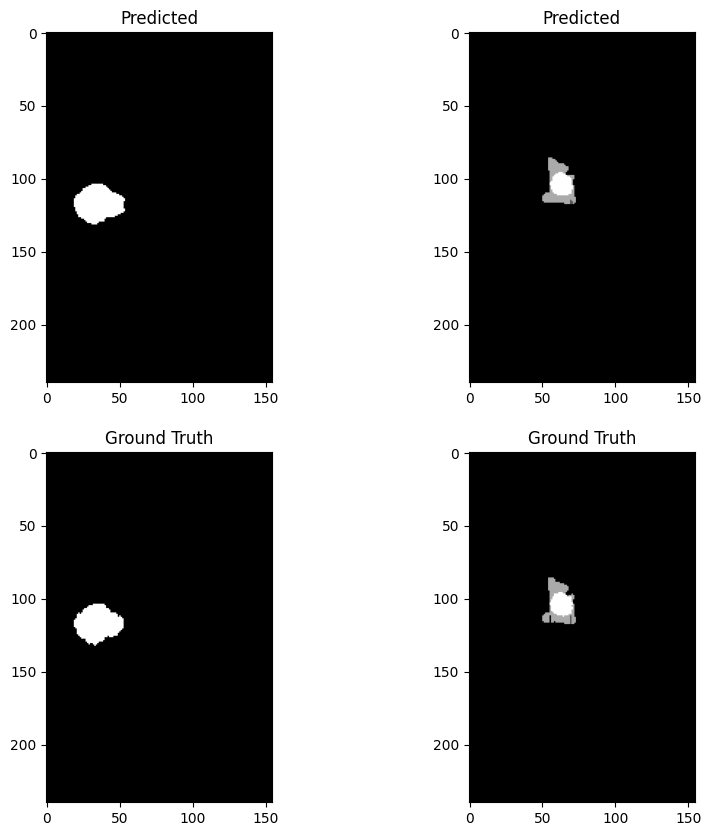

100%|██████████| 246/246 [08:32<00:00,  2.08s/it]



Average Training Loss: 0.004056865250033031

Average Training DSC: [0.99951704 0.95399906 0.96235683 0.88779786]
Average Training ASSD: [0.04171328 3.74851405 5.51470196 9.6308046 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


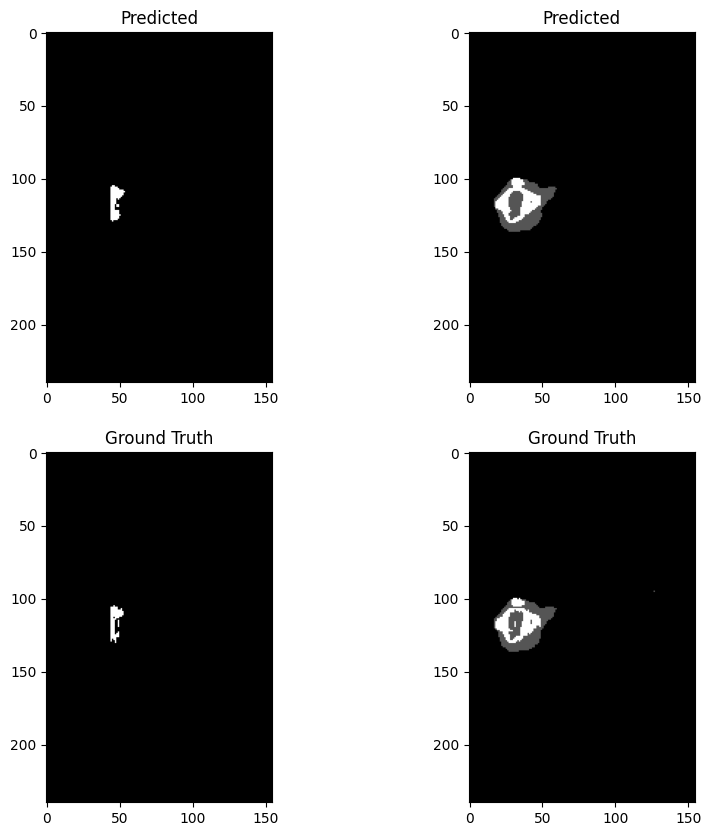

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.006567150737429338

Average Validation DSC: [0.99927845 0.93437183 0.94947756 0.8606796 ]
Average Validation ASSD: [0.06912536 6.13381085 6.75269953 7.98645793]
Epoch 53/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


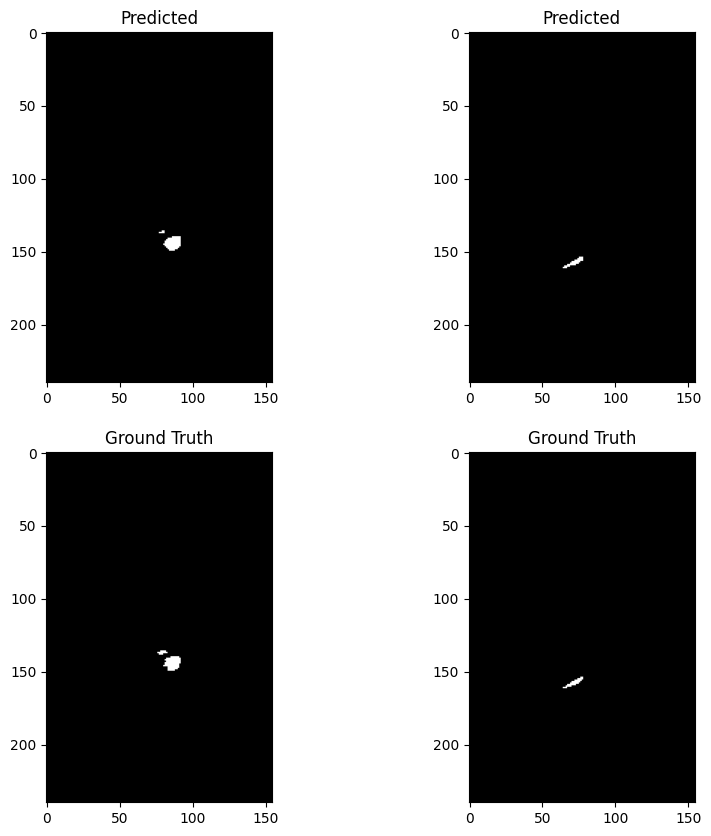

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.008519437590924403

Average Training DSC: [0.99900861 0.89055312 0.91191712 0.82238488]
Average Training ASSD: [ 0.10835456 18.10965159 18.8886531  12.17984764]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


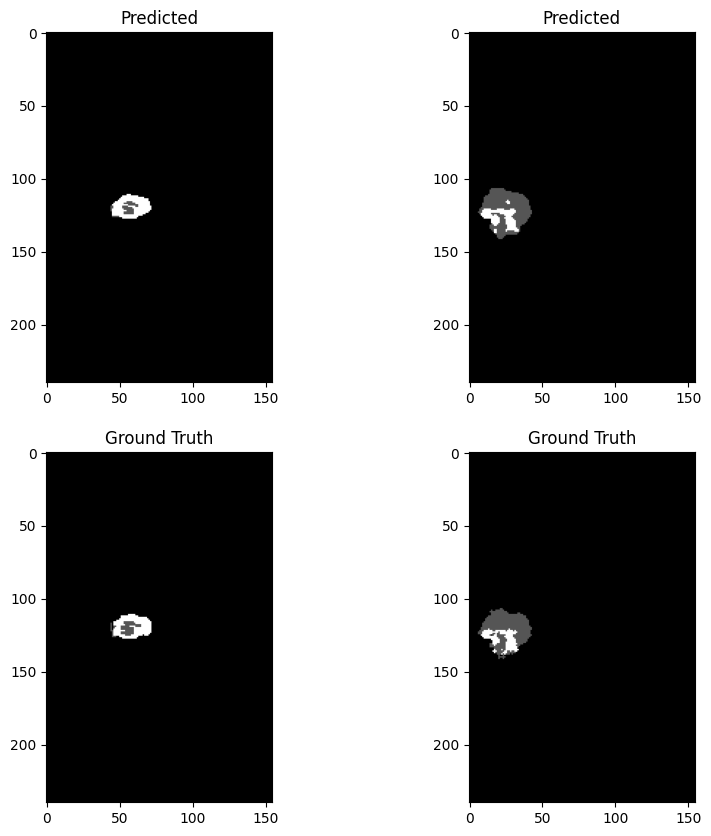

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.010455334085911032

Average Validation DSC: [0.99880234 0.83127555 0.91641877 0.79150277]
Average Validation ASSD: [ 0.12340543 33.32037634 14.14003074 14.33838175]
Epoch 54/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


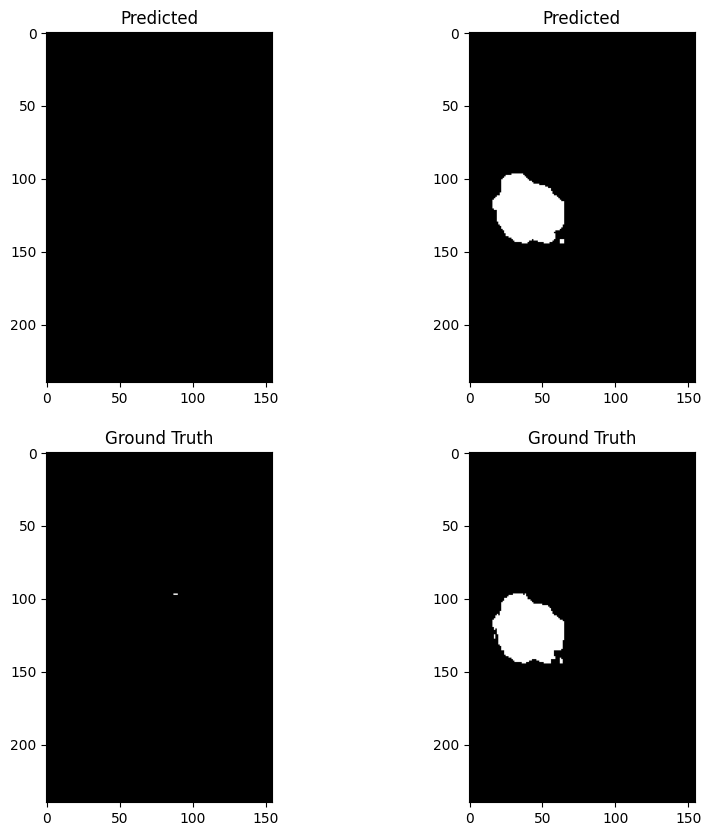

100%|██████████| 246/246 [08:35<00:00,  2.09s/it]



Average Training Loss: 0.006048340773459796

Average Training DSC: [0.99929278 0.92129697 0.94592804 0.85034733]
Average Training ASSD: [ 0.06803949 11.25861114  9.50600866 10.48064219]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


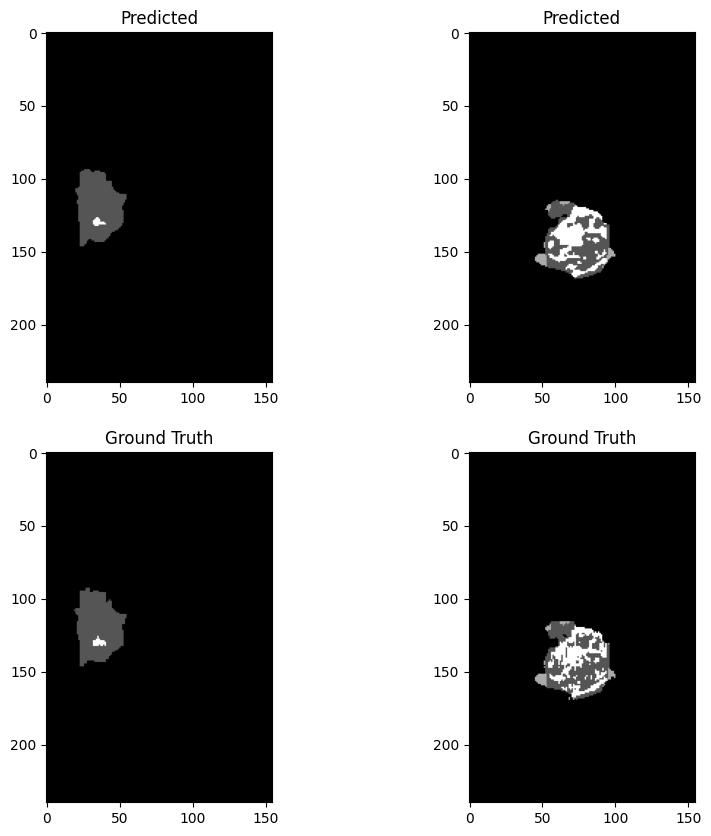

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.0067997827840548366

Average Validation DSC: [0.99919359 0.91851385 0.93808236 0.84650207]
Average Validation ASSD: [0.08191369 8.61944665 9.67862509 8.95245746]
Epoch 55/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


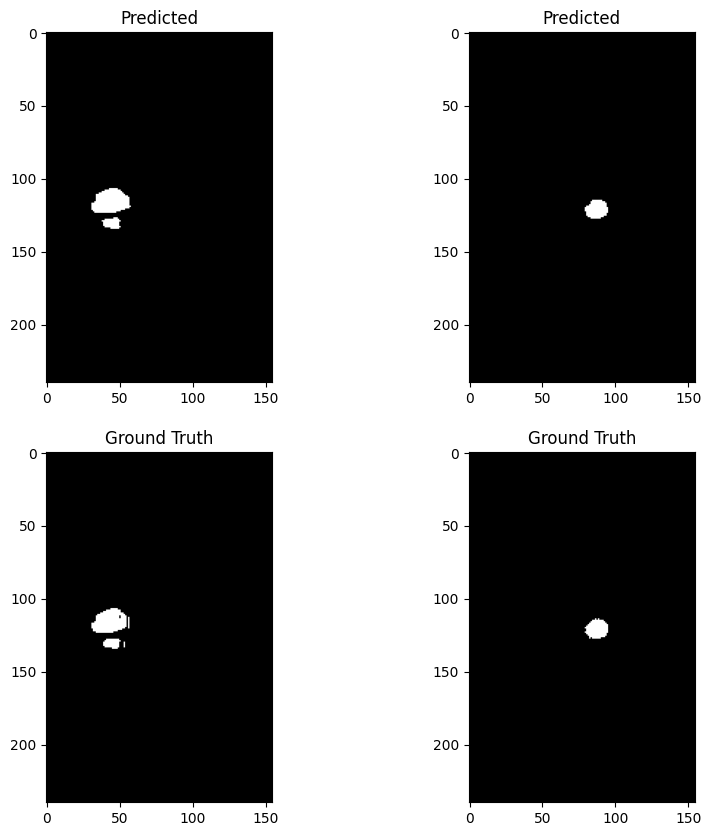

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.0050222309565595615

Average Training DSC: [0.99941629 0.93942408 0.9522109  0.87196595]
Average Training ASSD: [0.05336389 7.46788109 8.05912845 9.5641579 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


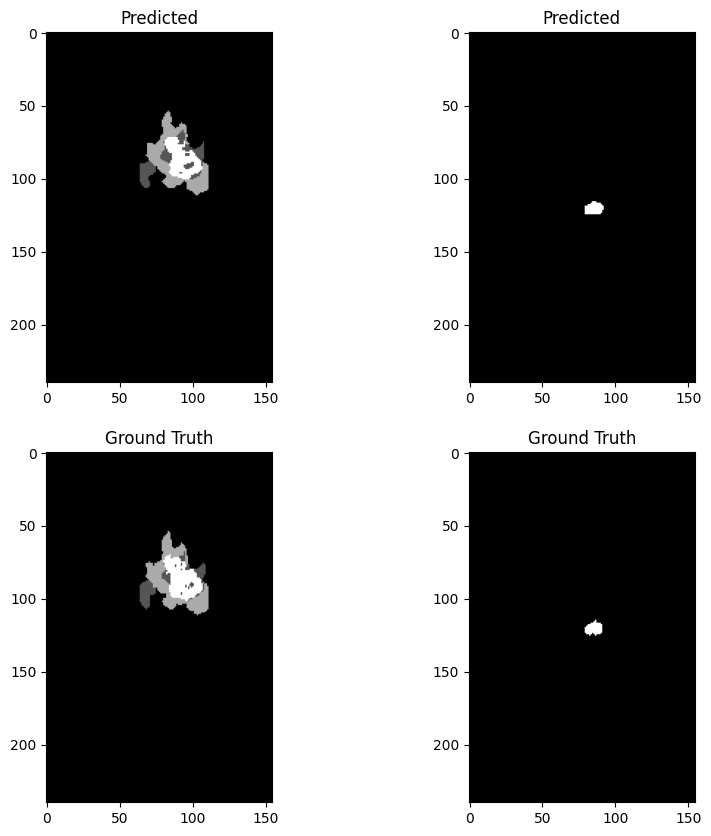

100%|██████████| 62/62 [01:29<00:00,  1.44s/it]


Average Validation Loss: 0.006679029309100682

Average Validation DSC: [0.99923771 0.91962459 0.94801008 0.8479499 ]
Average Validation ASSD: [0.07473111 9.55066877 6.7485059  9.76125044]
Epoch 56/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


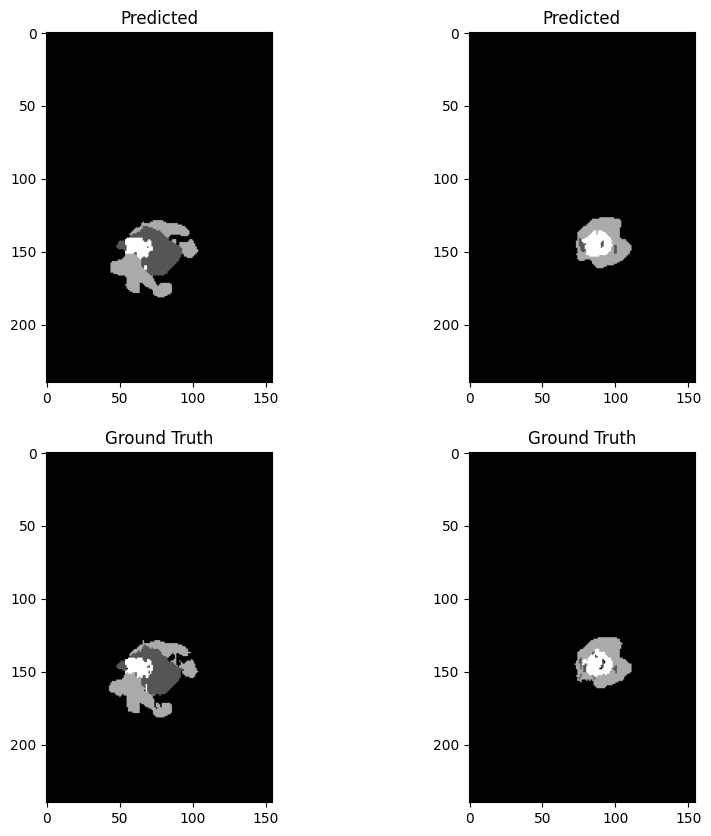

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.004266147518329837

Average Training DSC: [0.99949982 0.9470045  0.96009276 0.88506989]
Average Training ASSD: [0.04507137 6.03489549 6.54625316 9.8024259 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


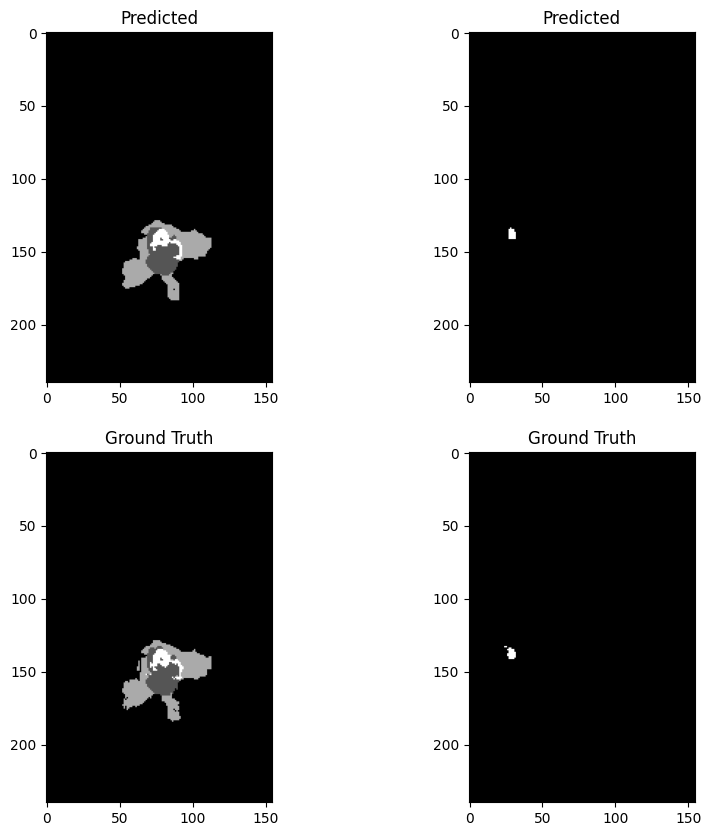

100%|██████████| 62/62 [01:29<00:00,  1.44s/it]


Average Validation Loss: 0.005759642324260165

Average Validation DSC: [0.99935906 0.94057977 0.95757938 0.86515967]
Average Validation ASSD: [0.06410809 4.88297771 4.54419613 9.64042576]
Epoch 57/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


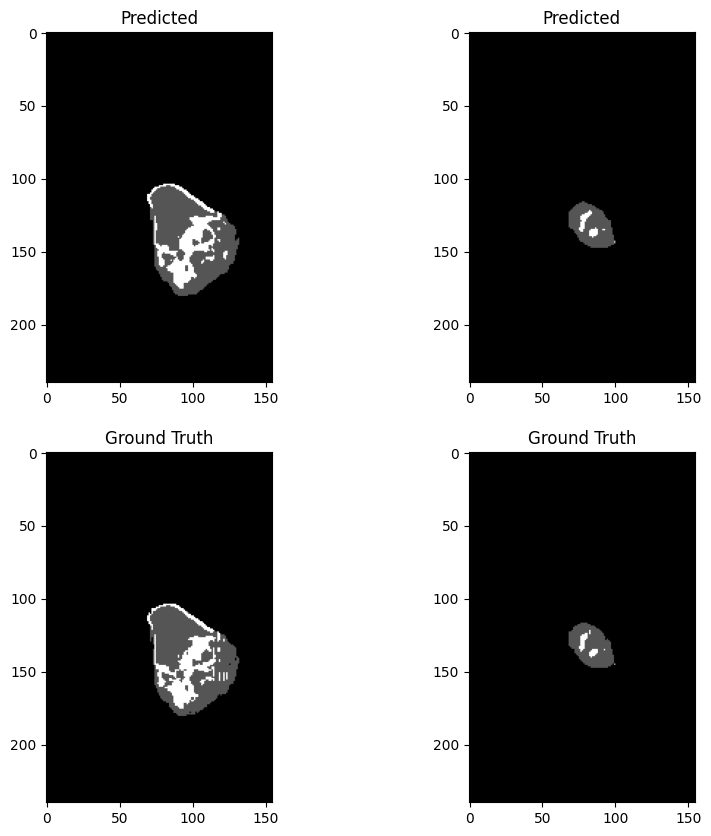

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.0035726215342074875

Average Training DSC: [0.99958054 0.95942089 0.96703133 0.89901418]
Average Training ASSD: [0.03624613 3.05290158 4.82713408 9.11293146]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


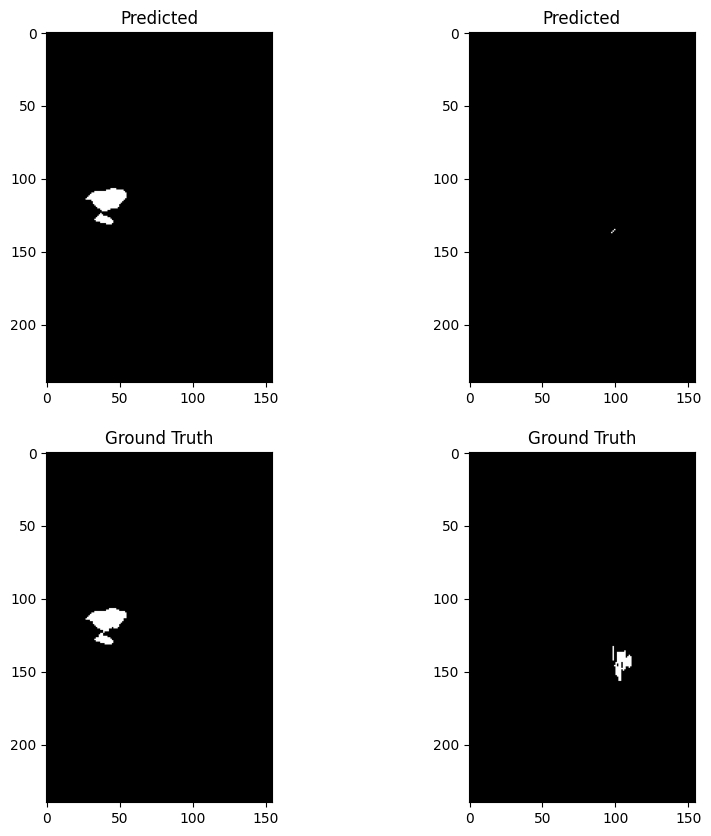

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.005476991717343128

Average Validation DSC: [0.99940884 0.94345781 0.9525065  0.87649867]
Average Validation ASSD: [0.05813936 4.39546642 6.98053081 8.61103472]
Epoch 58/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


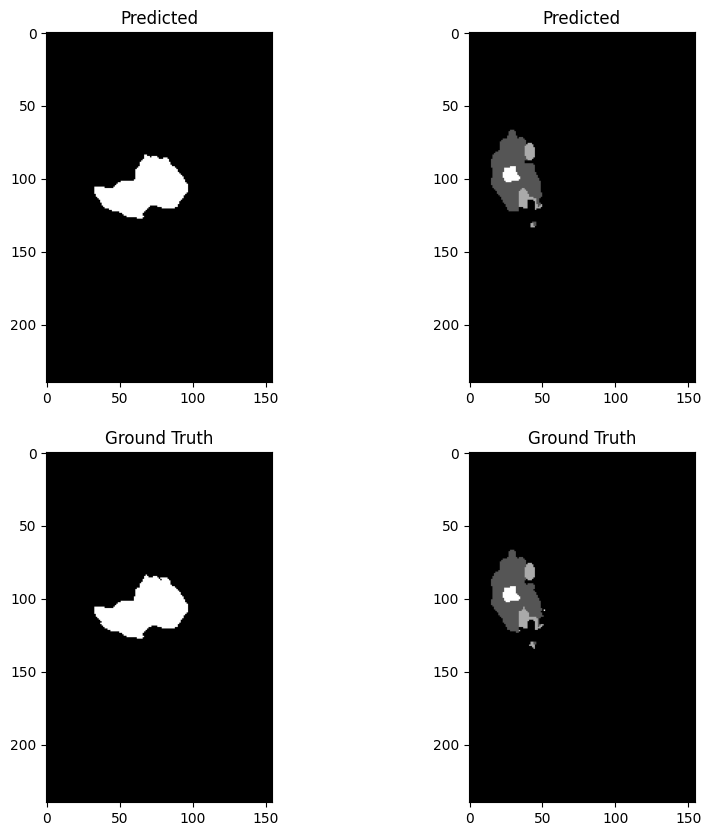

100%|██████████| 246/246 [08:35<00:00,  2.10s/it]



Average Training Loss: 0.003673383535446251

Average Training DSC: [0.99959254 0.95650597 0.96549956 0.8989497 ]
Average Training ASSD: [0.03420654 3.97765183 5.30818359 8.55698754]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


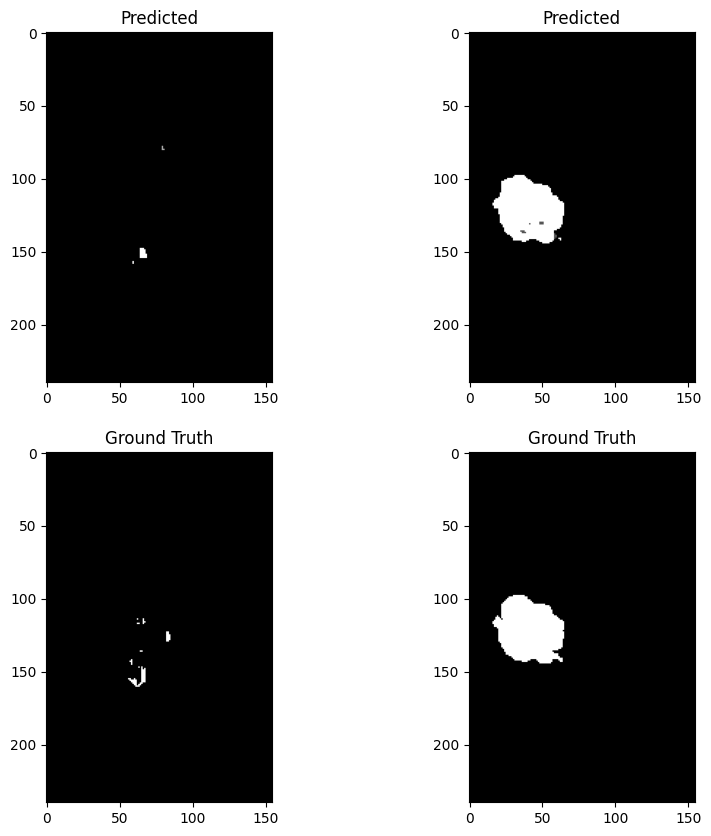

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.00846959580667317

Average Validation DSC: [0.99910647 0.77746548 0.9290876  0.82028405]
Average Validation ASSD: [ 0.09450755 57.52094532 12.86237563  8.9449781 ]
Epoch 59/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


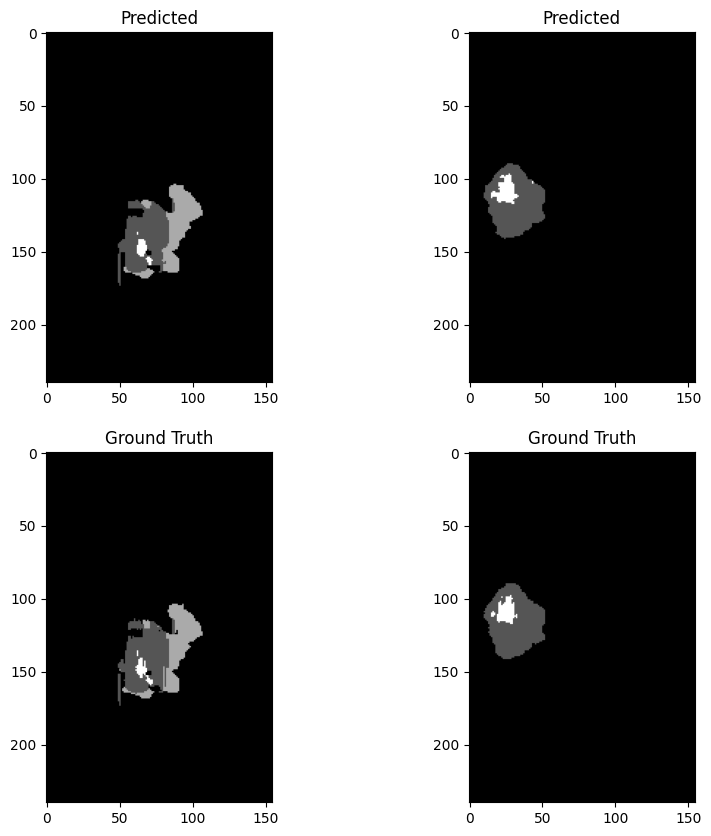

100%|██████████| 246/246 [08:38<00:00,  2.11s/it]



Average Training Loss: 0.00464501535535101

Average Training DSC: [0.99947928 0.93951609 0.95929146 0.87711953]
Average Training ASSD: [0.04739522 7.81934124 6.14468341 9.78661749]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


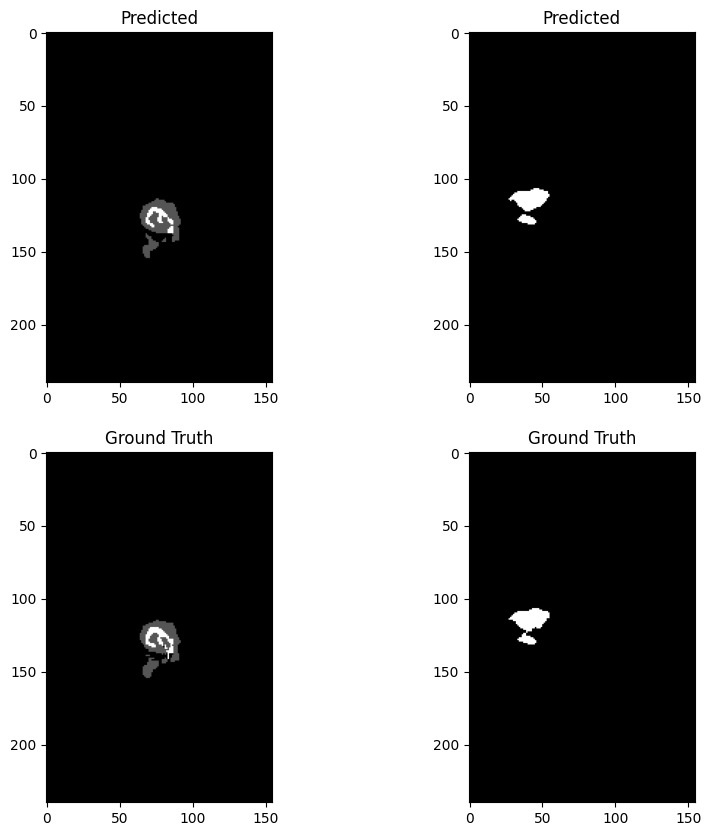

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.006348638239526941

Average Validation DSC: [0.99936215 0.93564202 0.94902461 0.84732249]
Average Validation ASSD: [ 0.06061441  4.20755067  7.47897092 11.47687844]
Epoch 60/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


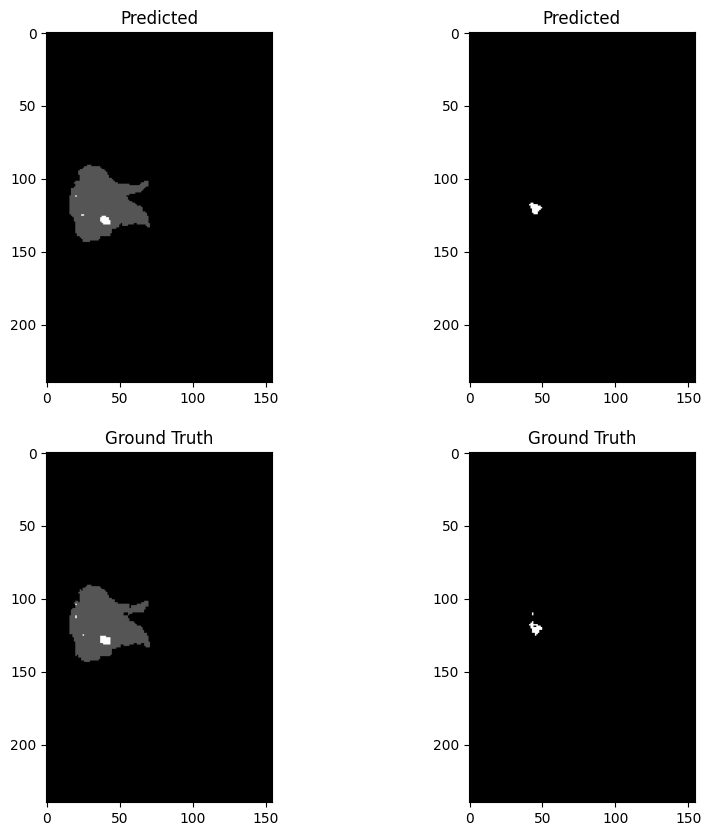

100%|██████████| 246/246 [08:38<00:00,  2.11s/it]



Average Training Loss: 0.003793298263515429

Average Training DSC: [0.99955026 0.95477809 0.96526665 0.89451649]
Average Training ASSD: [0.04051759 4.77577078 5.24760472 9.04219823]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


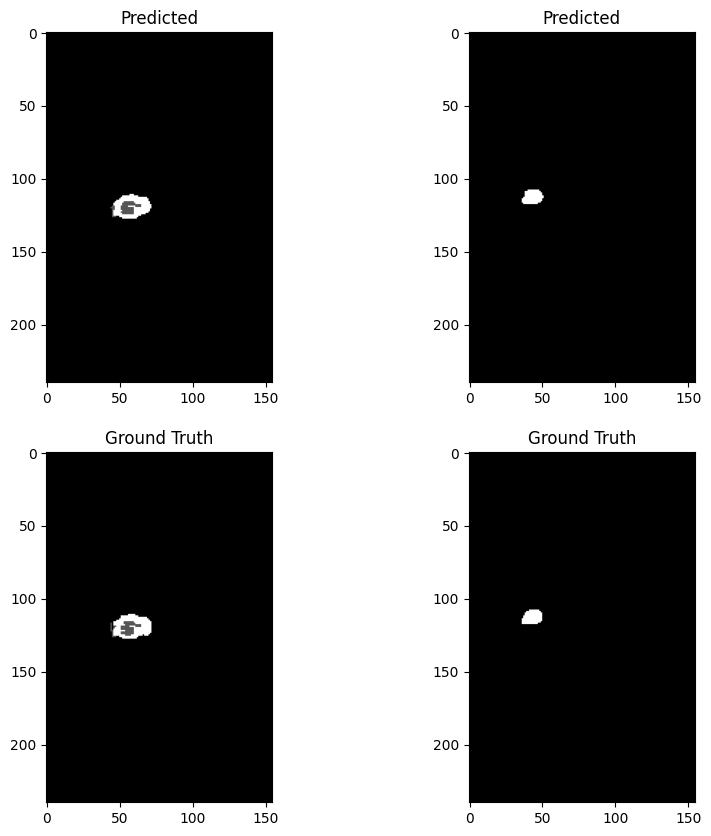

100%|██████████| 62/62 [01:31<00:00,  1.47s/it]


Average Validation Loss: 0.007335015294712878

Average Validation DSC: [0.99913144 0.90266836 0.92354844 0.82607139]
Average Validation ASSD: [ 0.09752522 15.15093191 14.78556986 14.61842204]
Epoch 61/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


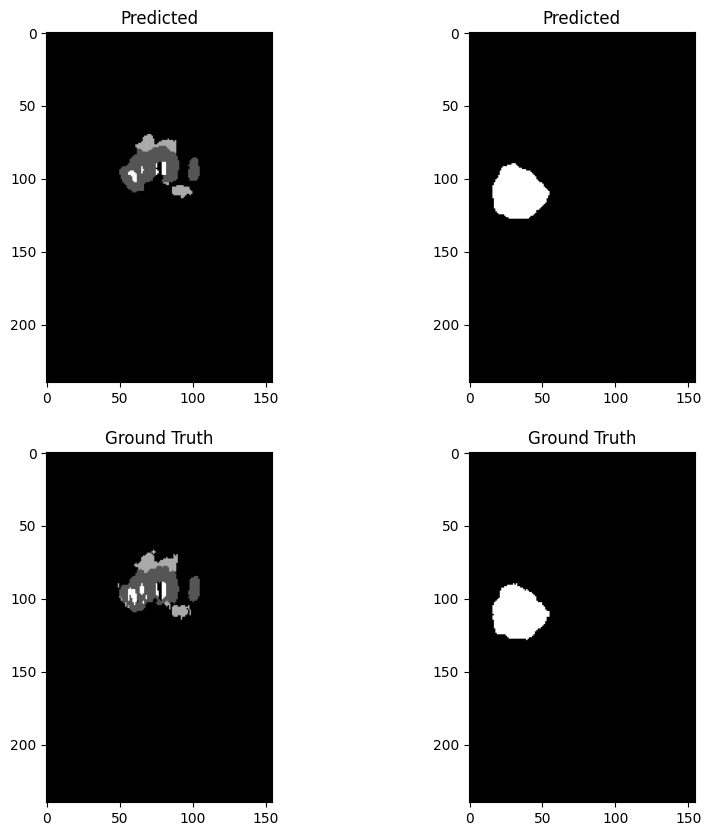

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.004757166995356481

Average Training DSC: [0.99944251 0.9370859  0.9512061  0.87852667]
Average Training ASSD: [0.05173998 8.92200674 8.83015731 8.63140602]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


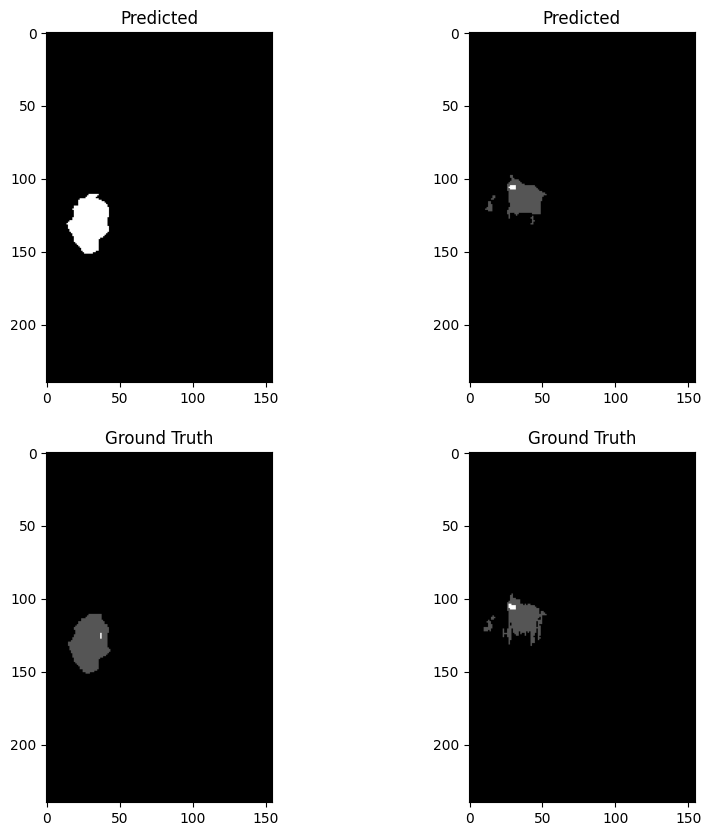

100%|██████████| 62/62 [01:30<00:00,  1.45s/it]


Average Validation Loss: 0.0070834762807334625

Average Validation DSC: [0.99926846 0.91591756 0.94381145 0.84604034]
Average Validation ASSD: [ 0.07387263 11.26177937  7.49921496 10.51338989]
Epoch 62/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


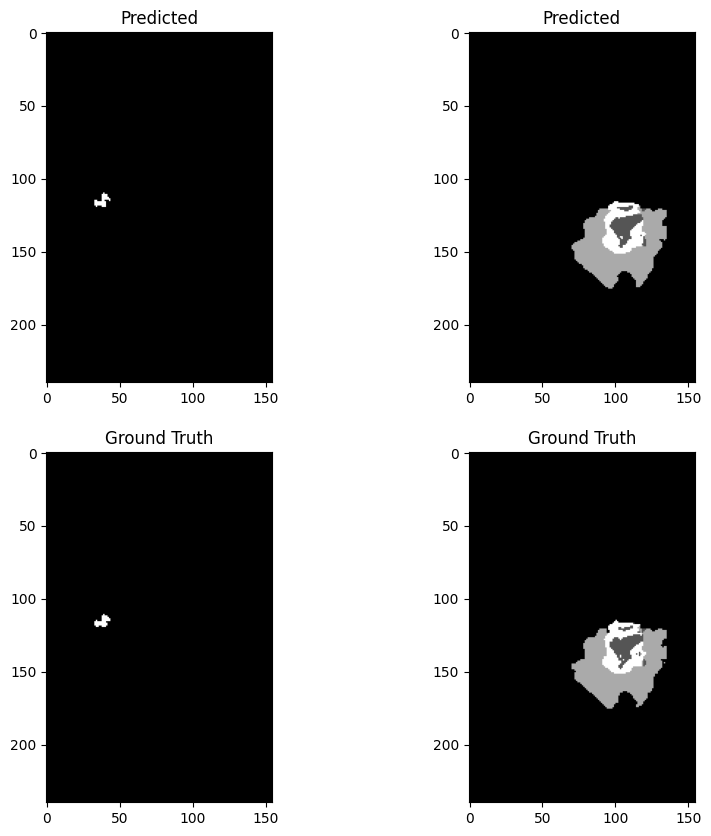

100%|██████████| 246/246 [08:32<00:00,  2.08s/it]



Average Training Loss: 0.004635638969087201

Average Training DSC: [0.99947567 0.94108842 0.95202513 0.8789028 ]
Average Training ASSD: [0.04818542 7.39514154 8.65952542 8.59232599]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


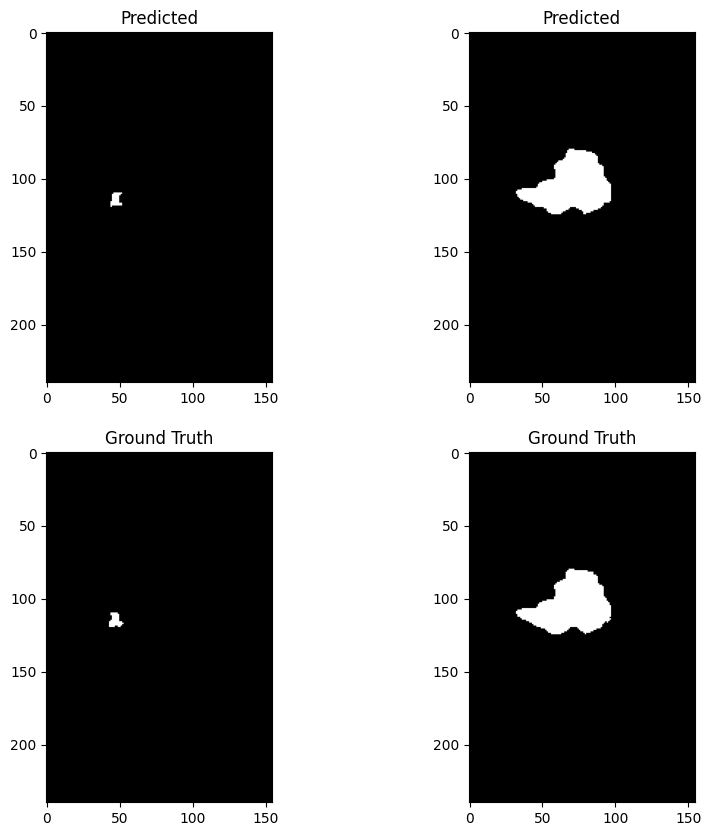

100%|██████████| 62/62 [01:31<00:00,  1.47s/it]


Average Validation Loss: 0.006964051134644016

Average Validation DSC: [0.99928169 0.91095544 0.94174331 0.85302593]
Average Validation ASSD: [ 0.07069485 12.2381197   9.67263743  7.22445851]
Epoch 63/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


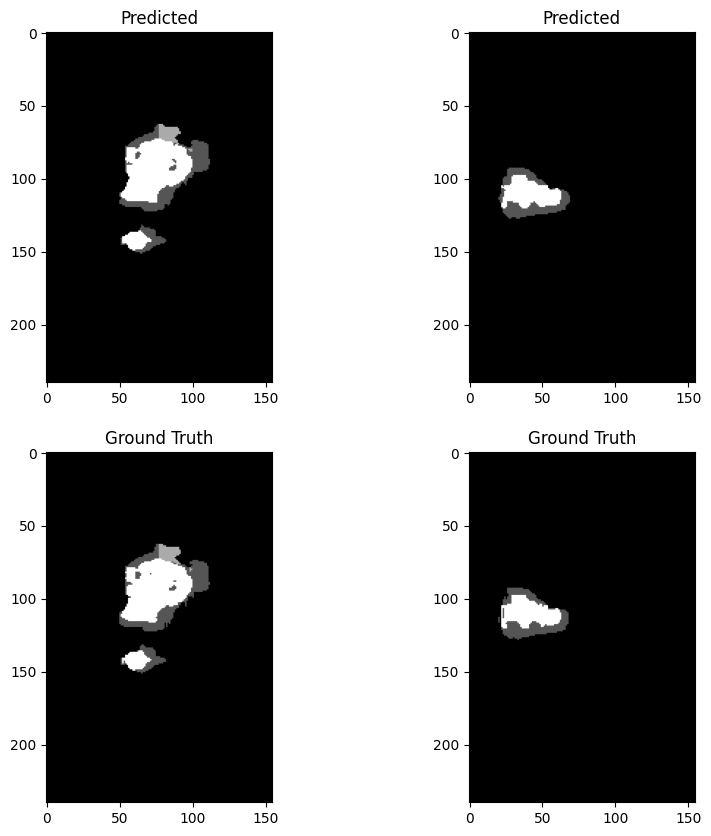

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.004307867005103972

Average Training DSC: [0.9994871  0.94925144 0.96007564 0.88715047]
Average Training ASSD: [0.04583901 5.58898436 6.85692714 8.68139726]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


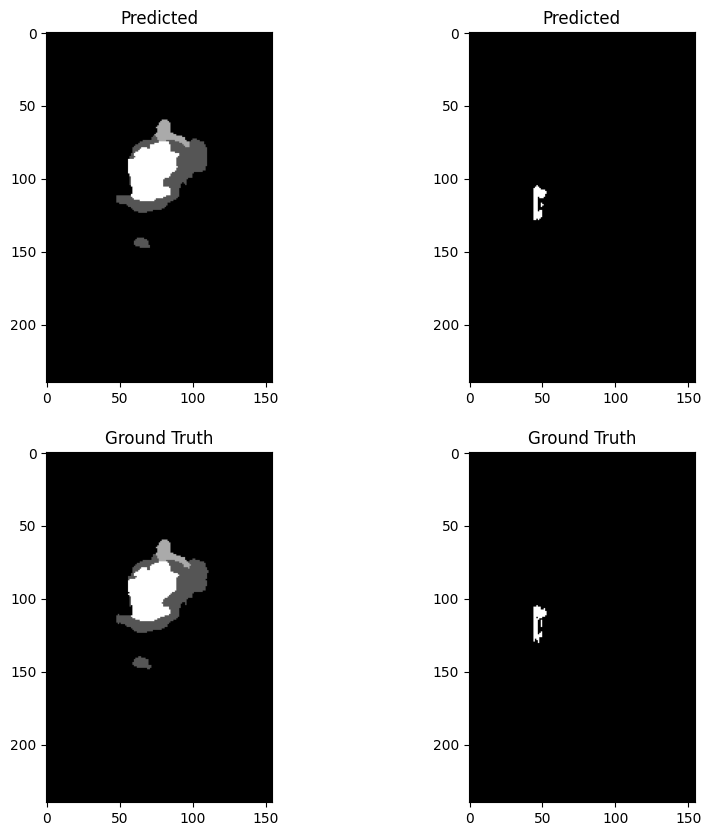

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.006139392727955936

Average Validation DSC: [0.99933476 0.93456441 0.95118339 0.8649638 ]
Average Validation ASSD: [0.06826282 5.87419848 6.53318543 9.22385705]
Epoch 64/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


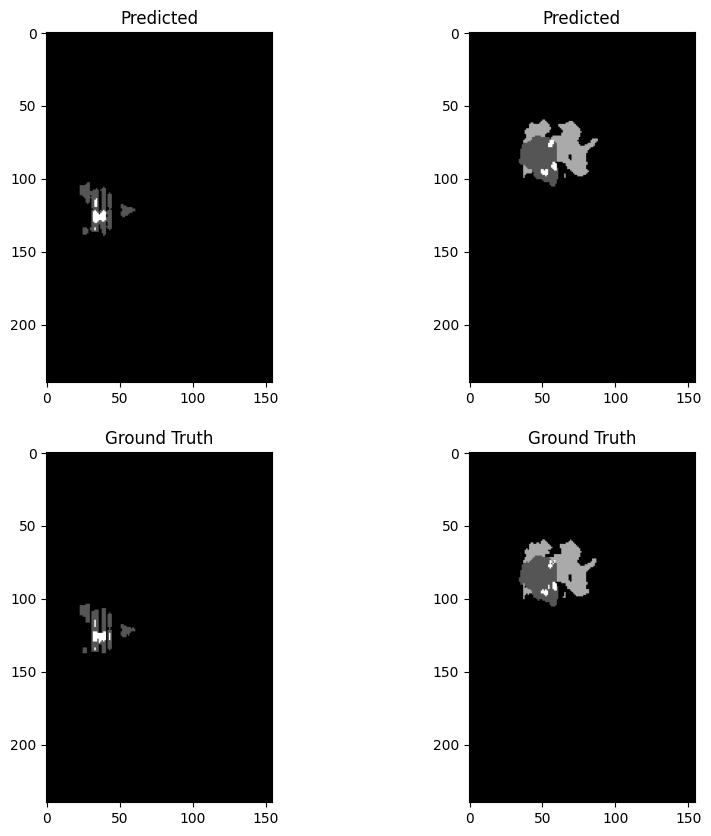

100%|██████████| 246/246 [08:31<00:00,  2.08s/it]



Average Training Loss: 0.003821983522682534

Average Training DSC: [0.99955112 0.95251745 0.96457307 0.89412628]
Average Training ASSD: [0.03952802 5.14918815 5.38812006 9.69184035]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


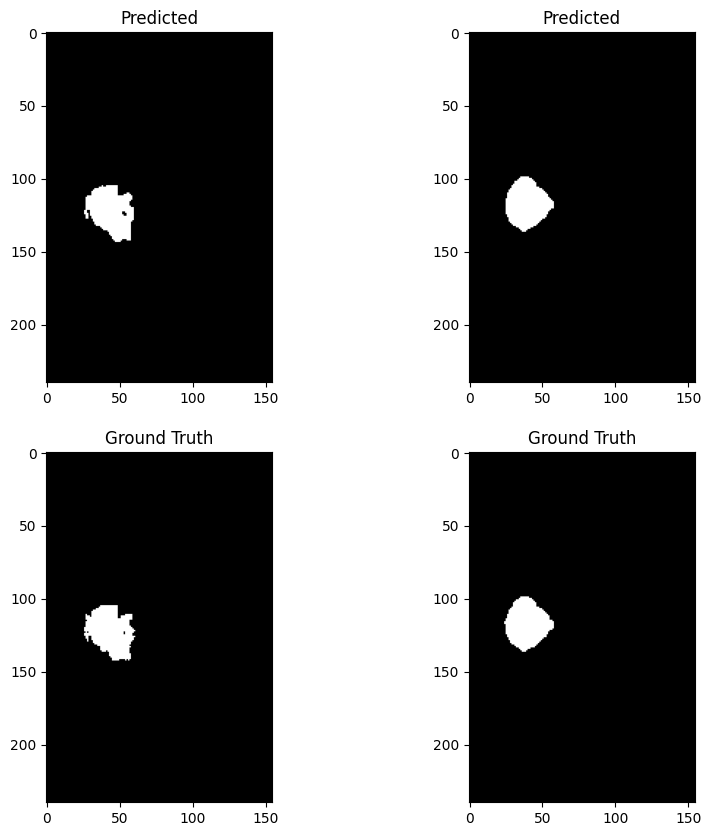

100%|██████████| 62/62 [01:30<00:00,  1.45s/it]


Average Validation Loss: 0.0057721856696110576

Average Validation DSC: [0.99940741 0.94424005 0.95476121 0.87730716]
Average Validation ASSD: [0.0591342  3.41652386 5.753192   7.36500893]
Epoch 65/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


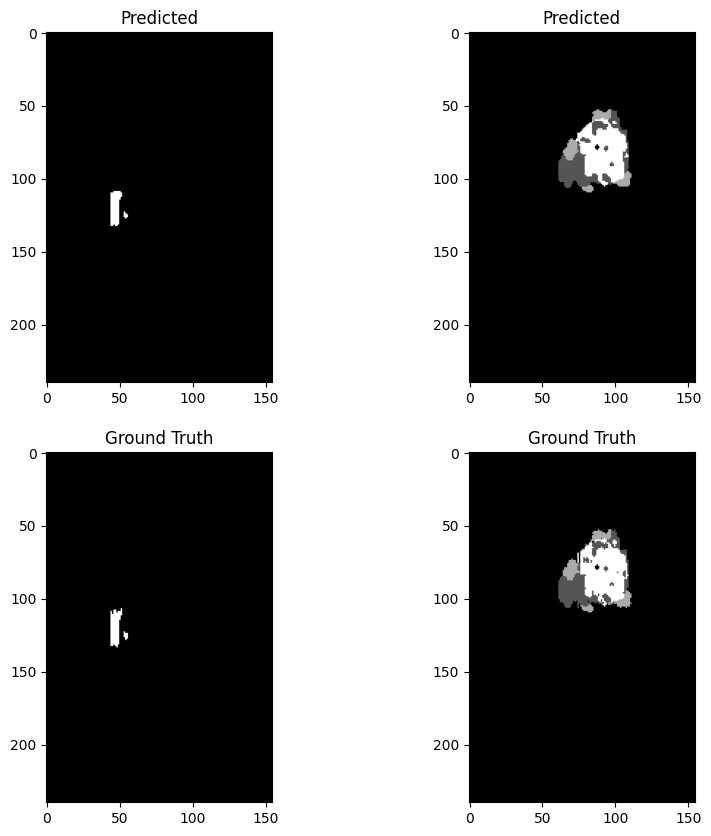

100%|██████████| 246/246 [08:36<00:00,  2.10s/it]



Average Training Loss: 0.003499574231918962

Average Training DSC: [0.99961657 0.95963048 0.96900398 0.90485137]
Average Training ASSD: [0.03254421 3.5353276  4.38336136 7.77732923]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


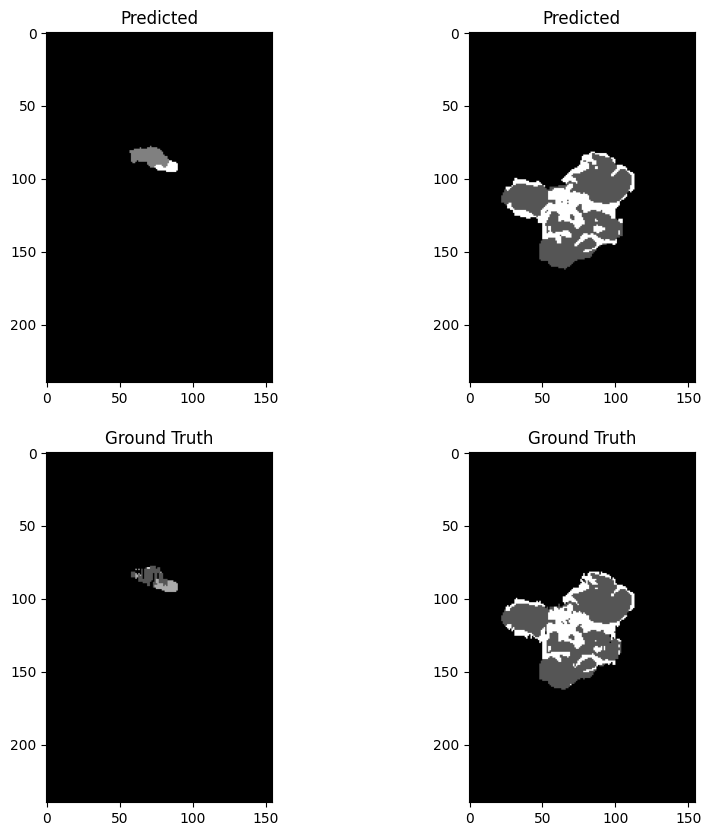

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.006156583470592816

Average Validation DSC: [0.99933179 0.92130002 0.9537863  0.86550055]
Average Validation ASSD: [ 0.06426048 10.01251618  5.76019641  7.25324872]
Epoch 66/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


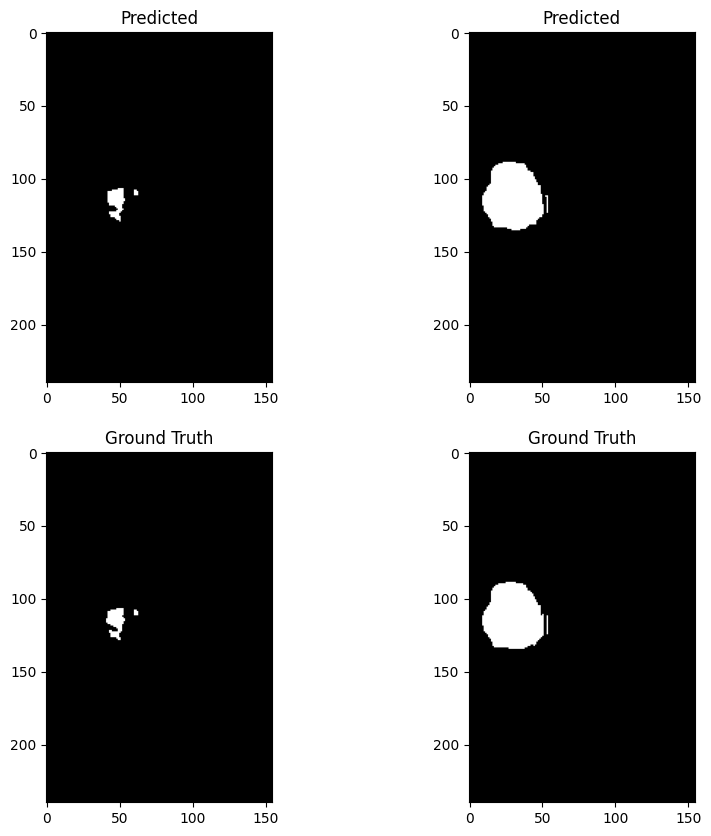

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.0045994959224575785

Average Training DSC: [0.99947771 0.93474493 0.95741077 0.88189643]
Average Training ASSD: [ 0.04694879 10.08414812  7.16667238  9.10060101]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


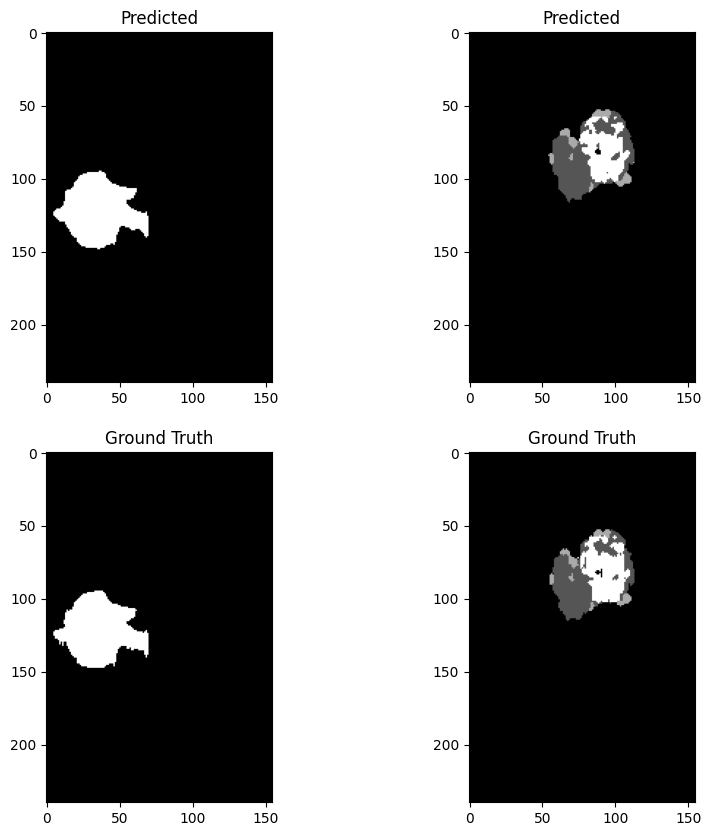

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.007648202275196391

Average Validation DSC: [0.999177   0.9008132  0.92348235 0.84033383]
Average Validation ASSD: [ 0.10416101 16.61789662 13.90705575  8.1005156 ]
Epoch 67/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


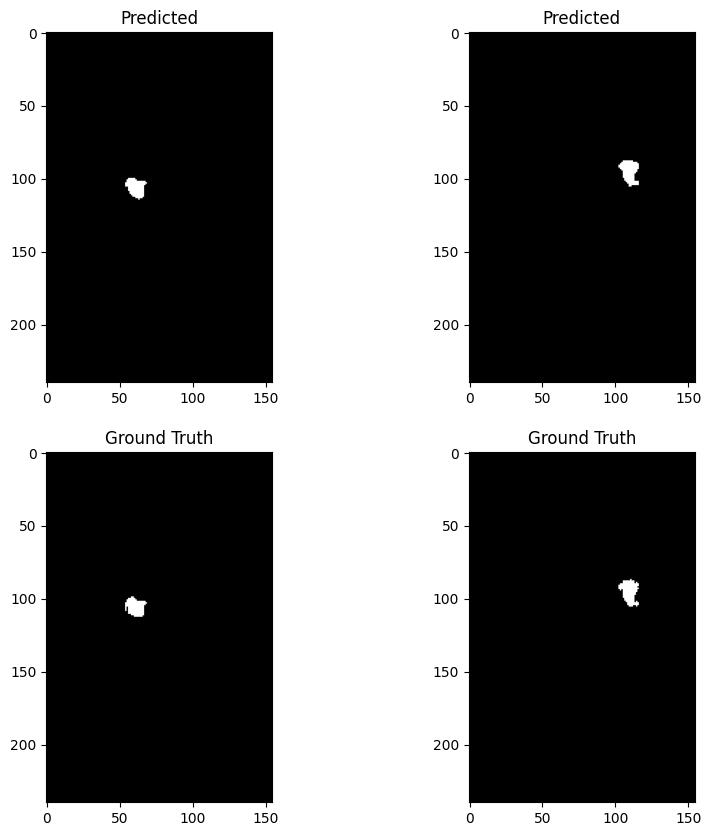

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.004128555893118122

Average Training DSC: [0.99955459 0.94768804 0.96253418 0.89142226]
Average Training ASSD: [0.03846468 6.01800532 5.9265436  8.41580307]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


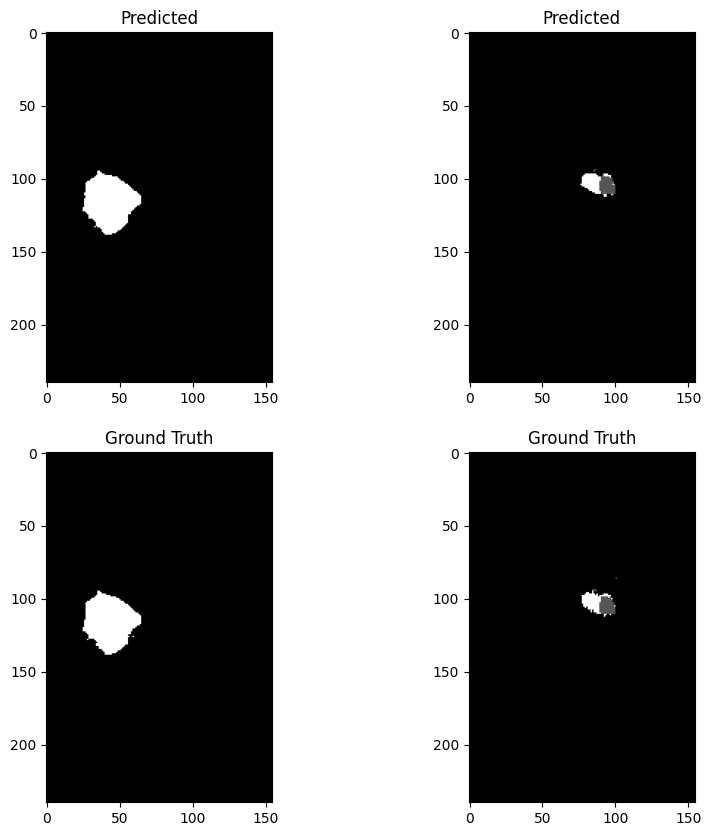

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.006125890180438517

Average Validation DSC: [0.9993655  0.92138698 0.94003025 0.86221603]
Average Validation ASSD: [ 0.06217562 11.44800675  9.9255505  10.16491923]
Epoch 68/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


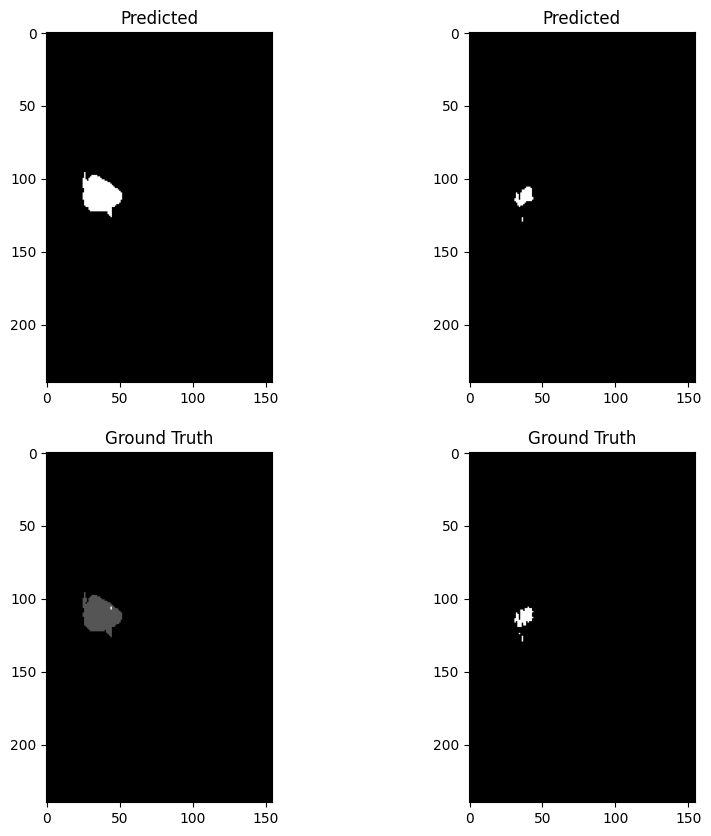

100%|██████████| 246/246 [08:39<00:00,  2.11s/it]



Average Training Loss: 0.003457839280836345

Average Training DSC: [0.99960243 0.95997661 0.96597036 0.90520063]
Average Training ASSD: [0.03477796 3.83988246 5.24416306 8.19742904]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


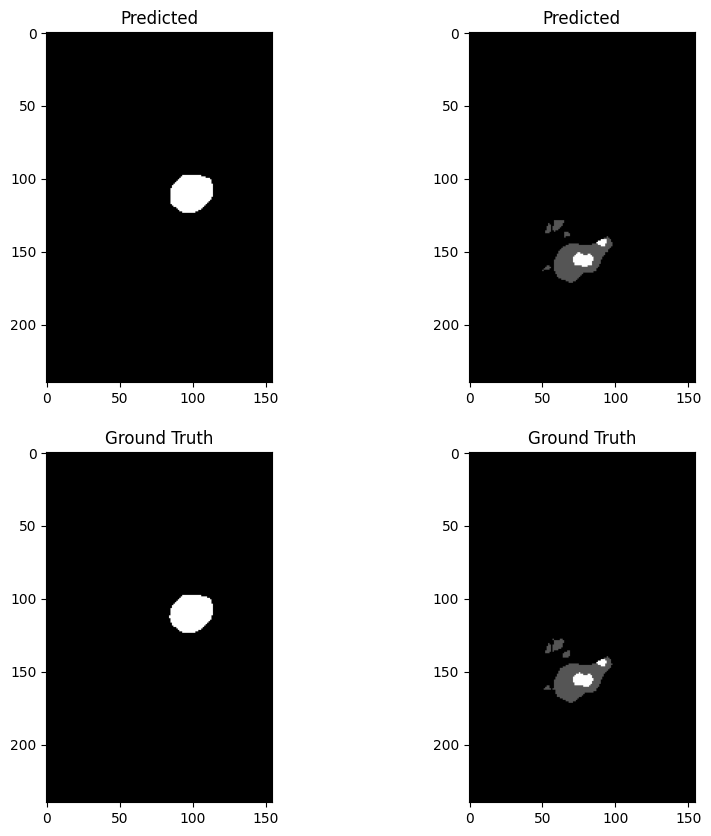

100%|██████████| 62/62 [01:29<00:00,  1.44s/it]


Average Validation Loss: 0.005699159784032212

Average Validation DSC: [0.9994231  0.94701863 0.95732662 0.88126094]
Average Validation ASSD: [0.05540399 3.64617653 5.47759844 7.23037491]
Epoch 69/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


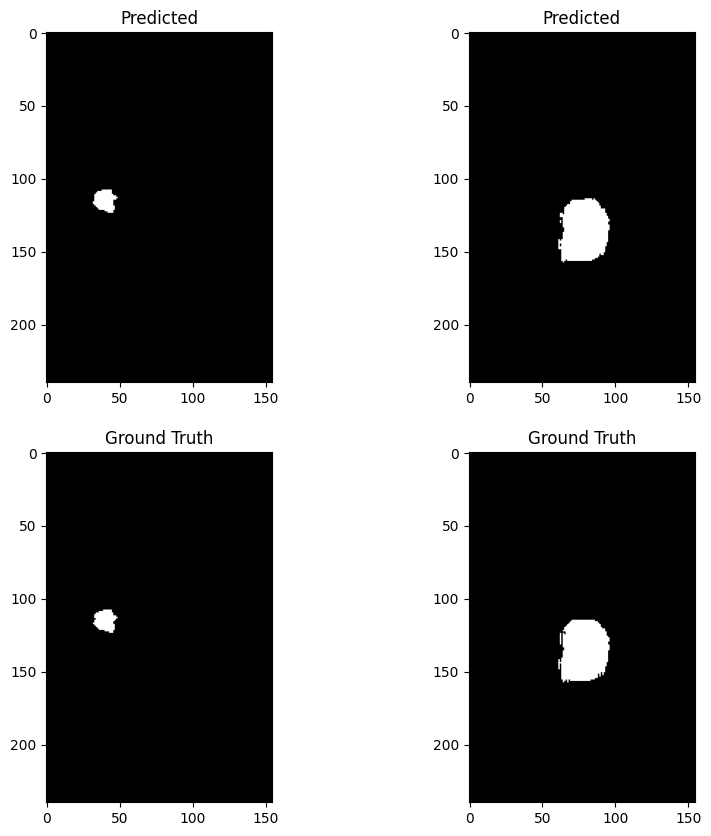

100%|██████████| 246/246 [08:35<00:00,  2.10s/it]



Average Training Loss: 0.0030643478740097546

Average Training DSC: [0.99964969 0.96860364 0.96802021 0.91497481]
Average Training ASSD: [0.02892346 1.73267075 5.35116164 8.02794346]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


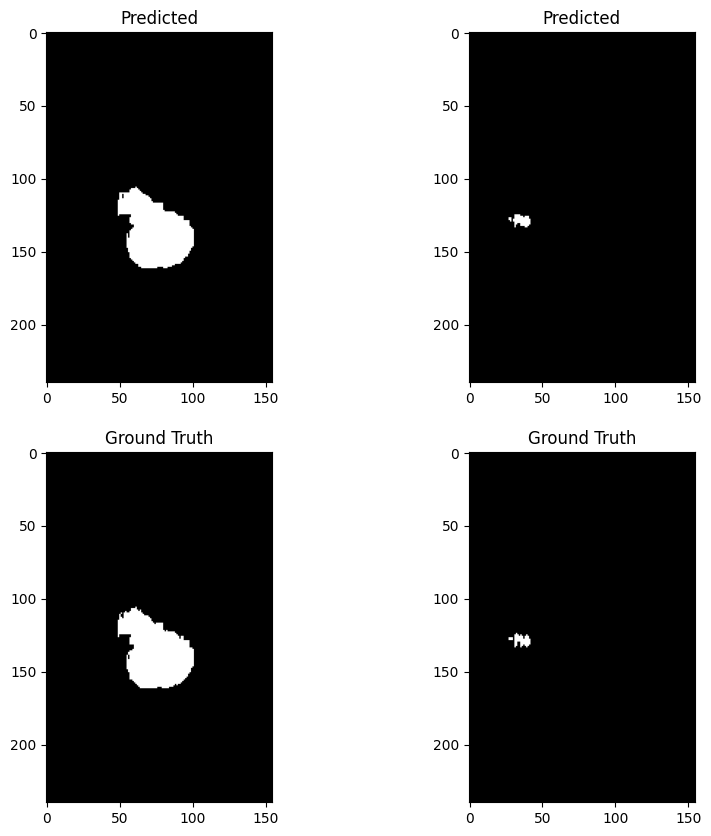

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.006201630724864381

Average Validation DSC: [0.99939213 0.93843135 0.94944513 0.87956184]
Average Validation ASSD: [0.0604212  6.09104771 7.70930062 7.62240616]
Epoch 70/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


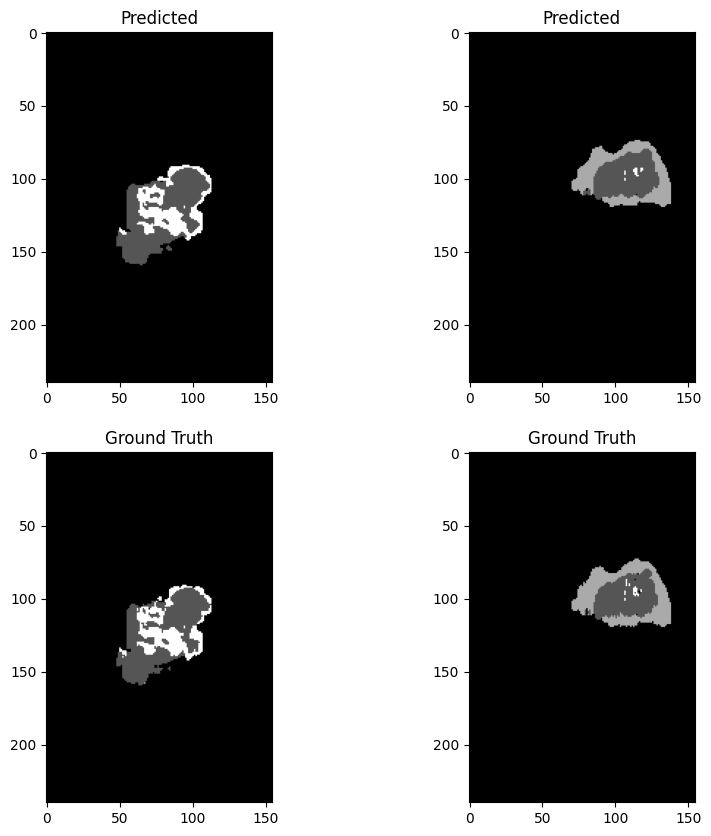

100%|██████████| 246/246 [08:35<00:00,  2.09s/it]



Average Training Loss: 0.0035218264991833973

Average Training DSC: [0.99959358 0.95993941 0.9611906  0.90708094]
Average Training ASSD: [0.03709489 3.77884753 6.43155954 7.56035906]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


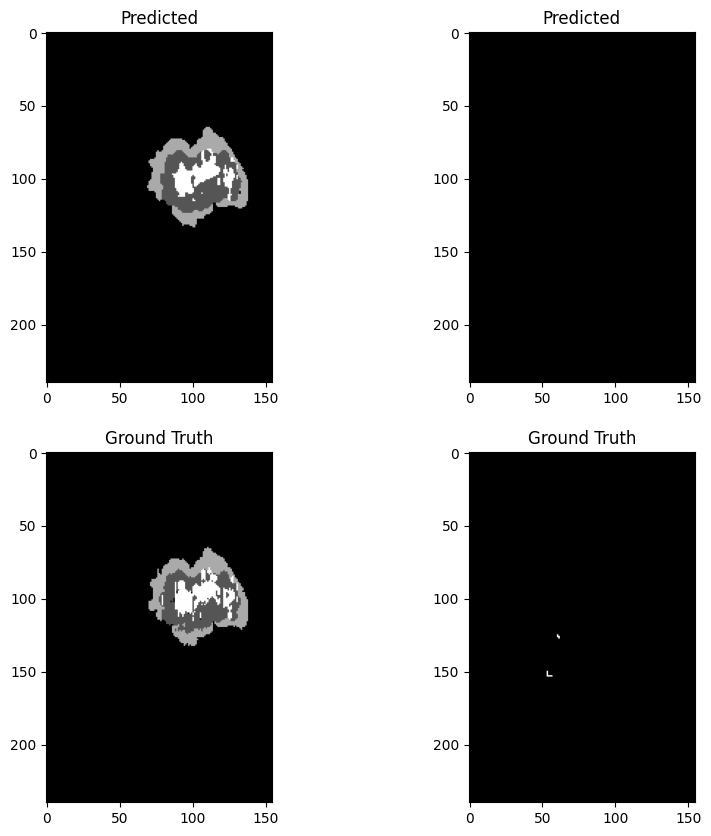

100%|██████████| 62/62 [01:32<00:00,  1.50s/it]


Average Validation Loss: 0.005893217365918381

Average Validation DSC: [0.99936338 0.93655877 0.9482528  0.87193791]
Average Validation ASSD: [ 0.06428126  7.2981544   7.70040479 10.01155079]
Epoch 71/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


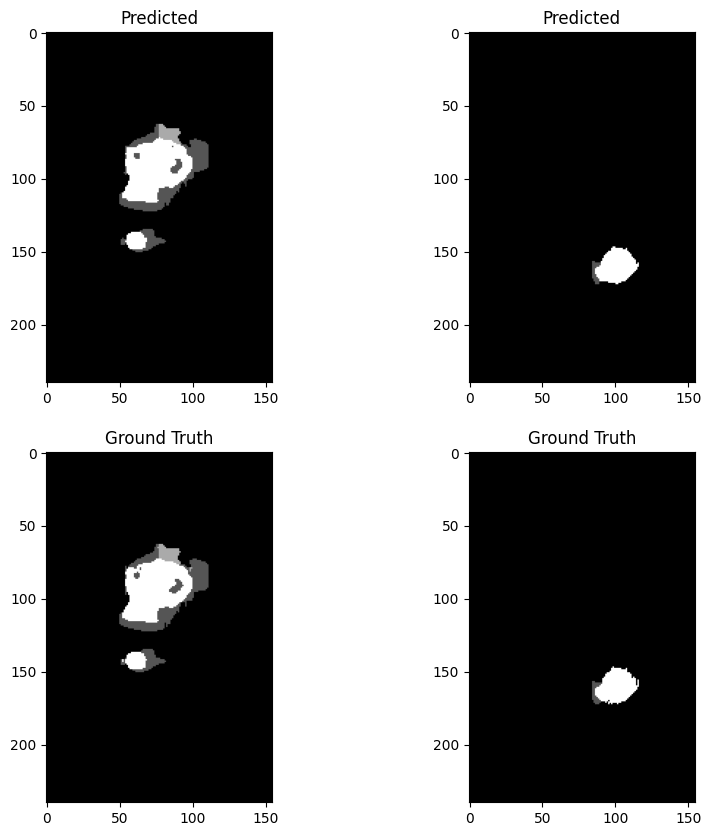

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.003283625309605424

Average Training DSC: [0.99961332 0.9609125  0.96593731 0.91112395]
Average Training ASSD: [0.03365633 3.77422146 5.97590271 8.06524691]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


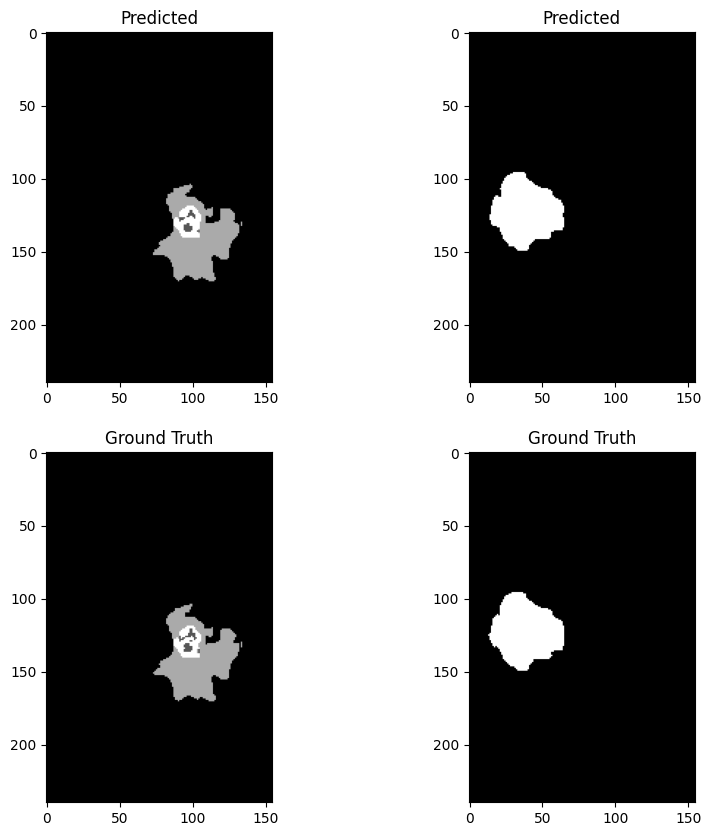

100%|██████████| 62/62 [01:33<00:00,  1.51s/it]


Average Validation Loss: 0.006374251739602656

Average Validation DSC: [0.99930601 0.9245904  0.95033935 0.86362853]
Average Validation ASSD: [0.07243257 9.28423393 6.25253316 6.82782808]
Epoch 72/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


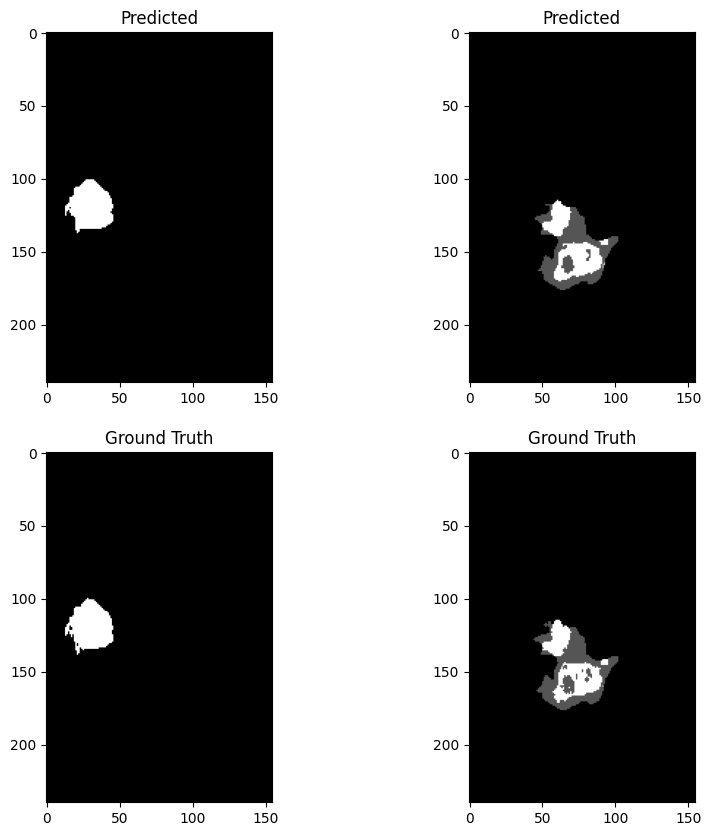

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.004348725093740637

Average Training DSC: [0.99949263 0.94574935 0.9476285  0.89097275]
Average Training ASSD: [ 0.04648014  7.05846669 10.25380733  8.15665508]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


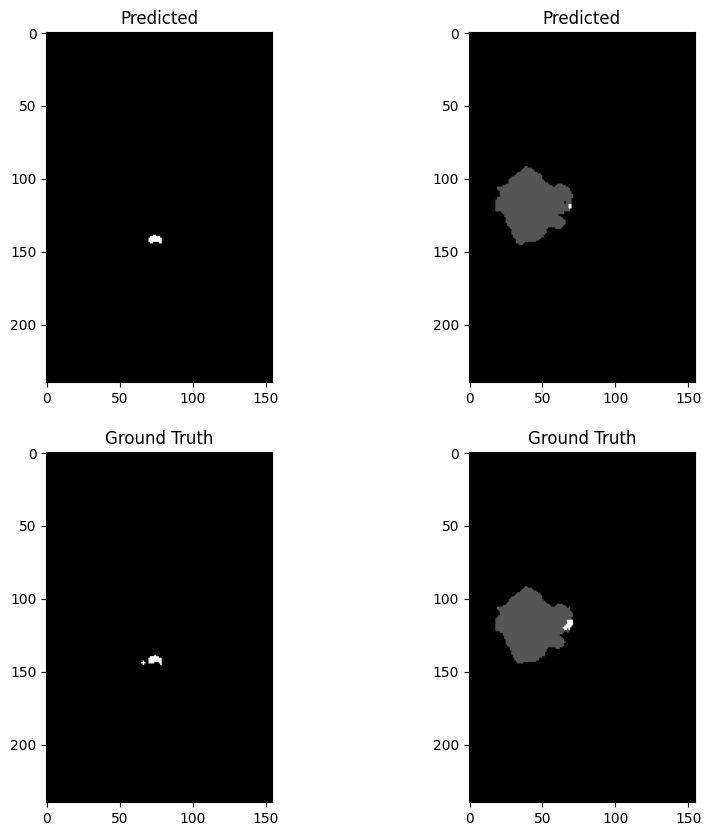

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.005364797209509679

Average Validation DSC: [0.99938128 0.94484043 0.95300248 0.87948192]
Average Validation ASSD: [0.06268678 3.91297697 7.1965527  5.82963644]
Epoch 73/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


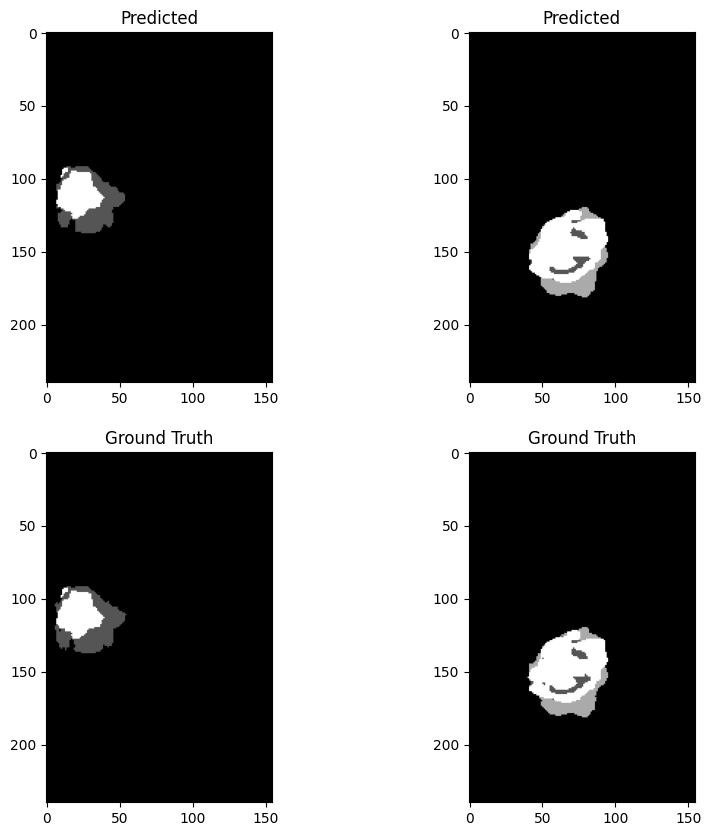

100%|██████████| 246/246 [08:36<00:00,  2.10s/it]



Average Training Loss: 0.0029783235404761584

Average Training DSC: [0.99964965 0.96536084 0.97218633 0.91662881]
Average Training ASSD: [0.03082314 2.95609571 4.13261538 7.8569944 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


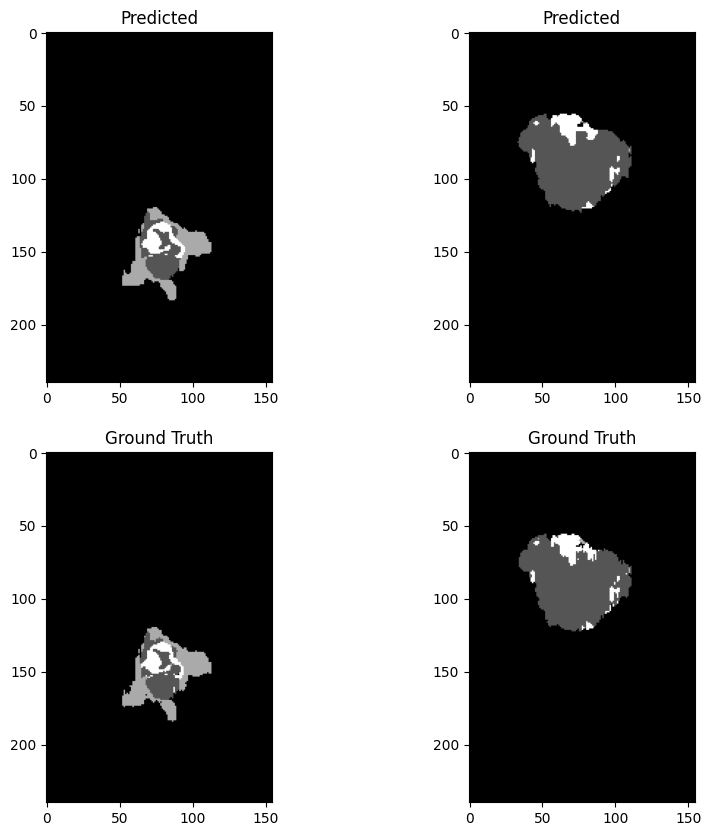

100%|██████████| 62/62 [01:30<00:00,  1.45s/it]


Average Validation Loss: 0.005152733857563186

Average Validation DSC: [0.99949128 0.95013639 0.96398534 0.8898224 ]
Average Validation ASSD: [0.05098992 5.05404455 4.01283549 7.26457909]
Epoch 74/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


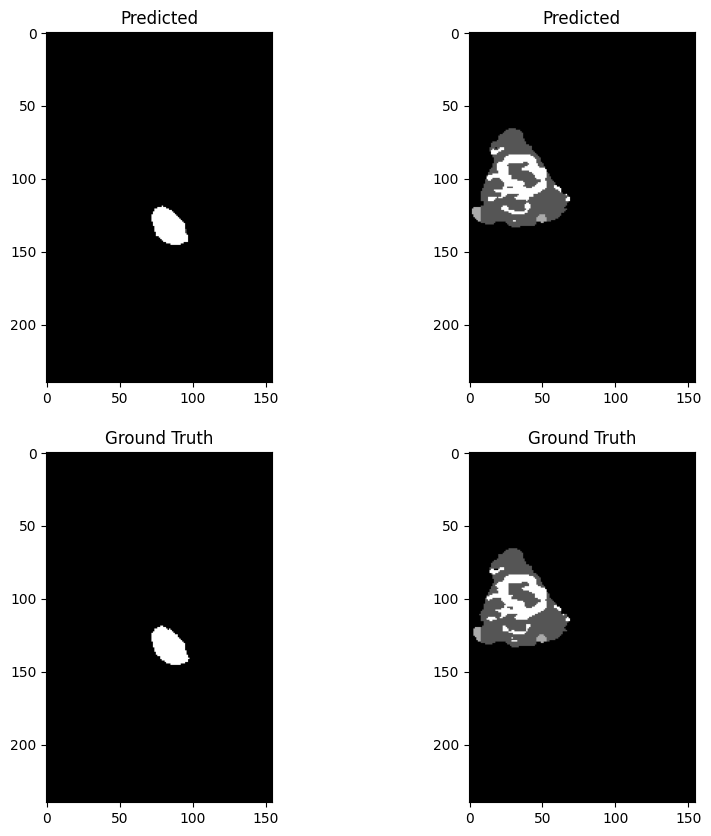

100%|██████████| 246/246 [08:44<00:00,  2.13s/it]



Average Training Loss: 0.0025109292090325277

Average Training DSC: [0.99971922 0.97319164 0.97590533 0.92901133]
Average Training ASSD: [0.02349814 1.46744667 3.26229326 6.6118654 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


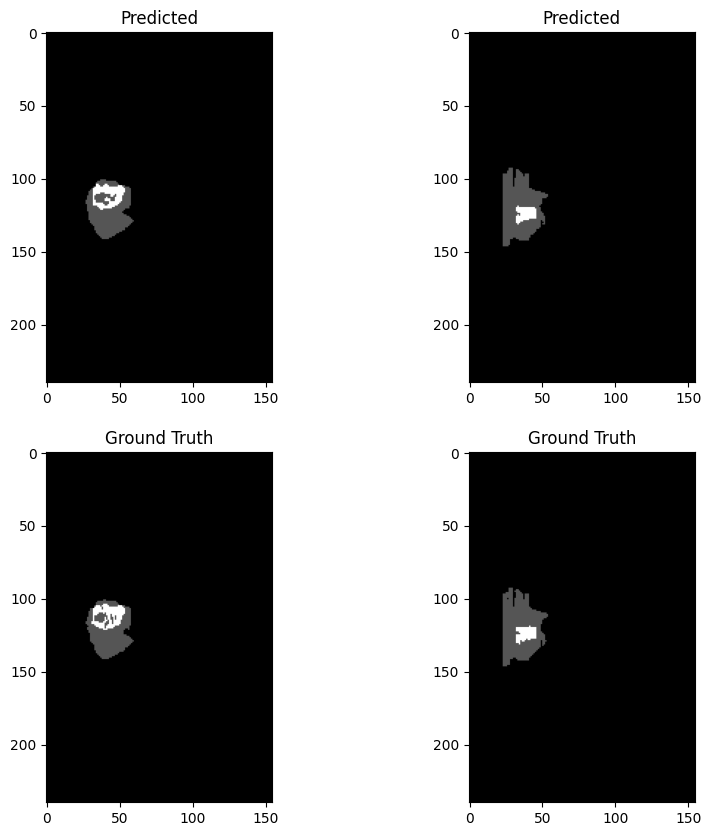

100%|██████████| 62/62 [01:34<00:00,  1.53s/it]


Average Validation Loss: 0.00530364791742496

Average Validation DSC: [0.99948097 0.95365978 0.96241907 0.89257481]
Average Validation ASSD: [0.05094406 3.12581867 4.2727568  7.51975752]
Epoch 75/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


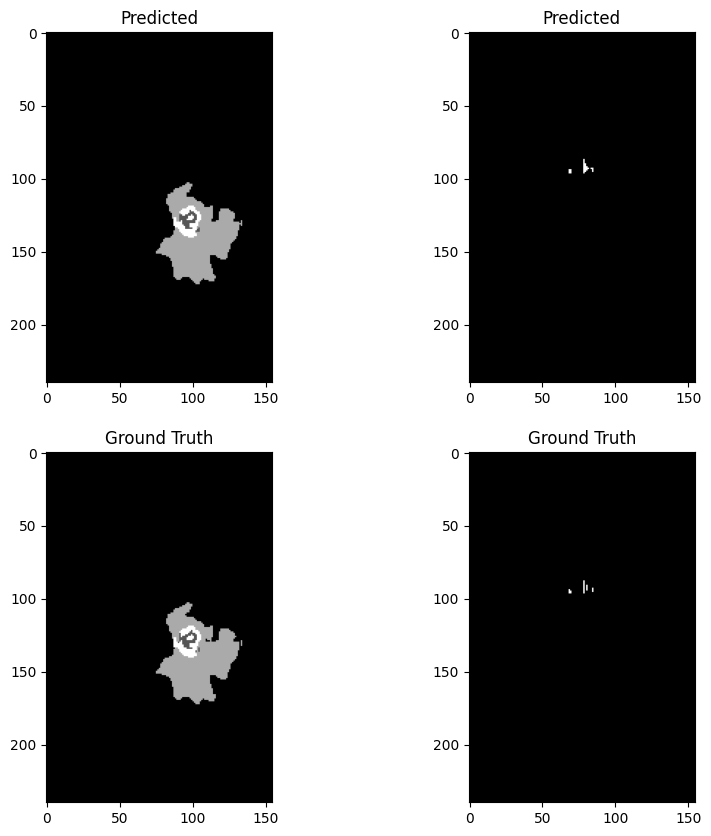

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.0024196094023139496

Average Training DSC: [0.99973167 0.97495972 0.9769676  0.93193265]
Average Training ASSD: [0.02215027 0.91116376 2.89797456 6.58371059]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


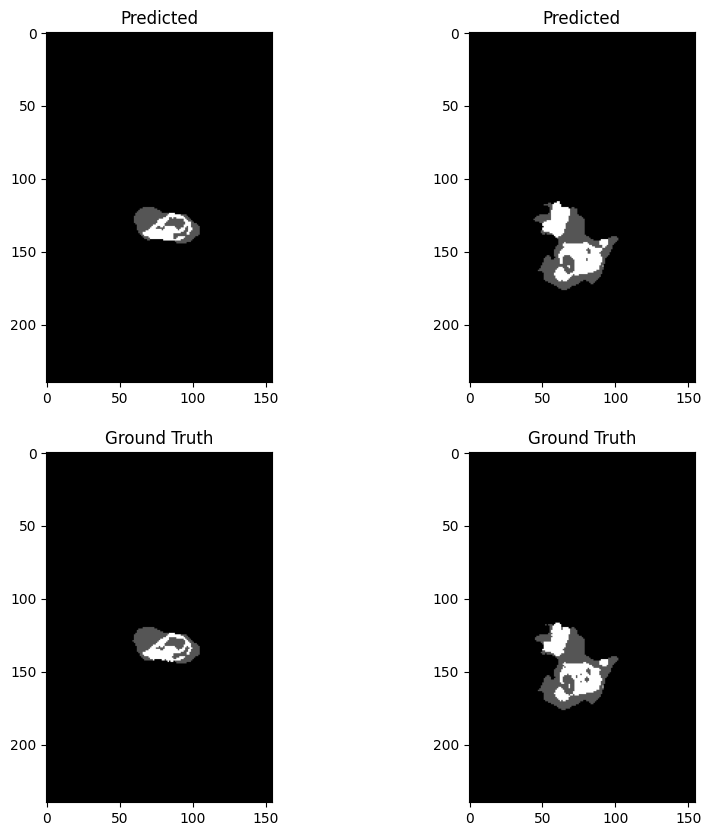

100%|██████████| 62/62 [01:29<00:00,  1.44s/it]


Average Validation Loss: 0.005215788342719597

Average Validation DSC: [0.99951431 0.94977078 0.96148921 0.89832628]
Average Validation ASSD: [0.04783154 3.86451531 4.77015327 5.1049552 ]
Epoch 76/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


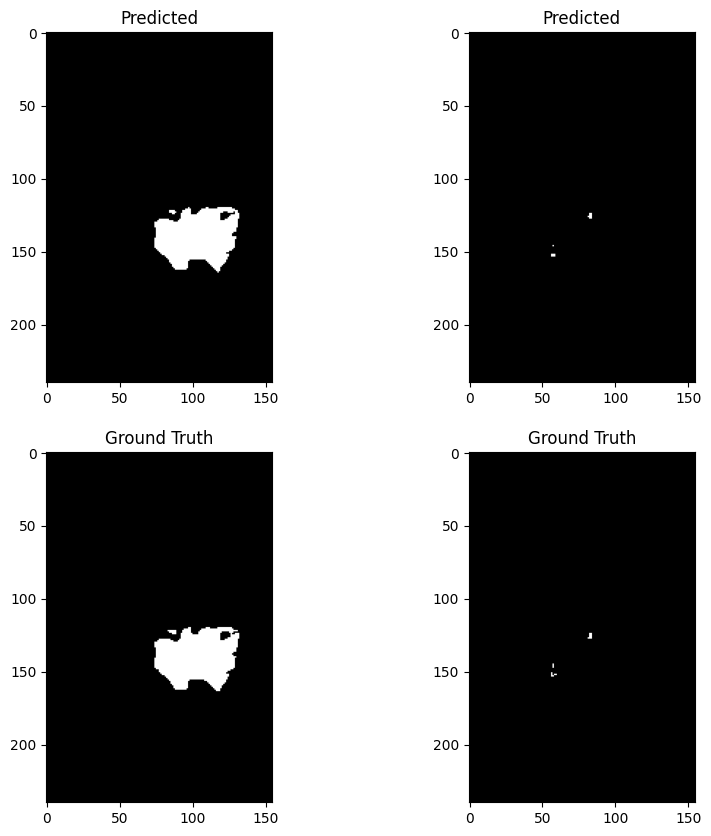

100%|██████████| 246/246 [08:30<00:00,  2.08s/it]



Average Training Loss: 0.0024527856489507164

Average Training DSC: [0.99972514 0.97459721 0.9759135  0.931813  ]
Average Training ASSD: [0.02253637 1.09412089 3.2751079  5.99503146]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


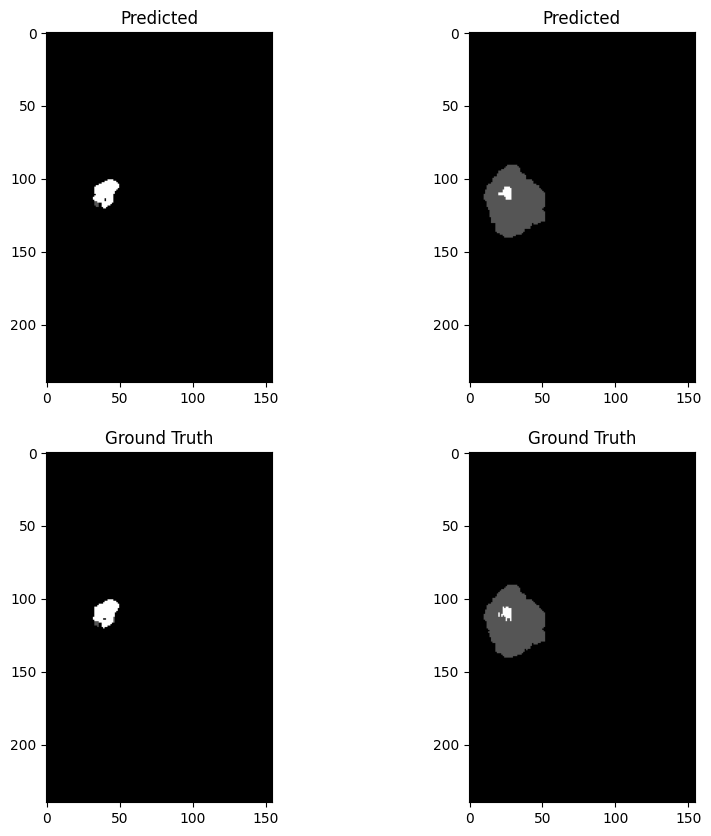

100%|██████████| 62/62 [01:31<00:00,  1.47s/it]


Average Validation Loss: 0.005511668942598326

Average Validation DSC: [0.99948092 0.94994144 0.95619851 0.89581931]
Average Validation ASSD: [0.0486397  3.86837662 5.98972911 6.01688905]
Epoch 77/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


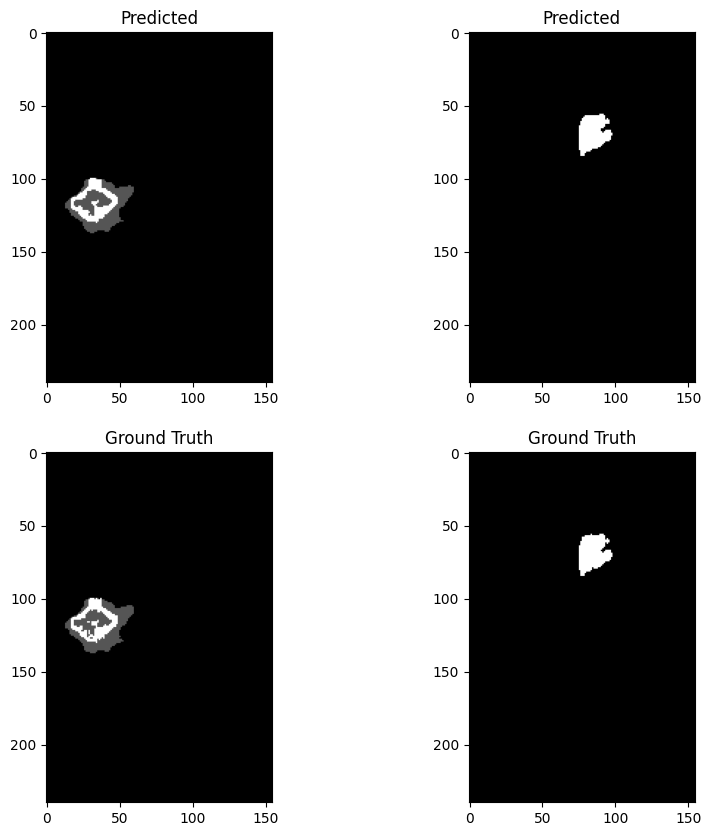

100%|██████████| 246/246 [08:34<00:00,  2.09s/it]



Average Training Loss: 0.002487651079541027

Average Training DSC: [0.99971718 0.97321907 0.97490141 0.93046571]
Average Training ASSD: [0.02317977 1.46280517 3.62745894 6.70322288]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


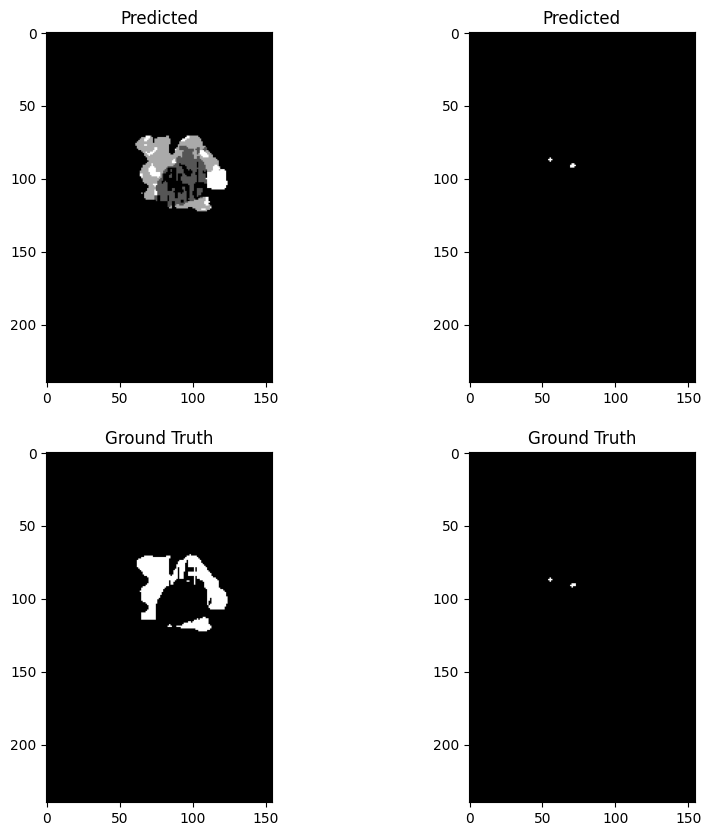

100%|██████████| 62/62 [01:33<00:00,  1.50s/it]


Average Validation Loss: 0.005275226235690136

Average Validation DSC: [0.99950291 0.94810975 0.95972974 0.89202391]
Average Validation ASSD: [0.04629081 4.59623933 5.49444194 6.29495699]
Epoch 78/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


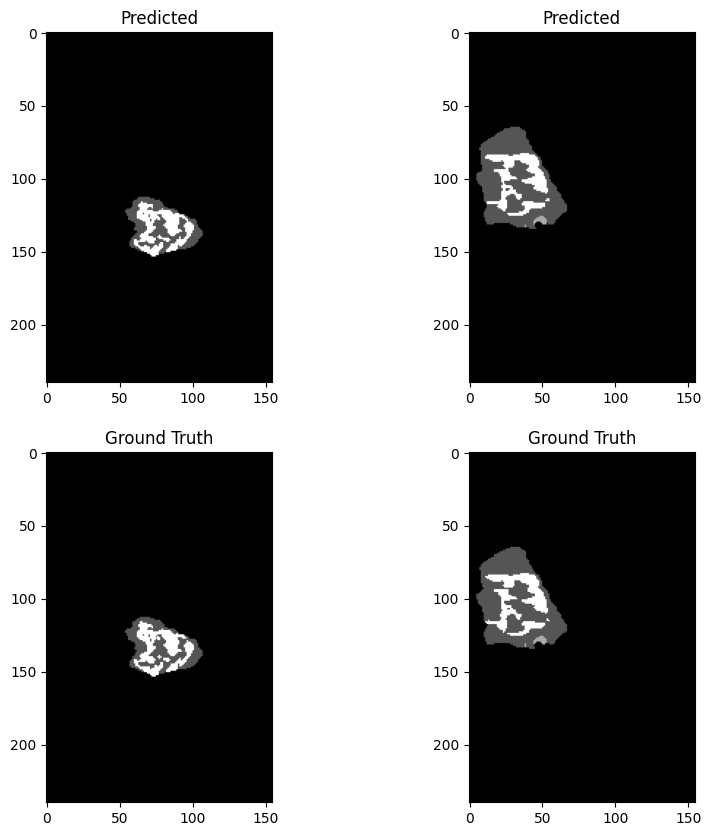

100%|██████████| 246/246 [08:40<00:00,  2.11s/it]



Average Training Loss: 0.0023946350746091487

Average Training DSC: [0.99973023 0.97364284 0.97482082 0.93333749]
Average Training ASSD: [0.02205077 1.58228478 3.80789163 5.98325556]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


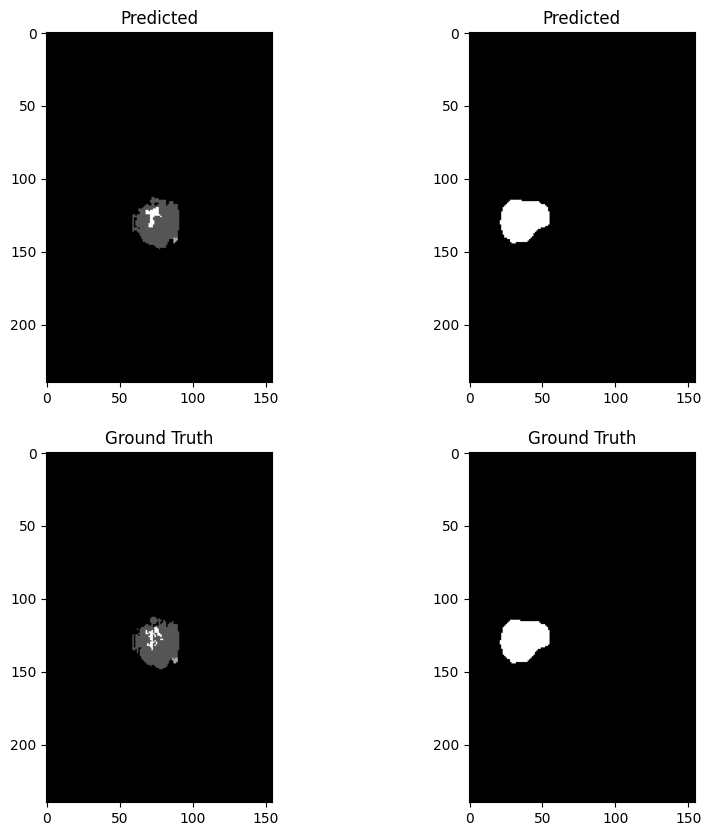

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.0055563155629281555

Average Validation DSC: [0.99950023 0.94831946 0.96309401 0.89776068]
Average Validation ASSD: [0.04586743 3.63566313 3.78010082 4.17055427]
Epoch 79/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


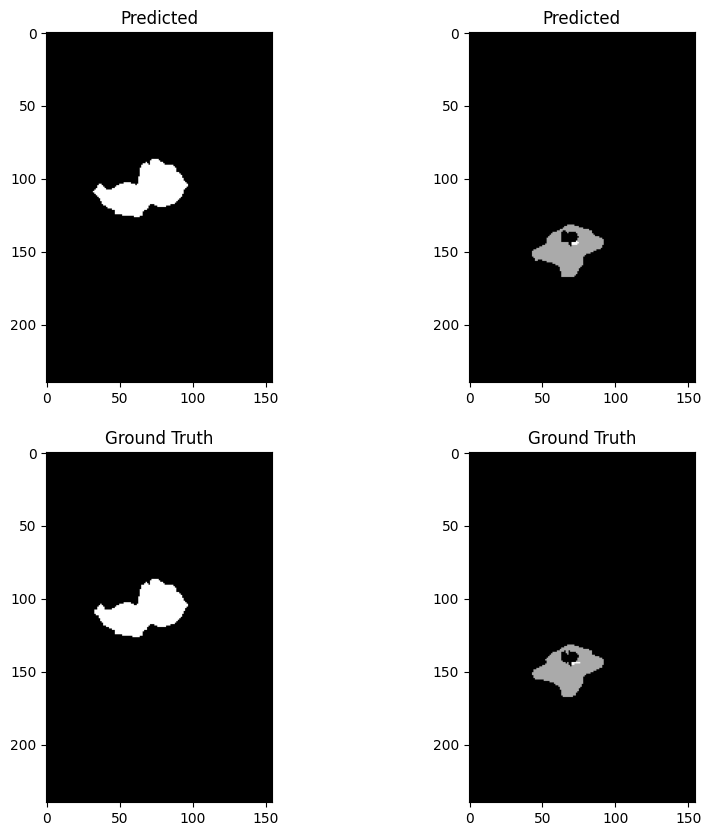

100%|██████████| 246/246 [08:30<00:00,  2.07s/it]



Average Training Loss: 0.0023766542672240213

Average Training DSC: [0.99973324 0.97419591 0.97579423 0.93385338]
Average Training ASSD: [0.02181545 1.33828771 3.56527573 5.67627278]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


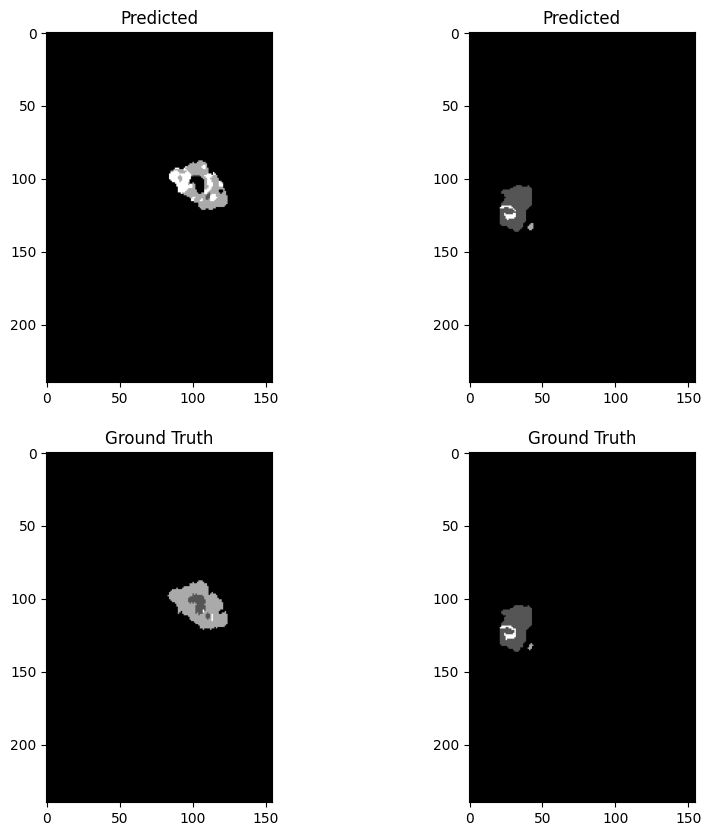

100%|██████████| 62/62 [01:29<00:00,  1.45s/it]


Average Validation Loss: 0.005358612217429665

Average Validation DSC: [0.99949842 0.95055386 0.96353947 0.89333895]
Average Validation ASSD: [0.04815792 3.14211651 4.01096039 6.55807069]
Epoch 80/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


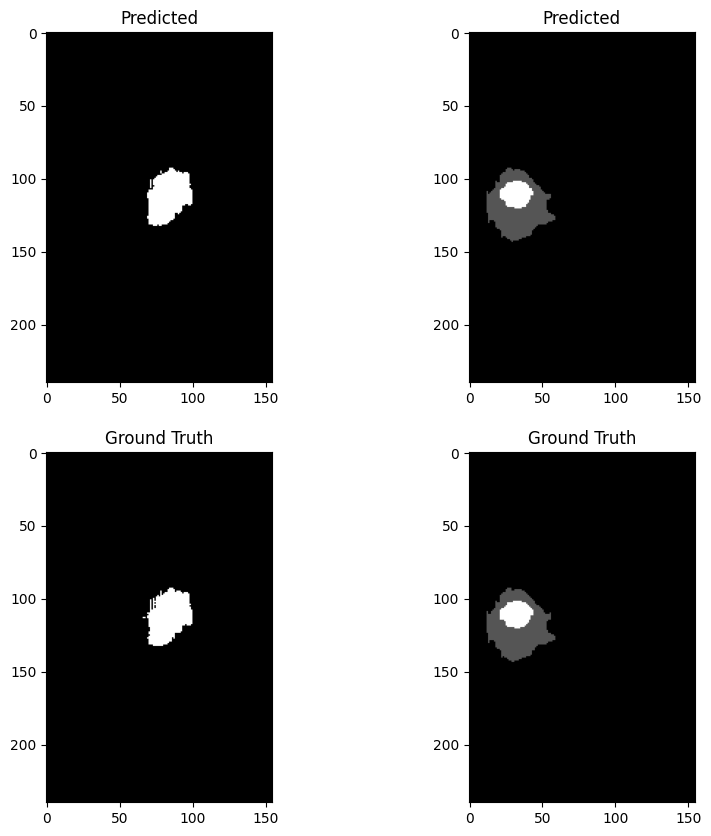

100%|██████████| 246/246 [08:37<00:00,  2.10s/it]



Average Training Loss: 0.002401788169574901

Average Training DSC: [0.99973588 0.97340618 0.97541551 0.93552769]
Average Training ASSD: [0.02120771 1.58403707 3.62061091 5.37360488]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


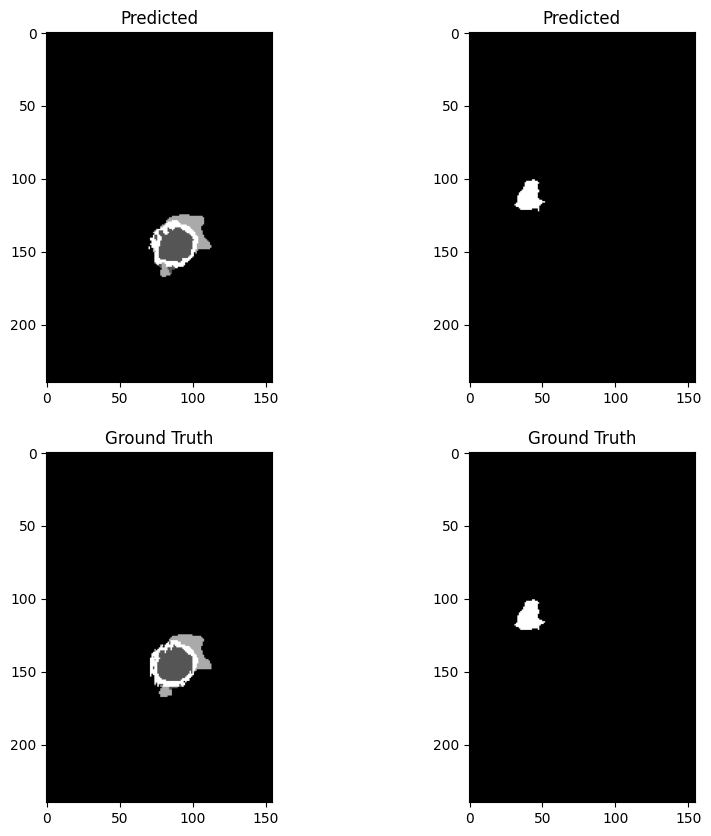

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.005241029854533413

Average Validation DSC: [0.99952321 0.9520389  0.95822701 0.8994814 ]
Average Validation ASSD: [0.04498781 3.85222629 5.95605194 5.79075407]
Epoch 81/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


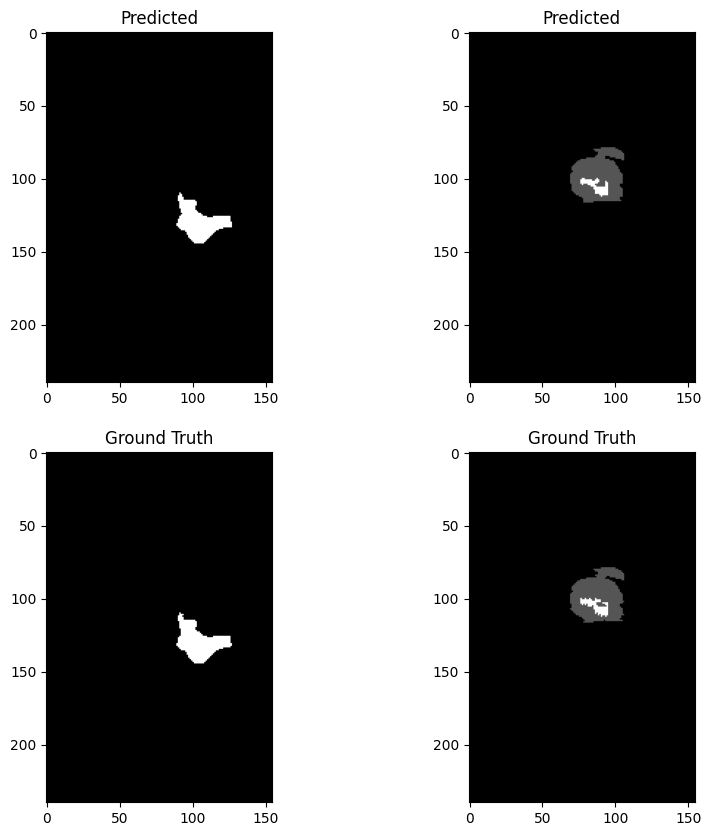

100%|██████████| 246/246 [08:35<00:00,  2.09s/it]



Average Training Loss: 0.002320256418779462

Average Training DSC: [0.99974439 0.97503283 0.97640323 0.93682272]
Average Training ASSD: [0.02047575 1.21108403 3.07871735 5.00539872]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


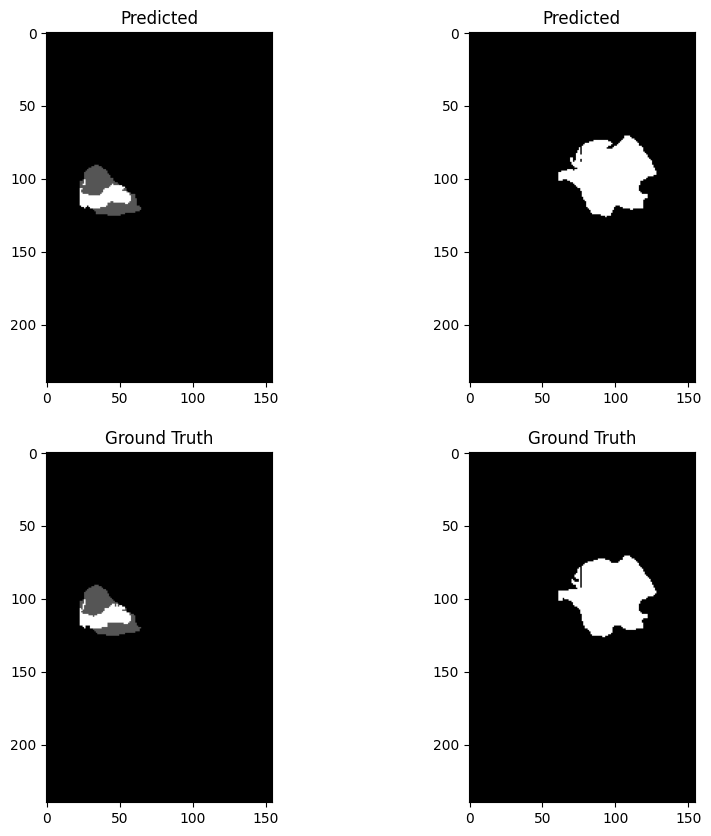

100%|██████████| 62/62 [01:30<00:00,  1.46s/it]


Average Validation Loss: 0.0054312300560395085

Average Validation DSC: [0.99950012 0.95167221 0.95839776 0.89432395]
Average Validation ASSD: [0.04689865 3.62897164 5.97743904 7.04978326]
Epoch 82/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


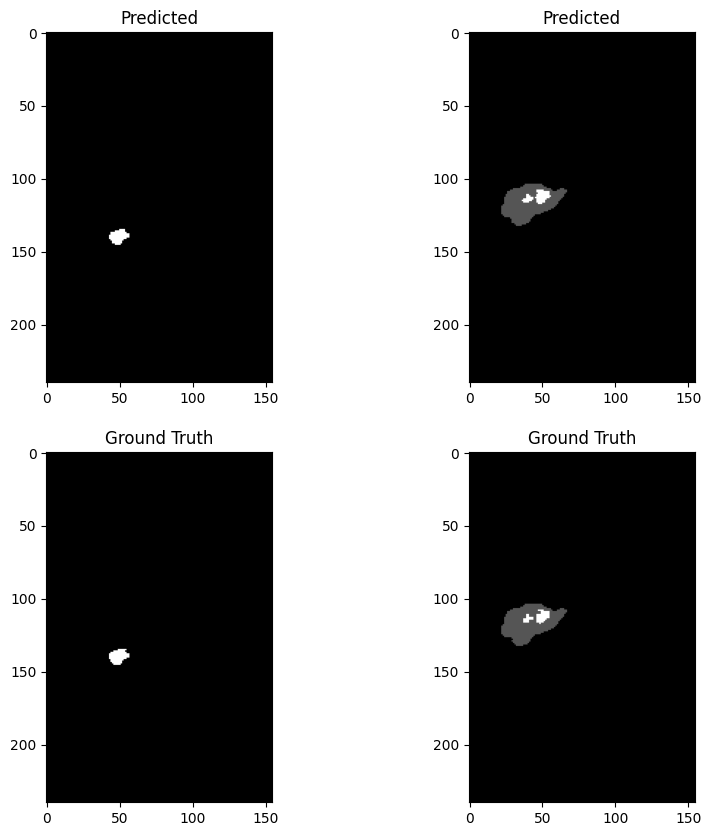

100%|██████████| 246/246 [08:40<00:00,  2.12s/it]



Average Training Loss: 0.002313569167295728

Average Training DSC: [0.9997418  0.97460018 0.97579177 0.93764562]
Average Training ASSD: [0.02079408 1.5160855  3.55411701 5.53937784]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


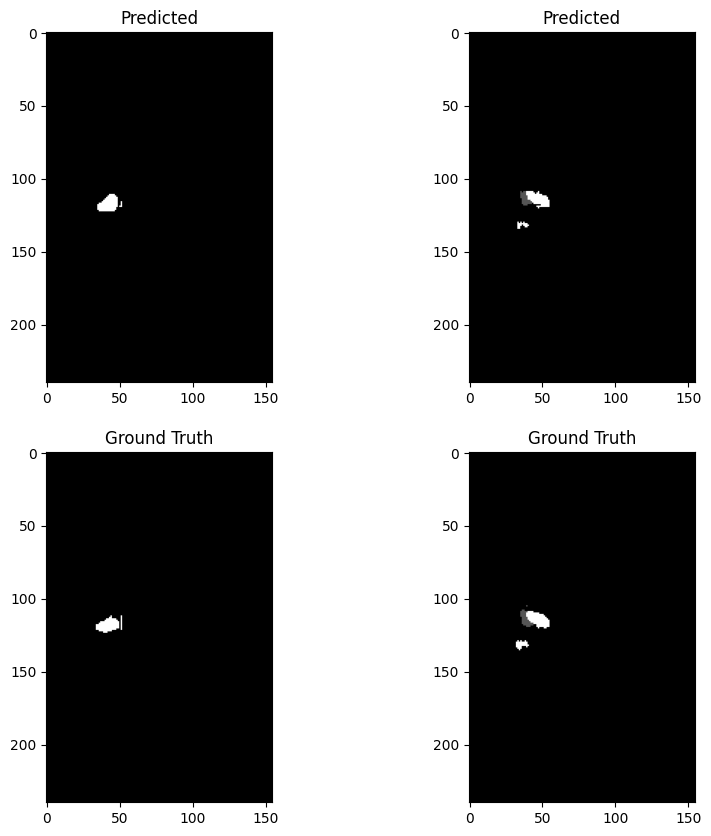

100%|██████████| 62/62 [01:32<00:00,  1.49s/it]


Average Validation Loss: 0.00512187036069771

Average Validation DSC: [0.99951278 0.94569896 0.95791643 0.8885736 ]
Average Validation ASSD: [0.04472996 6.05613082 6.20143876 7.04133342]
Epoch 83/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


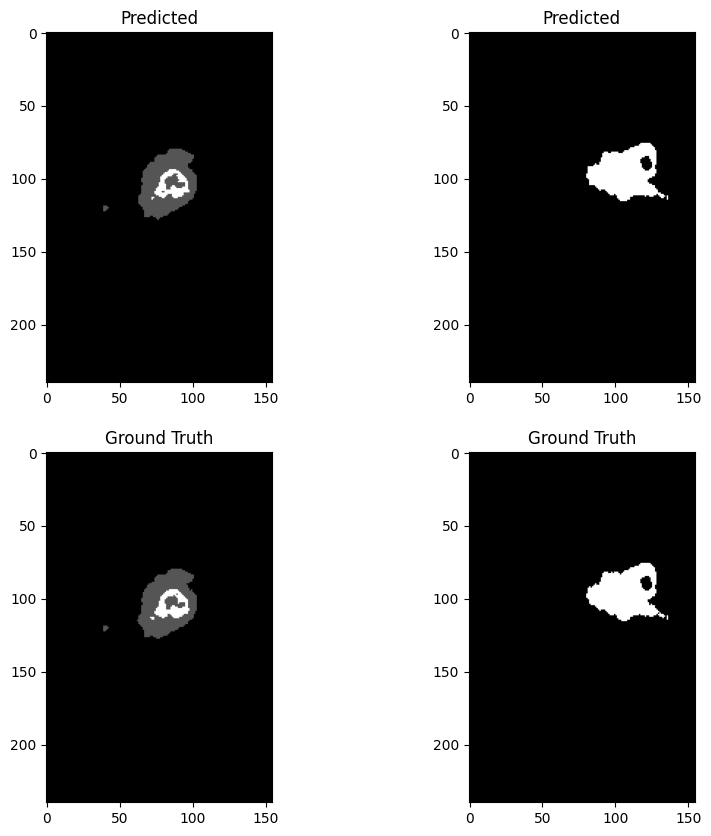

100%|██████████| 246/246 [08:33<00:00,  2.09s/it]



Average Training Loss: 0.0022406562783270773

Average Training DSC: [0.99975678 0.97587068 0.9747585  0.93949411]
Average Training ASSD: [0.0196669  1.38964827 4.12724185 4.55540351]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


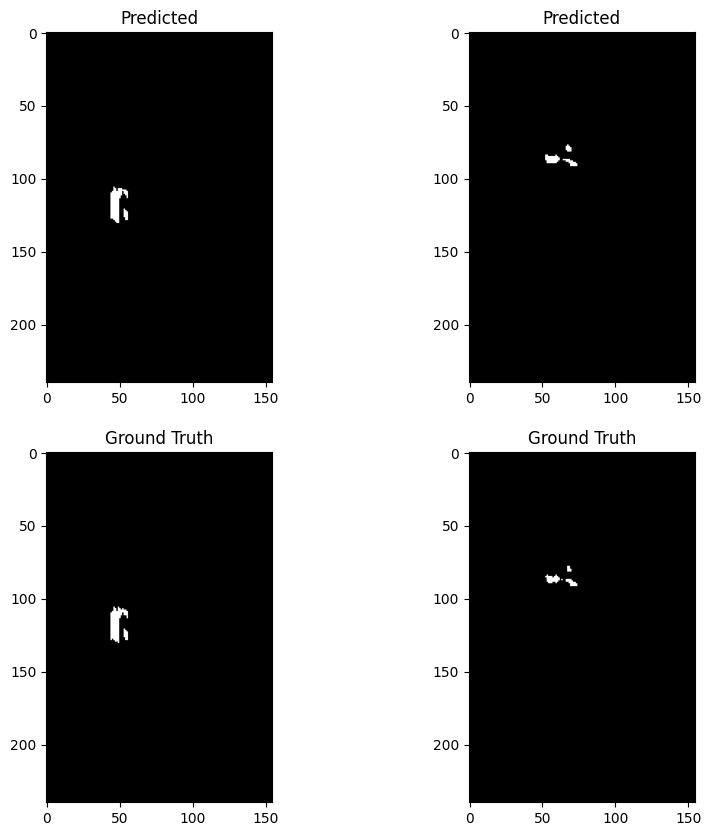

100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Average Validation Loss: 0.005442436720665184

Average Validation DSC: [0.99951386 0.94633417 0.95986969 0.89725314]
Average Validation ASSD: [0.0457018  5.56898106 4.99029702 6.49981306]
Epoch 84/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


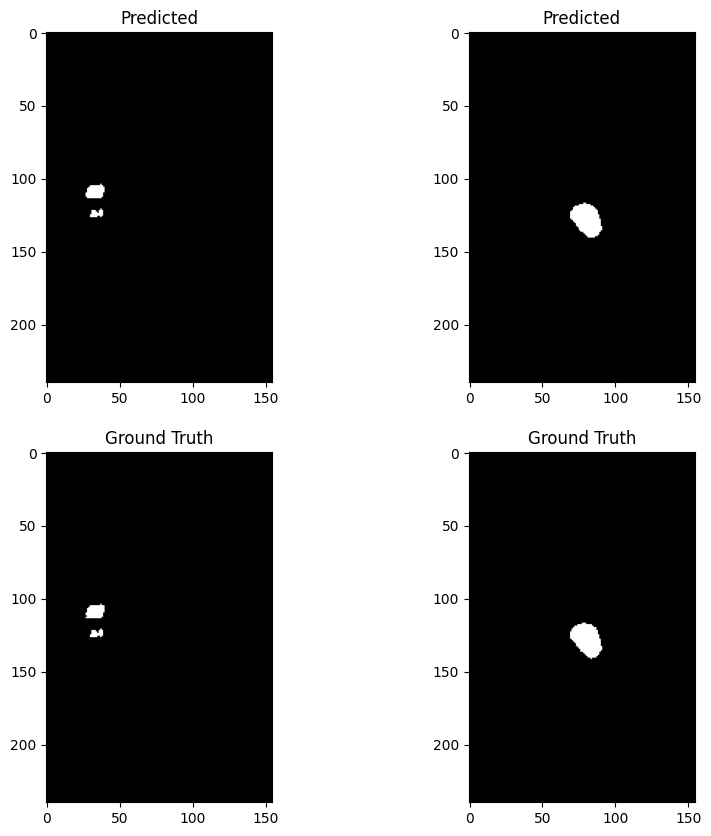

100%|██████████| 246/246 [07:32<00:00,  1.84s/it]



Average Training Loss: 0.0021865887305229843

Average Training DSC: [0.99975676 0.97635225 0.97625402 0.94154085]
Average Training ASSD: [0.01984261 1.32679076 3.80433163 4.68695264]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


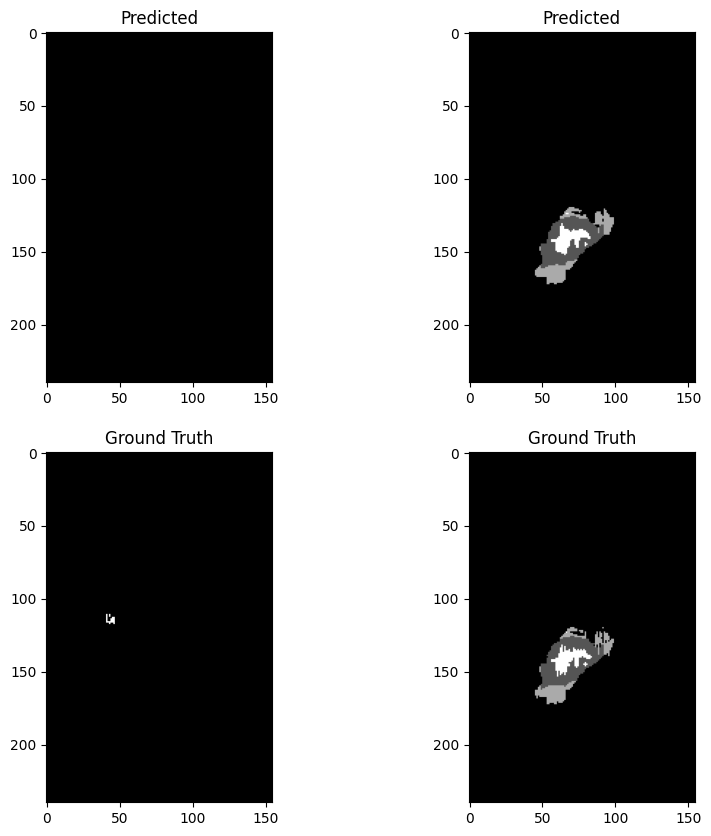

100%|██████████| 62/62 [01:16<00:00,  1.23s/it]


Average Validation Loss: 0.005131759425444949

Average Validation DSC: [0.99951774 0.95393685 0.96227751 0.9018562 ]
Average Validation ASSD: [0.04435504 2.88085848 4.97707037 4.86535647]
Epoch 85/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


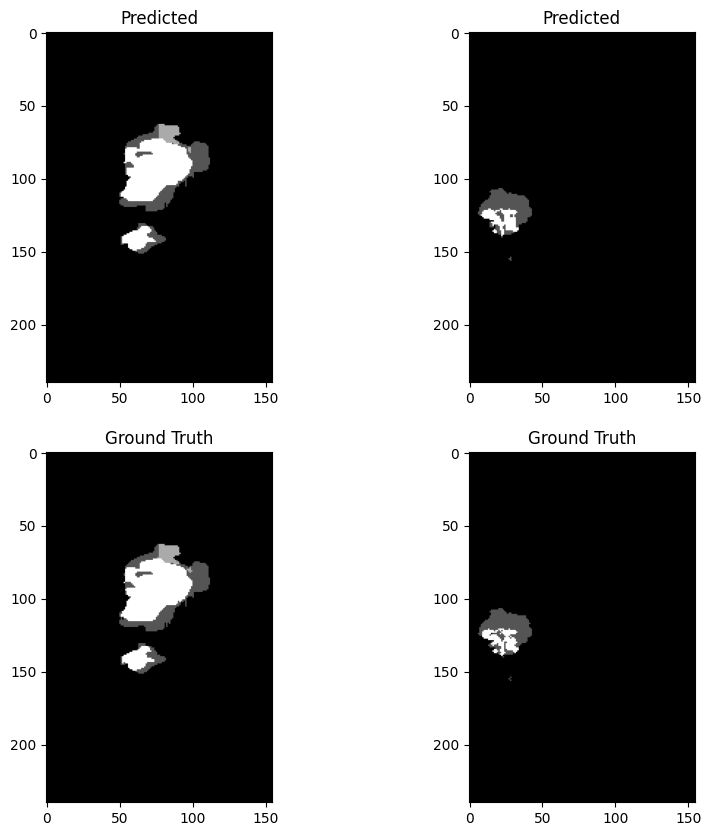

100%|██████████| 246/246 [07:35<00:00,  1.85s/it]



Average Training Loss: 0.0022242871752932544

Average Training DSC: [0.9997527  0.97500287 0.97551755 0.94184945]
Average Training ASSD: [0.02032174 1.69430883 3.26000013 4.50705645]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


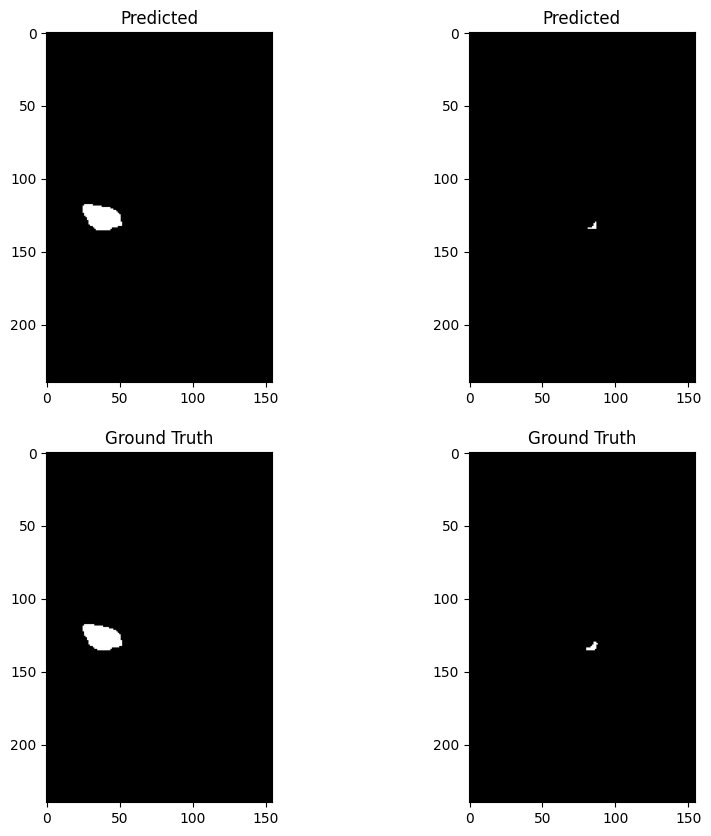

100%|██████████| 62/62 [01:21<00:00,  1.31s/it]


Average Validation Loss: 0.005044374194356703

Average Validation DSC: [0.99953528 0.94295773 0.95889847 0.90576257]
Average Validation ASSD: [0.04245326 7.24828952 5.94744778 4.28800272]
Epoch 86/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


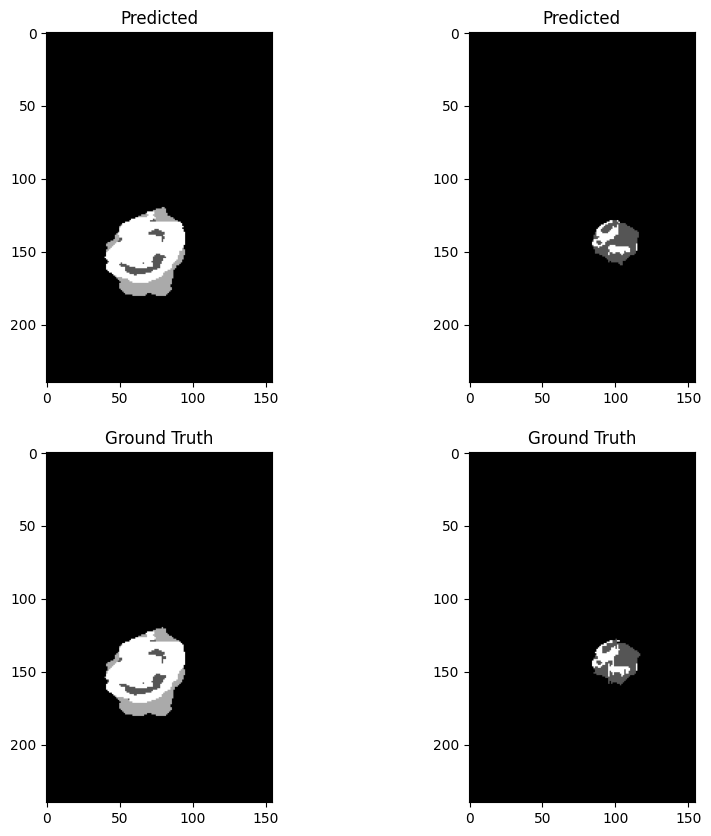

100%|██████████| 246/246 [07:32<00:00,  1.84s/it]



Average Training Loss: 0.0021498515493069905

Average Training DSC: [0.99976525 0.97528356 0.97542804 0.94266153]
Average Training ASSD: [0.01885254 1.69212611 3.74649989 4.79282088]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


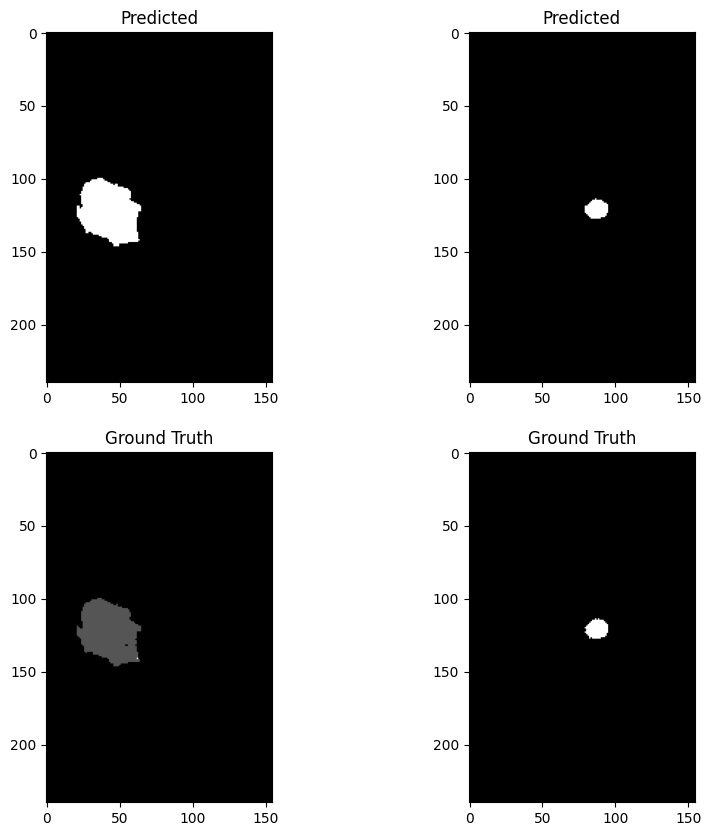

100%|██████████| 62/62 [01:19<00:00,  1.29s/it]


Average Validation Loss: 0.005131310490410655

Average Validation DSC: [0.99954062 0.95556557 0.96078667 0.90455734]
Average Validation ASSD: [0.04403947 3.36130252 5.47867287 5.55774954]
Epoch 87/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


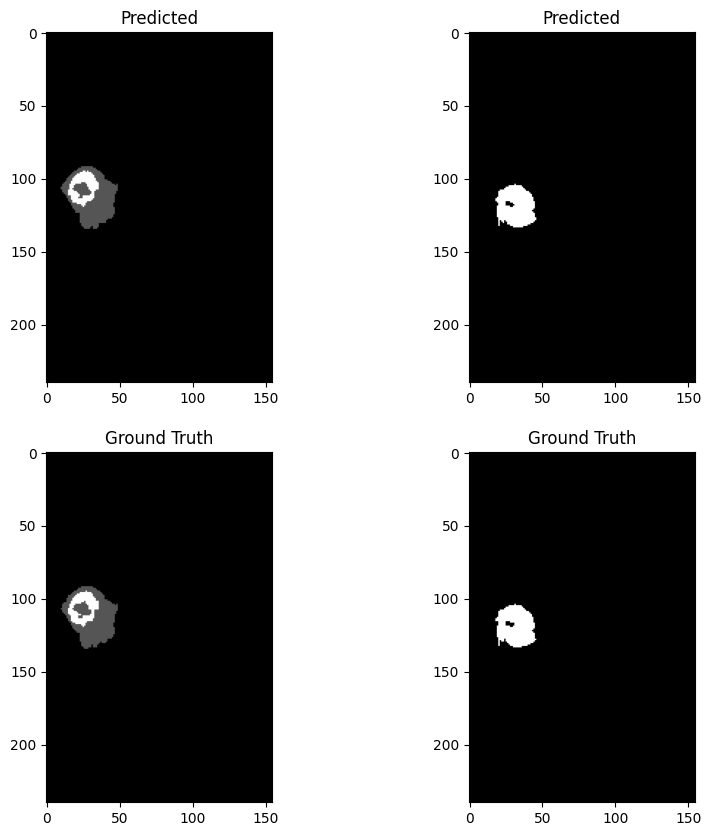

100%|██████████| 246/246 [07:31<00:00,  1.84s/it]



Average Training Loss: 0.0020444320469367797

Average Training DSC: [0.99977606 0.97680737 0.97750048 0.94543501]
Average Training ASSD: [0.01813247 1.50602012 3.25215265 4.19160534]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


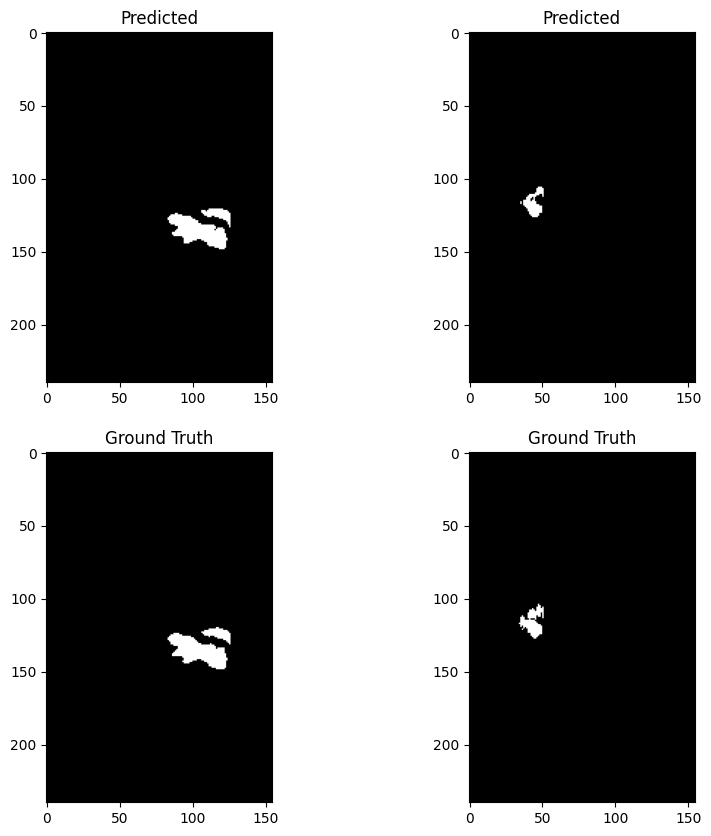

100%|██████████| 62/62 [01:19<00:00,  1.29s/it]


Average Validation Loss: 0.005019877087174644

Average Validation DSC: [0.9995445  0.94695762 0.9580115  0.90648154]
Average Validation ASSD: [0.04410998 6.52244421 6.92351305 5.25603293]
Epoch 88/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


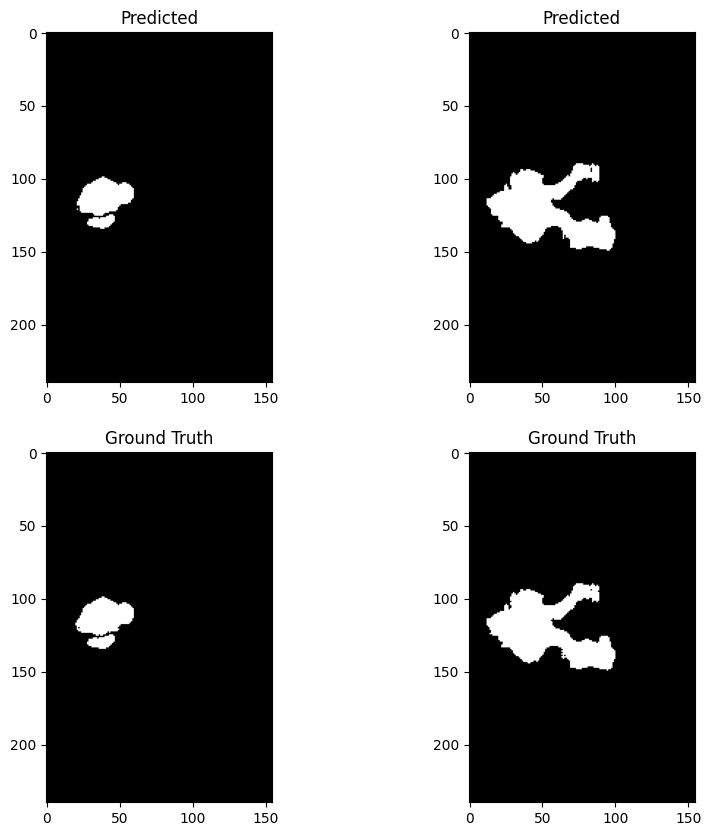

100%|██████████| 246/246 [07:26<00:00,  1.82s/it]



Average Training Loss: 0.0021285813233656125

Average Training DSC: [0.9997667  0.97656444 0.9758941  0.94283713]
Average Training ASSD: [0.01895123 1.51081139 3.68189703 4.72594454]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


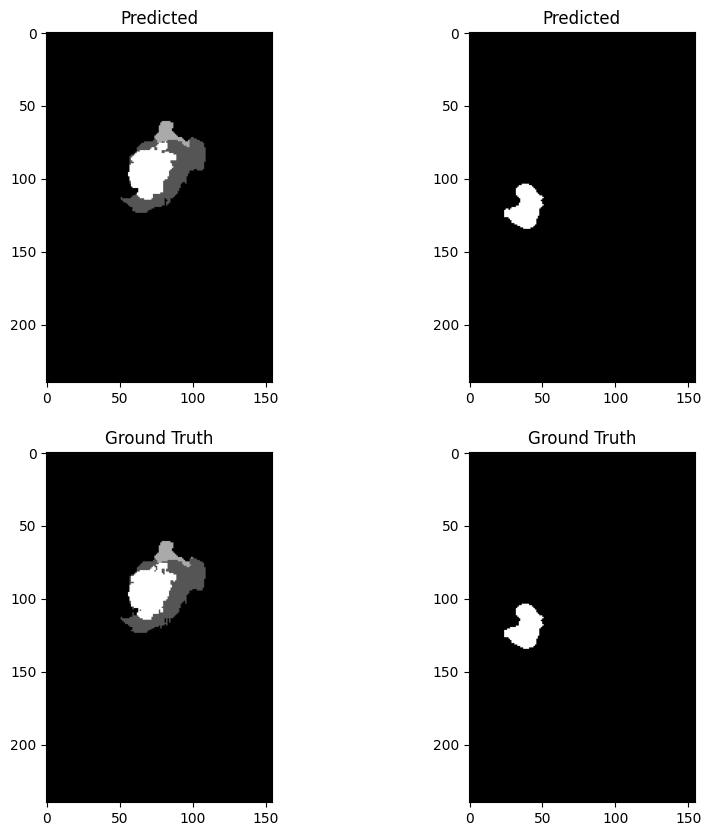

100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Average Validation Loss: 0.004992946058571819

Average Validation DSC: [0.99954132 0.95059264 0.95741006 0.90385829]
Average Validation ASSD: [0.04367088 5.29272672 7.17345877 5.09050094]
Epoch 89/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


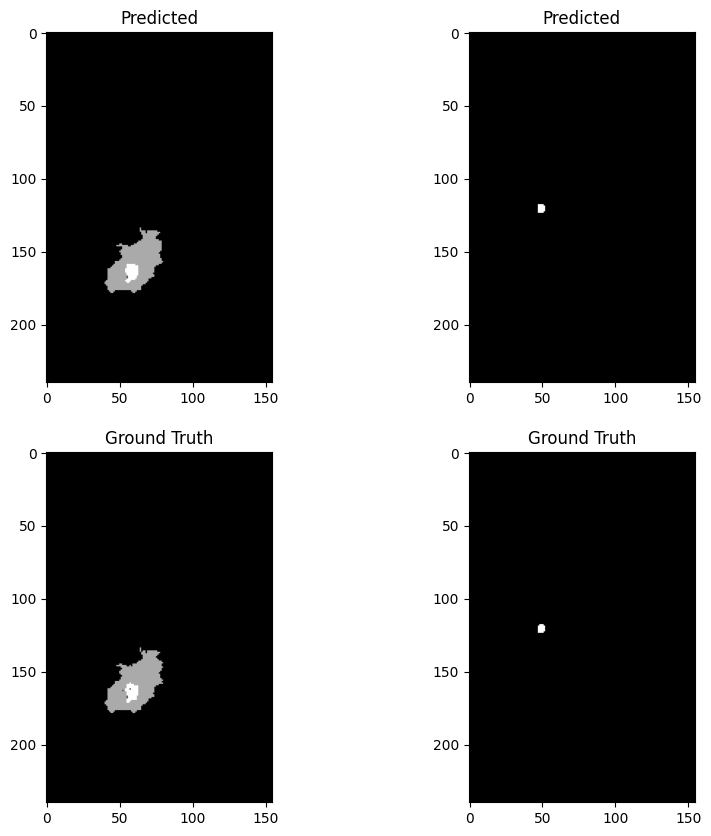

100%|██████████| 246/246 [07:29<00:00,  1.83s/it]



Average Training Loss: 0.002002994647737956

Average Training DSC: [0.99978078 0.97720625 0.97770155 0.94694164]
Average Training ASSD: [0.01818776 1.68293976 3.3120211  3.82243105]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


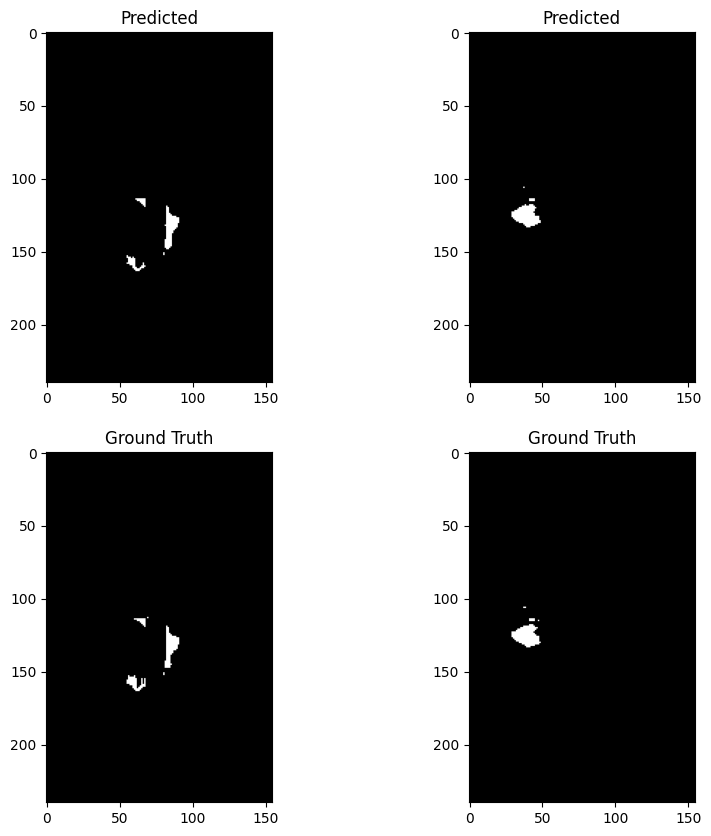

100%|██████████| 62/62 [01:17<00:00,  1.25s/it]


Average Validation Loss: 0.004980989412644938

Average Validation DSC: [0.99955422 0.9523876  0.95618299 0.90531025]
Average Validation ASSD: [0.04398615 4.5760088  7.6571689  5.9744846 ]
Epoch 90/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


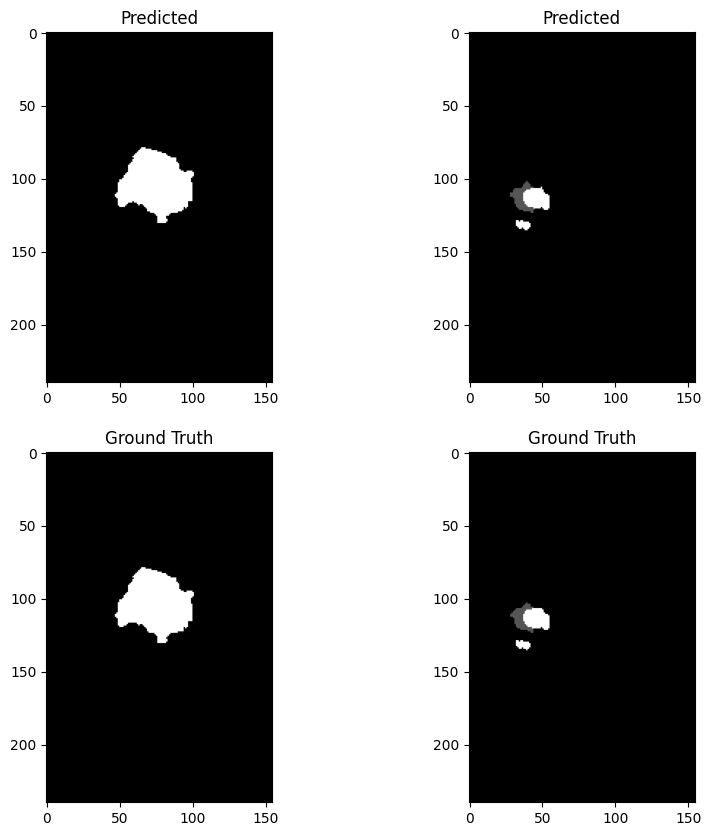

100%|██████████| 246/246 [07:35<00:00,  1.85s/it]



Average Training Loss: 0.001932554638365329

Average Training DSC: [0.99979434 0.97780039 0.97887398 0.94726992]
Average Training ASSD: [0.01664844 1.55814008 3.30846478 4.34295398]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


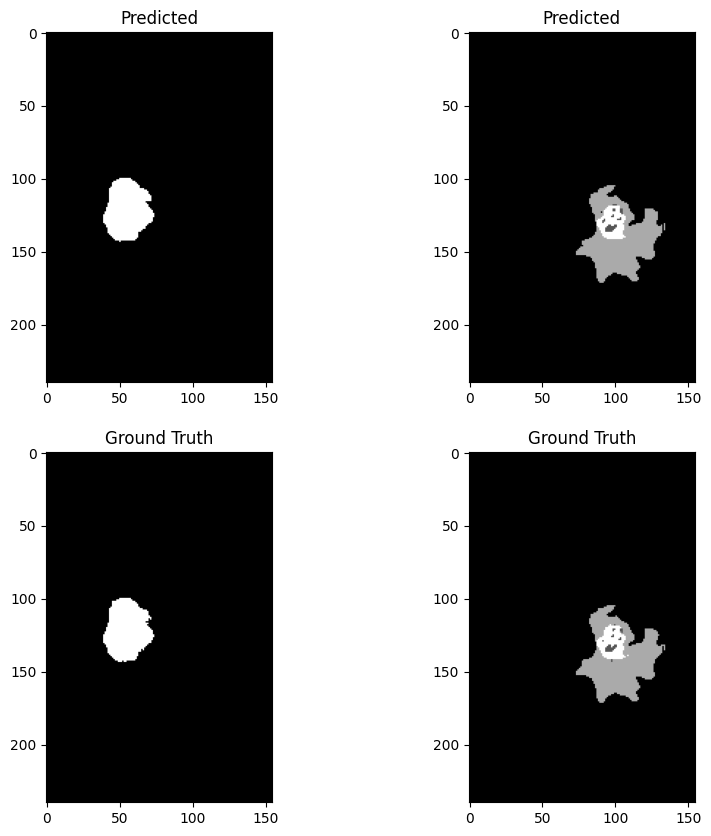

100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


Average Validation Loss: 0.005121464315321176

Average Validation DSC: [0.99954819 0.94706813 0.95512433 0.89435825]
Average Validation ASSD: [0.04352587 5.80170201 8.13705378 6.79009946]
Epoch 91/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


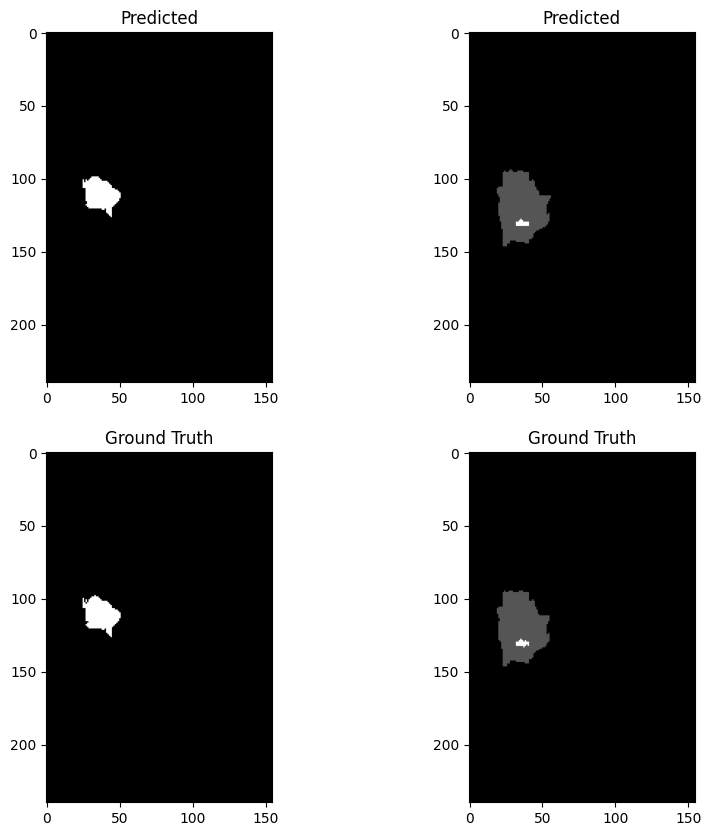

100%|██████████| 246/246 [07:36<00:00,  1.86s/it]



Average Training Loss: 0.0021399878835252567

Average Training DSC: [0.99976496 0.9757167  0.97187453 0.94413133]
Average Training ASSD: [0.01960858 1.75005069 4.79904583 4.24966641]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


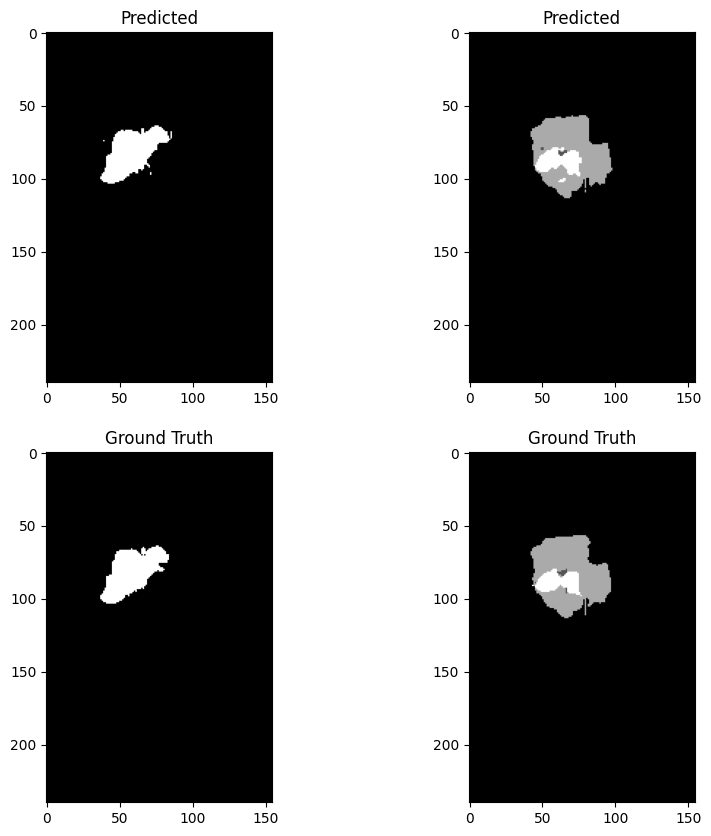

100%|██████████| 62/62 [01:16<00:00,  1.24s/it]


Average Validation Loss: 0.005269355407255071

Average Validation DSC: [0.99953117 0.95086958 0.95855511 0.89964371]
Average Validation ASSD: [0.04563601 3.63025652 6.20094365 4.46368367]
Epoch 92/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


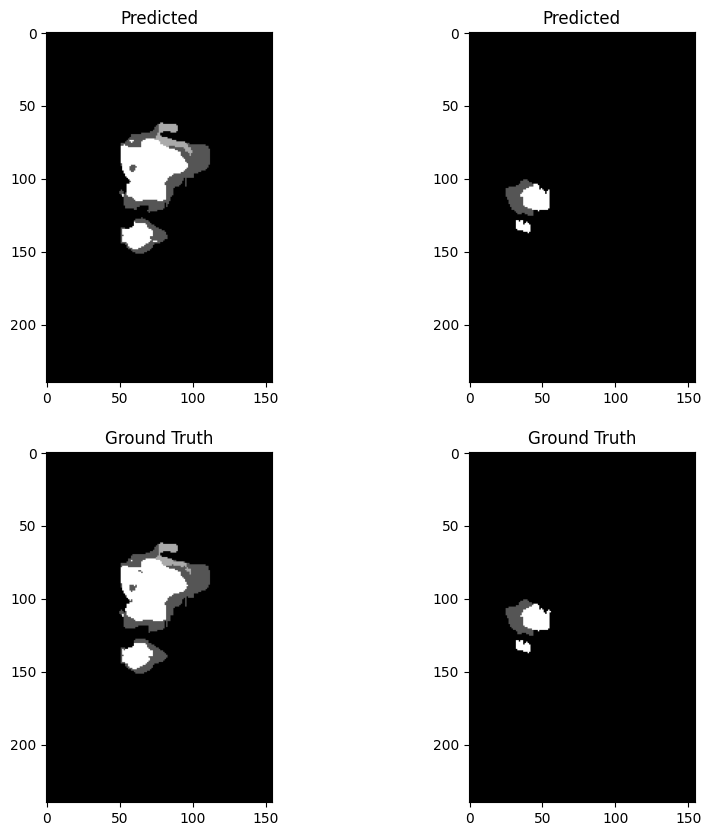

100%|██████████| 246/246 [07:32<00:00,  1.84s/it]



Average Training Loss: 0.005449352882957707

Average Training DSC: [0.99938665 0.90574608 0.93761051 0.87301837]
Average Training ASSD: [ 0.06517083 19.38328226 13.42064794  7.16067689]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


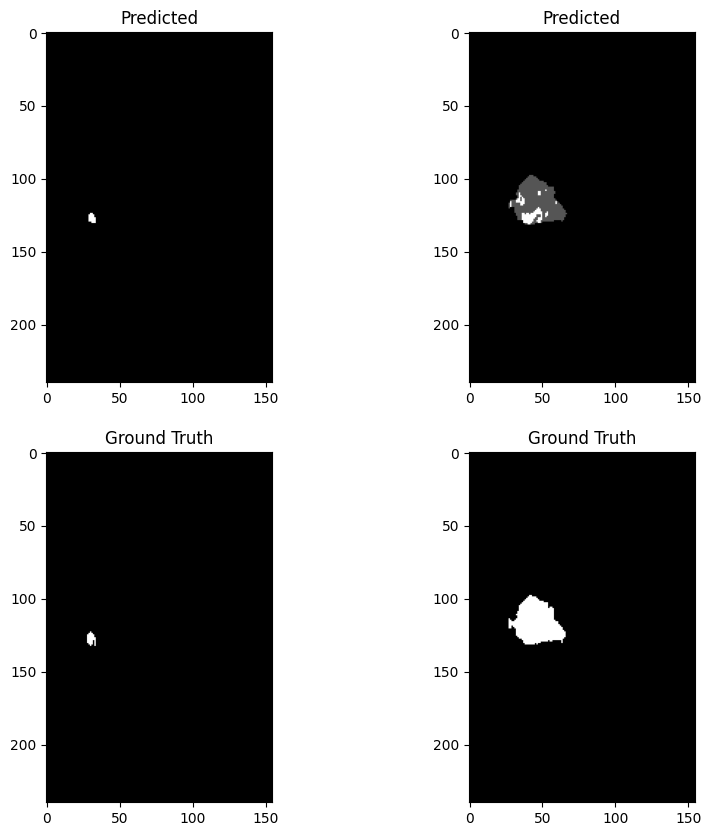

100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Average Validation Loss: 0.009928398675495578

Average Validation DSC: [0.9990505  0.88970437 0.93533841 0.81605576]
Average Validation ASSD: [ 0.10167295 12.35172699 10.44423043  6.90043764]
Epoch 93/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


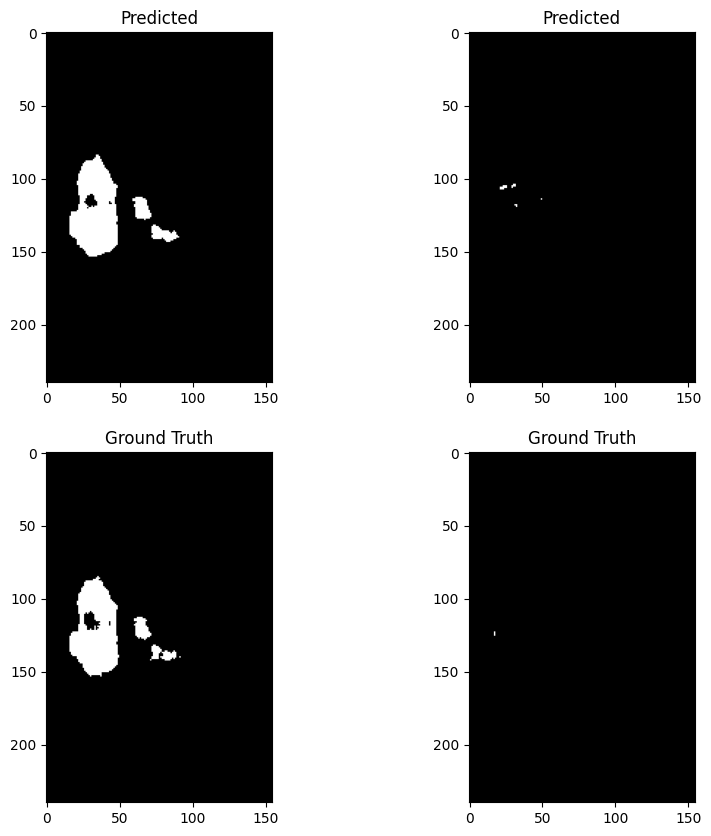

100%|██████████| 246/246 [07:31<00:00,  1.84s/it]



Average Training Loss: 0.0048090565752813485

Average Training DSC: [0.99947952 0.92856033 0.95473562 0.880569  ]
Average Training ASSD: [ 0.04852769 12.41346431  8.46676492  7.32218894]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


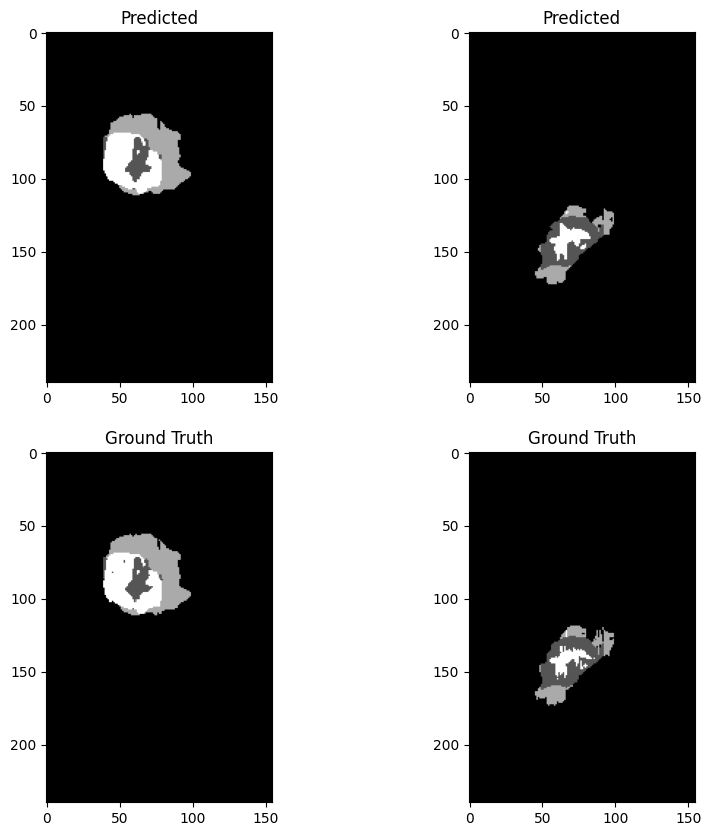

100%|██████████| 62/62 [01:17<00:00,  1.24s/it]


Average Validation Loss: 0.006929273319040094

Average Validation DSC: [0.99931074 0.92508938 0.93783499 0.87577827]
Average Validation ASSD: [ 0.066464    9.99630463 10.88804979  4.44977445]
Epoch 94/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


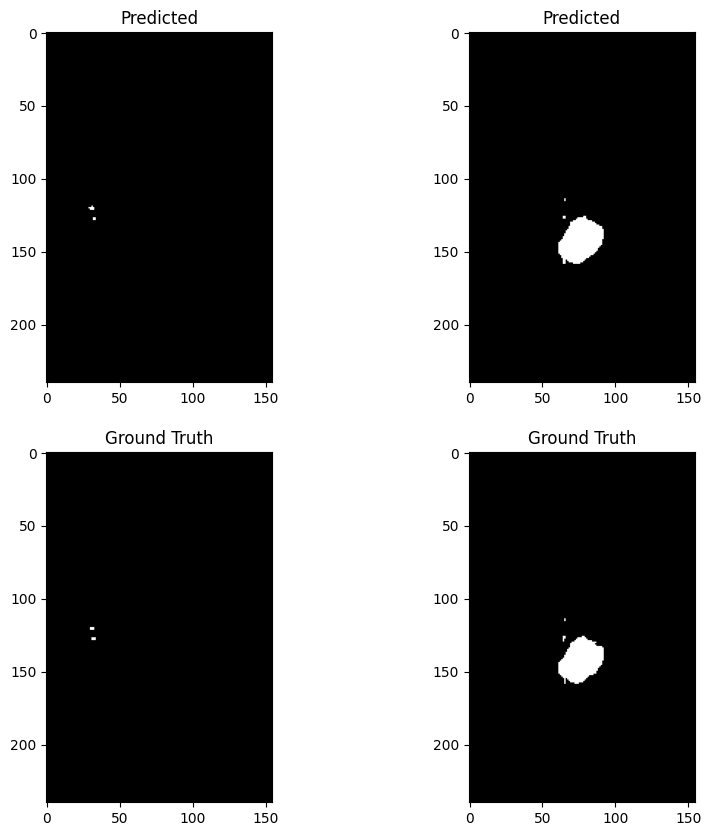

100%|██████████| 246/246 [07:31<00:00,  1.83s/it]



Average Training Loss: 0.002979710923386662

Average Training DSC: [0.99969266 0.96038909 0.96792799 0.91878977]
Average Training ASSD: [0.027857   5.52597081 5.96180476 6.05419179]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


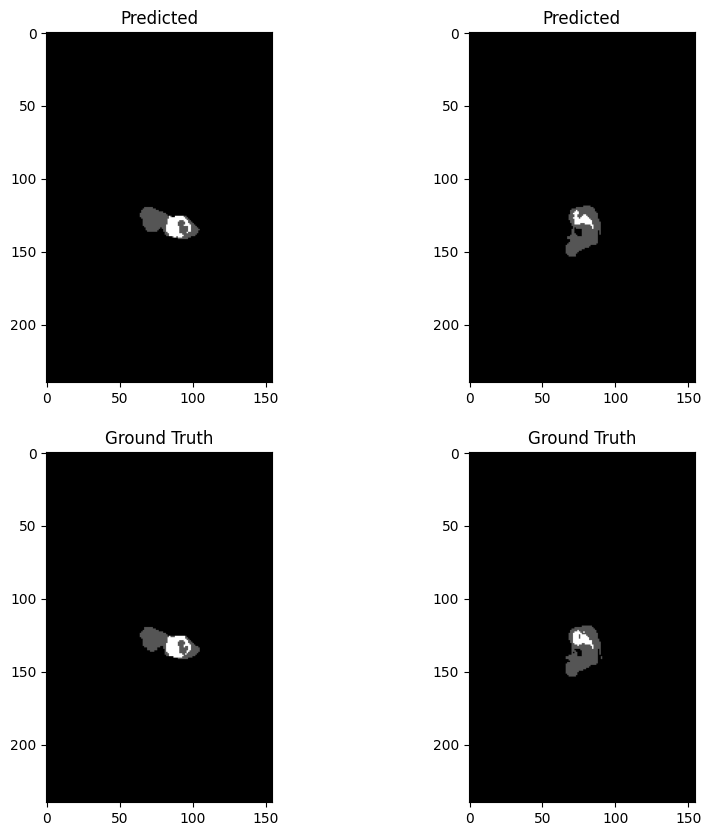

100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Average Validation Loss: 0.005127217481663871

Average Validation DSC: [0.99950585 0.94812857 0.96647685 0.89441395]
Average Validation ASSD: [0.04732008 6.03211439 3.76068197 5.49173737]
Epoch 95/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


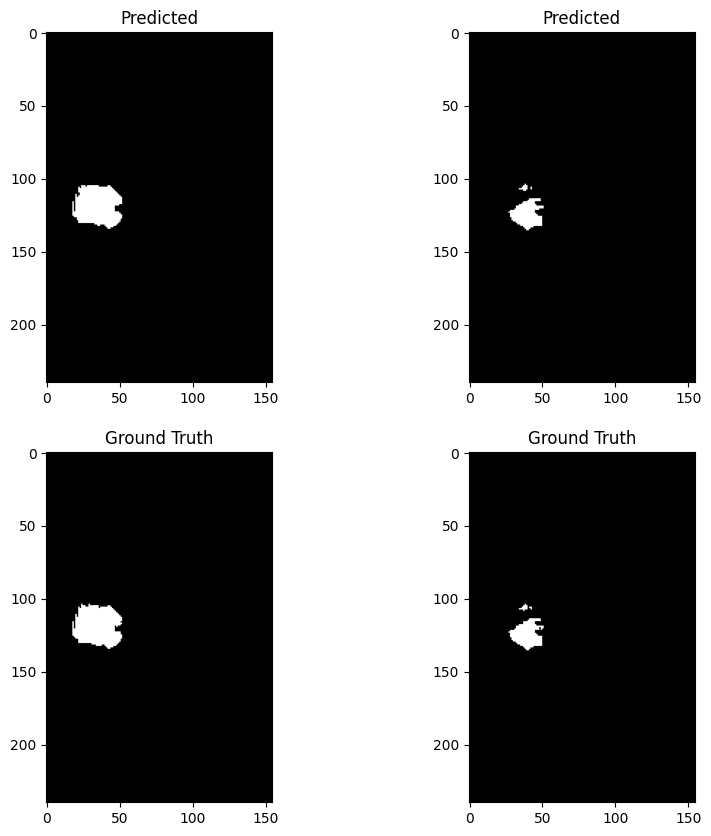

100%|██████████| 246/246 [07:31<00:00,  1.84s/it]



Average Training Loss: 0.0022167802910884556

Average Training DSC: [0.99976203 0.97204109 0.97863172 0.9369719 ]
Average Training ASSD: [0.02204469 3.46708991 3.43572455 5.21014017]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


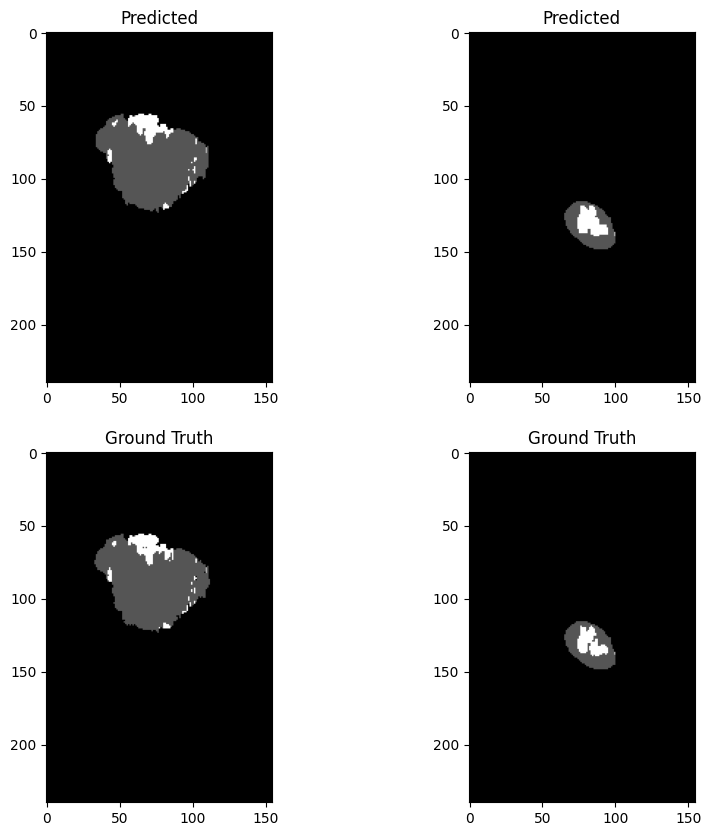

100%|██████████| 62/62 [01:20<00:00,  1.30s/it]


Average Validation Loss: 0.00516981988649575

Average Validation DSC: [0.9994748  0.92004715 0.95727386 0.88512786]
Average Validation ASSD: [ 0.05535279 14.55750818  6.6833515   5.05789589]
Epoch 96/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


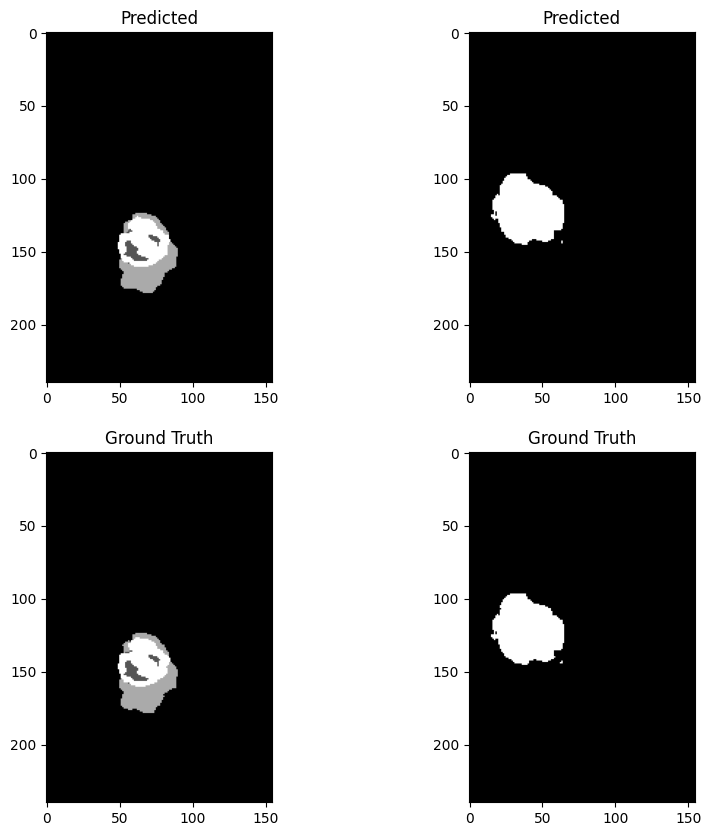

100%|██████████| 246/246 [07:37<00:00,  1.86s/it]



Average Training Loss: 0.002480932071755784

Average Training DSC: [0.99975823 0.95699229 0.97575567 0.9304415 ]
Average Training ASSD: [0.02164119 8.01913405 4.10578269 5.45377154]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


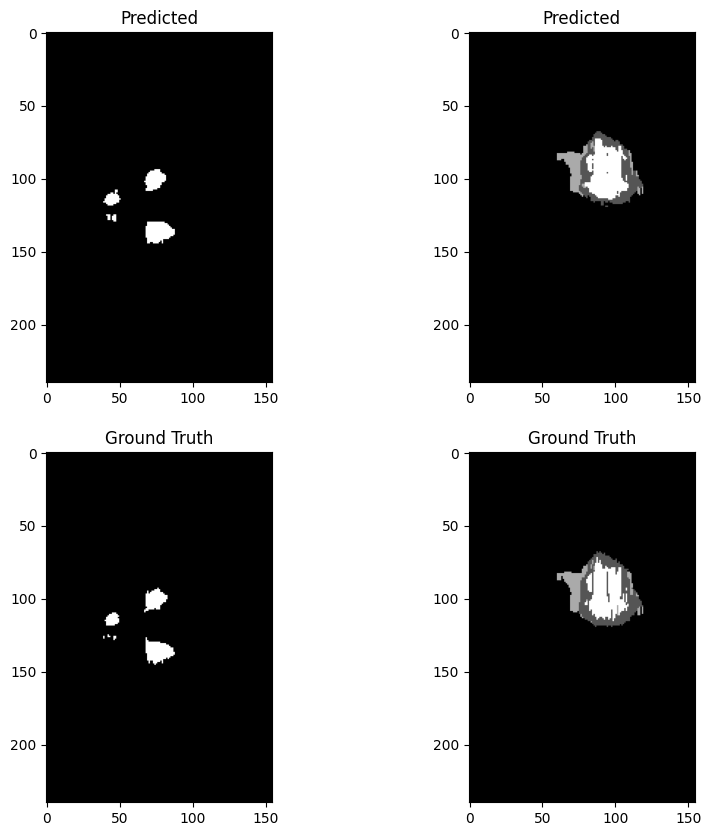

100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


Average Validation Loss: 0.005720192209757384

Average Validation DSC: [0.99946807 0.93849206 0.95991912 0.88530381]
Average Validation ASSD: [0.05382703 5.12663221 4.51820134 5.3295725 ]
Epoch 97/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


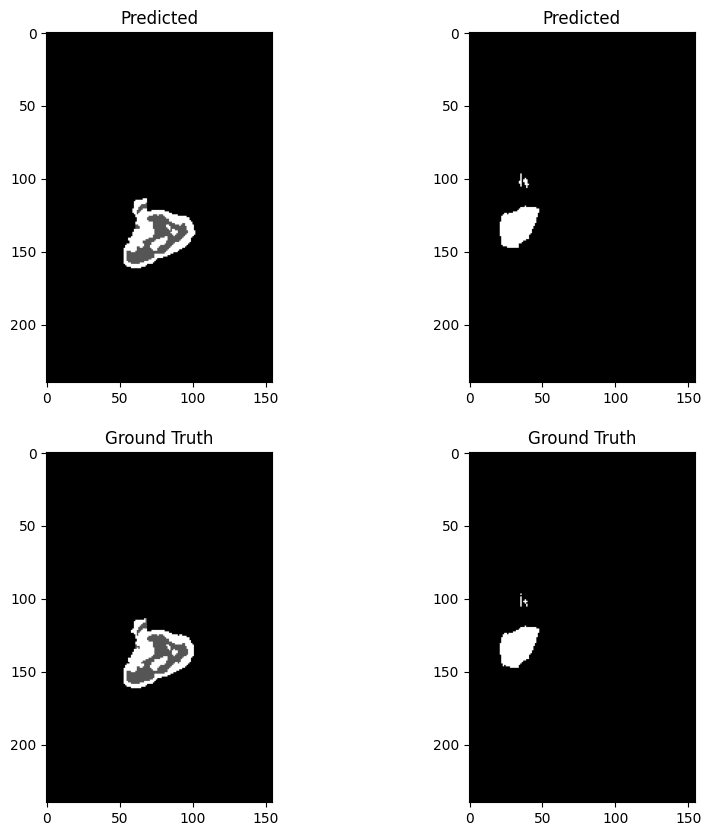

100%|██████████| 246/246 [07:29<00:00,  1.83s/it]



Average Training Loss: 0.0022173495489982813

Average Training DSC: [0.99978555 0.97278062 0.97564785 0.93787283]
Average Training ASSD: [0.01780911 2.9189163  3.99084392 5.33470661]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


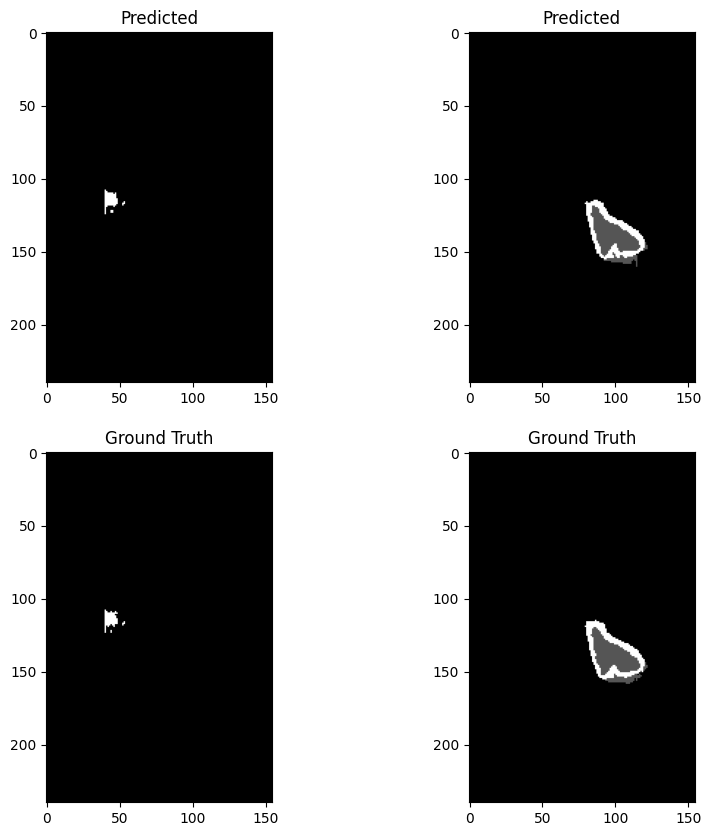

100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


Average Validation Loss: 0.005048797477126842

Average Validation DSC: [0.99957998 0.95225112 0.96633169 0.90637374]
Average Validation ASSD: [0.04110362 3.83549211 4.0150855  5.5321862 ]
Epoch 98/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


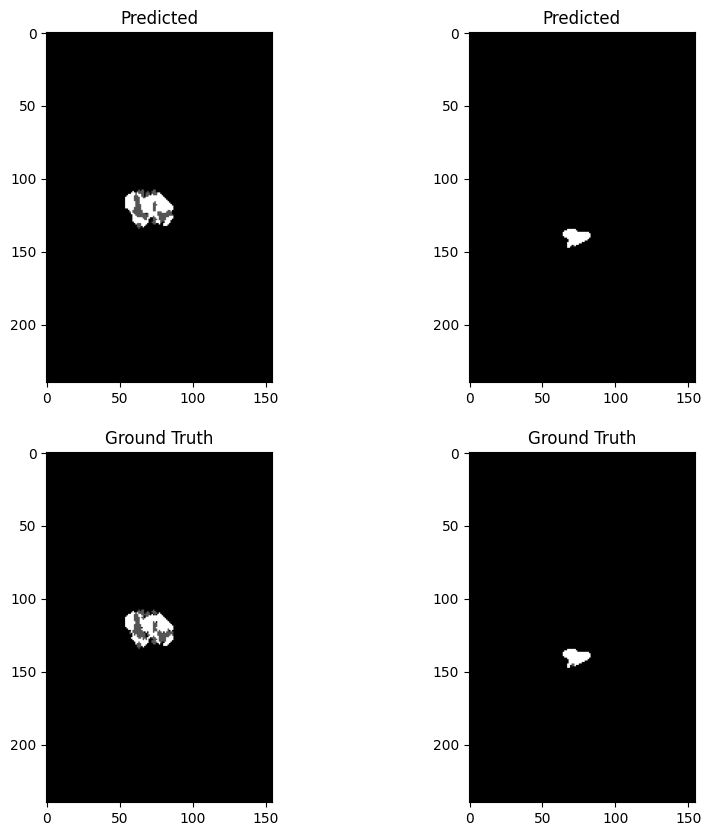

100%|██████████| 246/246 [07:36<00:00,  1.86s/it]



Average Training Loss: 0.00181586965345929

Average Training DSC: [0.99982537 0.97664407 0.97892684 0.9471673 ]
Average Training ASSD: [0.01427476 2.59505645 3.60785541 5.11257336]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


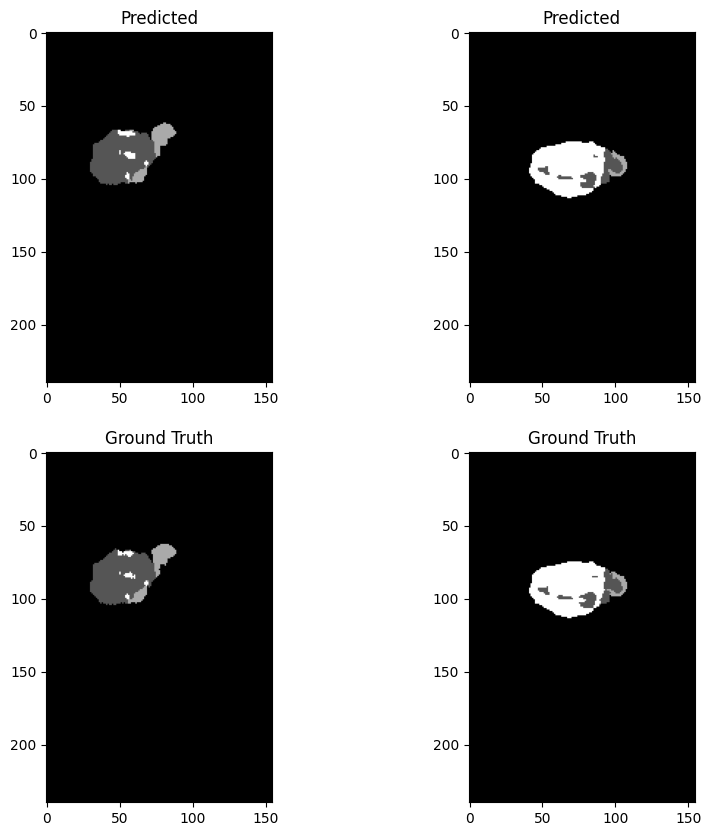

100%|██████████| 62/62 [01:20<00:00,  1.30s/it]


Average Validation Loss: 0.004698107623675418

Average Validation DSC: [0.99958073 0.9340631  0.96478044 0.90686143]
Average Validation ASSD: [ 0.03884168 11.84476787  5.44731112  5.74158673]
Epoch 99/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


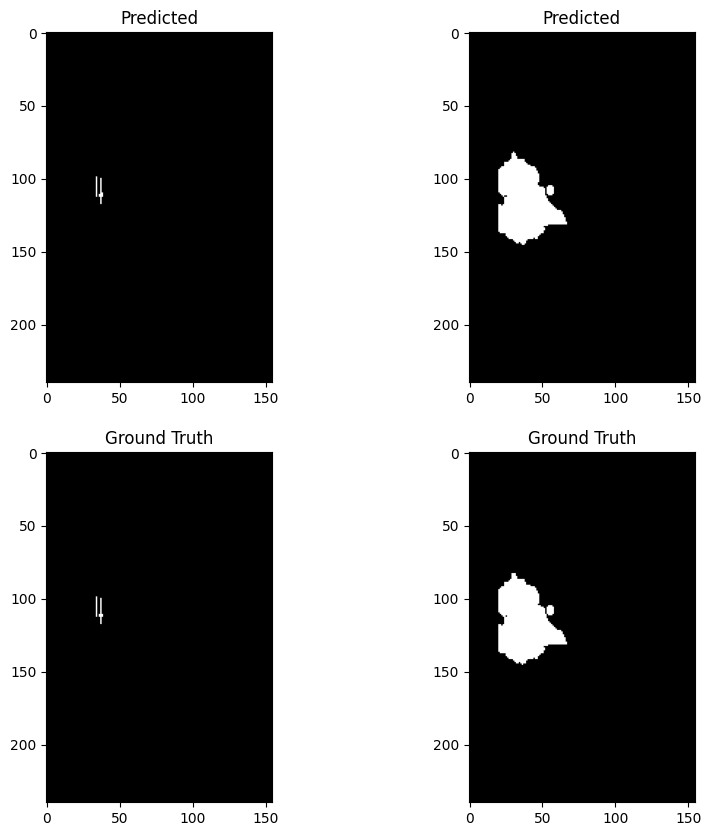

100%|██████████| 246/246 [07:36<00:00,  1.86s/it]



Average Training Loss: 0.0015392705466412764

Average Training DSC: [0.99985054 0.98147942 0.98146982 0.95408777]
Average Training ASSD: [0.0122676  1.72328752 3.1730263  4.9715756 ]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


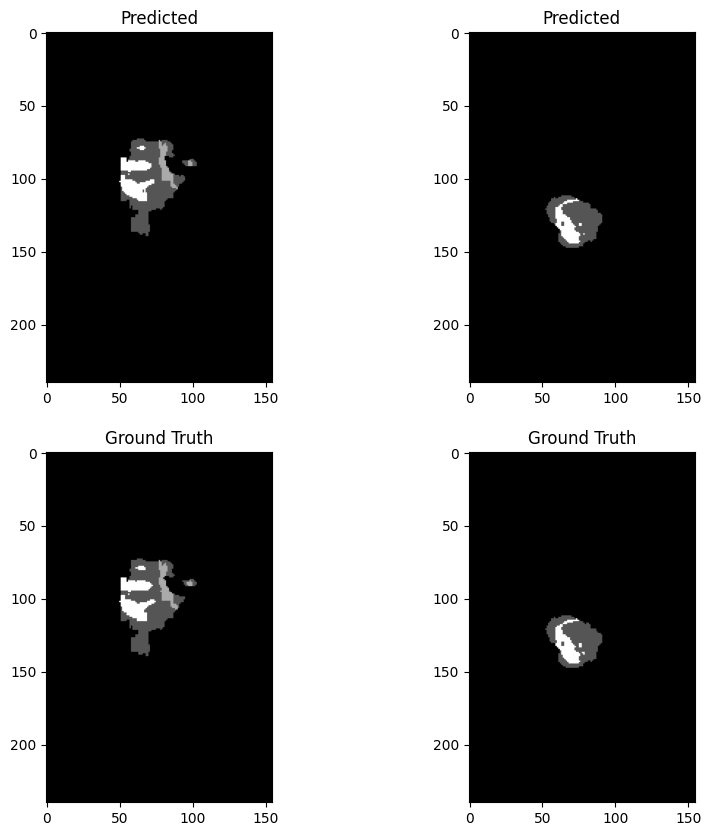

100%|██████████| 62/62 [01:21<00:00,  1.31s/it]


Average Validation Loss: 0.004877796017324492

Average Validation DSC: [0.99961072 0.96256894 0.96679715 0.91757285]
Average Validation ASSD: [0.03584706 2.35285354 4.4816057  3.56162004]
Epoch 100/100
-------------------------


  0%|          | 0/246 [00:00<?, ?it/s]

Training Prediction Visualization:


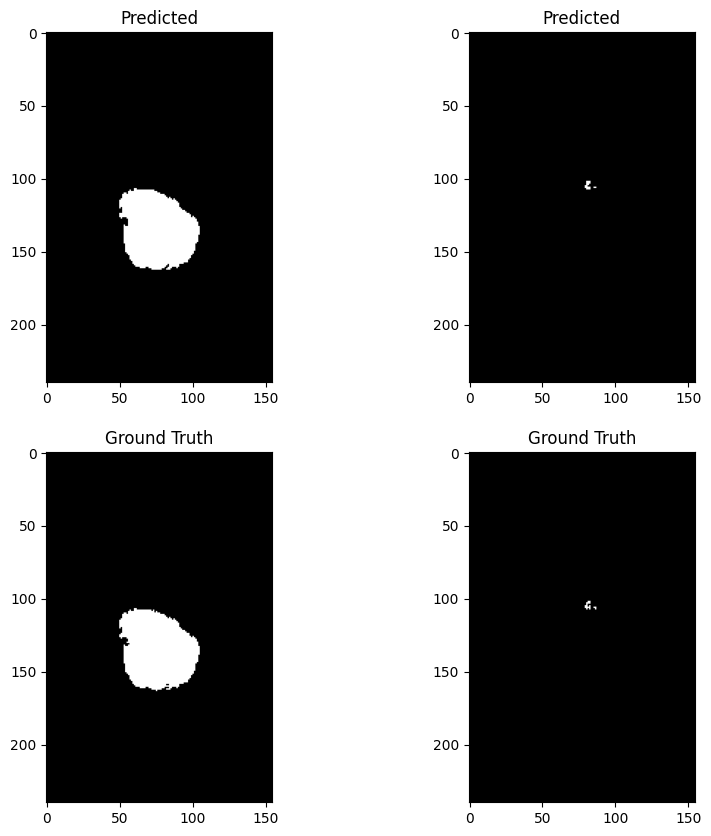

100%|██████████| 246/246 [07:37<00:00,  1.86s/it]



Average Training Loss: 0.0014240105621747643

Average Training DSC: [0.99986122 0.98520232 0.98278015 0.96036138]
Average Training ASSD: [0.01116651 0.49295132 2.91865446 3.98471395]


  0%|          | 0/62 [00:00<?, ?it/s]

Validation Prediction Visualization:


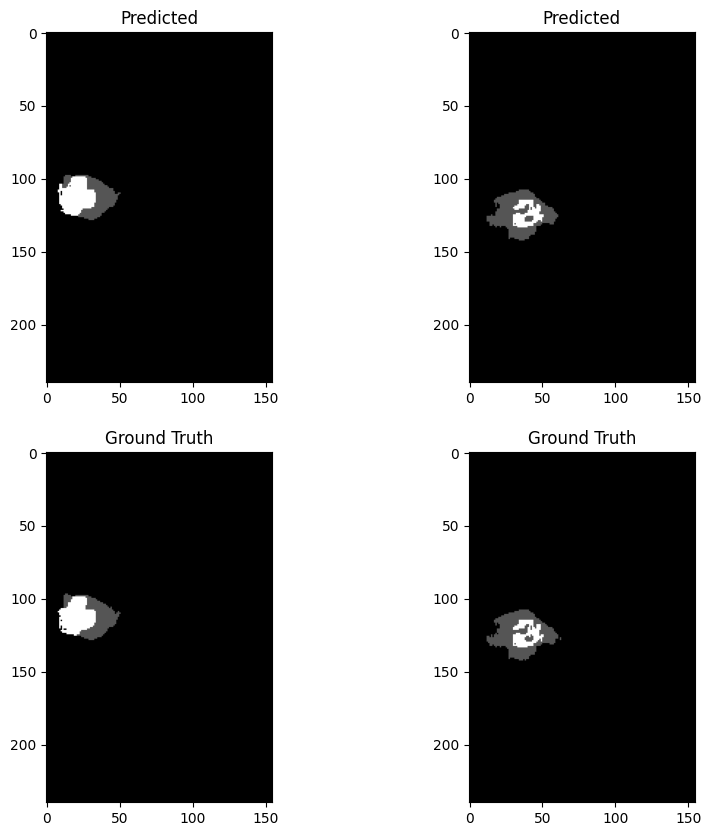

100%|██████████| 62/62 [01:19<00:00,  1.29s/it]


Average Validation Loss: 0.004983656566529986

Average Validation DSC: [0.99962293 0.96272743 0.96618584 0.91673218]
Average Validation ASSD: [0.03799599 2.3539965  4.95724019 5.69641979]


In [12]:
model = train_model(num_epochs = 100)